In [1]:
import numpy as np
from torch import nn
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import itertools
%matplotlib inline

In [2]:
torch.cuda.empty_cache()

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [5]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.walls = 1 - self._maze
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)
        self.coverage = np.zeros(self._maze.shape)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)
        self.coverage[nrow][ncol] += 1

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        rew = 0
        if rat_row == nrows-1 and rat_col == ncols-1:
          rew = 1.0
        if mode == 'blocked':
          rew = 0
        if (rat_row, rat_col) in self.visited:
          rew = 0.
        if mode == 'invalid':
          rew = 0.
        if mode == 'valid':
          rew = 0.

        return rew

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        canvas = 2 * (self._maze - canvas)
        envstate = np.stack([self._maze, self.walls, canvas], axis=0)
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [6]:
from IPython.display import clear_output
import time
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [11]:
class Network(nn.Module):
    def __init__(self, input_size, kernel_size, num_filters, out_features, device=device):
        super(Network, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(int(num_filters*(input_size[0]-kernel_size+1)*(input_size[1]-kernel_size+1)/4), 32),
            nn.PReLU(),
            nn.Linear(32, out_features)

        )
        self.to(device)

    def forward(self, x):
        return self.net(x)

    def act(self, obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32).to(device)
        q_values = self.forward(obs_t.unsqueeze(0))
        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()
        return action

class DQNAgent():
    def __init__(self, env, epsilon_start, epsilon_end, epsilon_decay, gamma, lr):
        input_size = env.maze.shape
        out_features = 4
        kernel_size = 3
        num_filters = 6
        self.num_actions = out_features
        self.gamma = gamma
        self.targets = None
        self.action_qvalues = None
        self.online_net = Network(input_size, kernel_size, num_filters, out_features)
        self.target_net = Network(input_size, kernel_size, num_filters, out_features)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.optimizer = torch.optim.Adam(self.online_net.parameters(), lr=lr)
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.counter = 1

    def choose_action(self, time, obs):
        epsilon = np.interp(time, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
        rnd_sample = random.random()
        if rnd_sample <= epsilon:
            action = random.randrange(self.num_actions)
        else:
            action = self.online_net.act(obs)

        return action

    def calculate_target(self, new_obses_t, rews_t, dones_t, var):
        target_qvalues = self.target_net(new_obses_t)
        self.target_qvalues = target_qvalues

        max_val = target_qvalues.max().item() * var

        ### Method 1
        means = target_qvalues.mean(axis=1).view(BATCH_SIZE, 1)
        bias_vals = means - target_qvalues
        for i in range(4):
          noise = torch.tensor(np.random.multivariate_normal(bias_vals[:, i].detach().cpu().numpy(), 10 * var * np.identity(BATCH_SIZE))).to(device)
          target_qvalues[:, i] += noise
        max_target_qvalues = target_qvalues.max(dim=1, keepdim=True)[0]

        ### Method 2
        # noise = torch.from_numpy(np.random.normal(0, 10 * var, target_qvalues.size())).to(device)
        # noisy_target_qvalues = target_qvalues + noise
        # max_target_qvalues = noisy_target_qvalues.max(dim=1, keepdim=True)[0]

        ### Method 3
#         max_target_qvalues = target_qvalues.max(dim=1, keepdim=True)[0]
#         noise = torch.from_numpy(np.random.normal(0, 10 * var, max_target_qvalues.size())).to(device)
#         max_target_qvalues += noise

        if self.counter % 1000 == 0:
          print(self.online_net(new_obses_t)[0,:])
          for g in self.optimizer.param_groups:
            g['lr'] *= 0.85
            print(g['lr'])

        self.targets = rews_t + self.gamma * (1 - dones_t) * max_target_qvalues

    def calculate_action_qvalues(self, obses_t, actions_t):
        q_values = self.online_net(obses_t)
        self.action_qvalues = torch.gather(input=q_values, dim=1, index=actions_t)

    def optimize_network(self):
        loss = nn.functional.smooth_l1_loss(self.action_qvalues, self.targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

In [12]:
GAMMA = 0.9
BATCH_SIZE = 32
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 0.0001
EPSILON_END = 0.0001
EPSILON_DECAY = 5000
TARGET_UPDATE_FREQ = 200

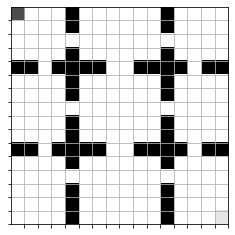

In [13]:
maze = [
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
]
env = Qmaze(maze)
show(env)

trained 0.1-500 0 times - ep num = 0
tensor([3.1126, 3.1939, 3.0722, 3.1497], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([3.8250, 3.8076, 3.6793, 3.8262], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([3.5737, 3.7310, 3.8307, 3.8980], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999999996
tensor([-10395.4277, -10486.0254, -10649.7373, -10238.8672], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.26100312499999995
tensor([-6206.8154, -6250.8457, -6051.9971, -6196.7949], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.22185265624999995


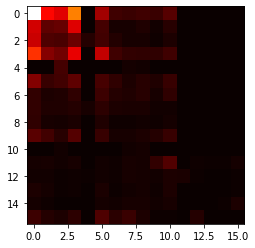

trained 0.1-500 0 times - ep num = 1
tensor([-3487.2979, -3496.3938, -3474.4514, -3459.8372], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-827.1730, -822.9014, -846.7430, -825.0256], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-514.4150, -509.4772, -523.2663, -512.1772], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([-312.8415, -299.9907, -302.6435, -301.2150], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([-115.0576, -117.9993, -119.0875, -119.3884], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


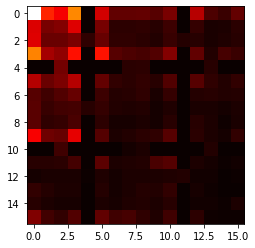

trained 0.1-500 0 times - ep num = 4
tensor([-73.1915, -71.9158, -74.2105, -70.7768], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([-41.9428, -42.1172, -42.2614, -42.1690], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([-23.4748, -23.5884, -23.5626, -23.7514], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([-12.7273, -13.0338, -13.2845, -13.5135], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([-7.8043, -8.1543, -8.4194, -7.6537], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


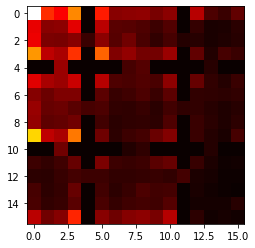

trained 0.1-500 0 times - ep num = 7
tensor([ -13.3995, -103.1502,  -47.7546,   39.4325], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([-2.0894, -2.8723,  0.6746, -4.2998], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([-3.7614, -2.6316, -4.9286, -5.1842], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([-0.7287, -0.3907,  0.1297,  1.9982], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([2.4259, 2.0585, 3.8006, 2.2819], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-500 0 times - ep num = 8
tensor([0.9460, 1.4813, 1.4101, 0.9513], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([1.2186, 1.2989, 1.7555, 2.1735], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([1.9992, 1.2136, 1.7348, 1.5421], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([

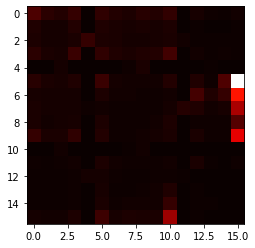

trained 0.1-500 0 times - ep num = 10
tensor([0.7932, 0.8286, 0.7332, 0.8450], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.7691, 0.7684, 0.7530, 0.7502], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.9092, 0.9190, 0.8814, 0.9290], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.8225, 0.8493, 0.8346, 0.8616], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.7448, 0.7651, 0.7884, 0.7985], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-500 0 times - ep num = 10
trained 0.1-500 1 times - ep num = 0
tensor([4.1433, 4.1283, 3.8913, 5.1799], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([-46.6648, -51.8063, -37.1257, -41.1650], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([-107.2475, -109.6438, -119.1816, -109.1752], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.

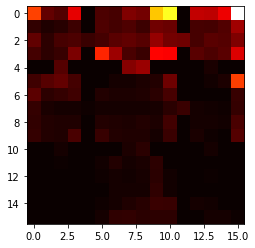

trained 0.1-500 1 times - ep num = 2
tensor([-20.4877, -20.6693, -20.5538, -20.4821], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-11.7529, -11.5853, -10.8320, -12.3680], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([15.9653, 15.2707, 15.3419, 13.9542], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([10.4064, 10.3935, 10.4434, 10.4418], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([7.0365, 7.0738, 7.0194, 7.0103], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


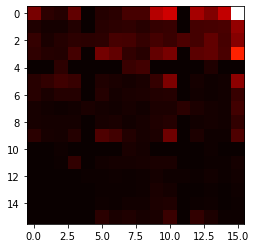

trained 0.1-500 1 times - ep num = 5
tensor([4.9456, 4.9813, 5.0649, 4.6482], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([3.7554, 3.7147, 3.7442, 3.6801], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([3.0146, 3.1040, 3.1406, 2.9128], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([2.5182, 2.0436, 2.1844, 2.5287], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([2.0051, 2.0330, 1.9989, 2.0229], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


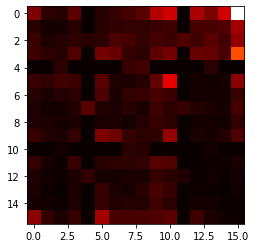

trained 0.1-500 1 times - ep num = 8
tensor([1.8711, 1.8556, 1.8537, 1.8035], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([1.7616, 1.7695, 1.7476, 1.7682], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([1.6464, 1.6866, 1.6418, 1.7178], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([1.6265, 1.5971, 1.6184, 1.5915], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([1.6064, 1.5358, 1.5350, 1.5240], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-500 1 times - ep num = 11
tensor([1.5416, 1.4861, 1.4767, 1.5596], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([1.4547, 1.6227, 1.6712, 1.3703], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([1.3254, 1.3609, 1.4226, 1.4975], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([1.3803, 1.3927, 1.3938,

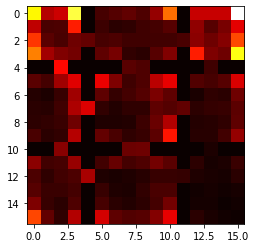

trained 0.1-500 1 times - ep num = 20
tensor([0.9267, 0.9324, 0.9230, 0.9271], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.9358, 0.9225, 0.9156, 0.9212], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.9130, 0.9184, 0.9189, 0.9283], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.9111, 0.9113, 0.9094, 0.9105], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.9039, 0.9057, 0.9039, 0.9038], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-500 1 times - ep num = 21
trained 0.1-500 2 times - ep num = 0
tensor([2.2045, 2.3165, 2.2333, 2.3936], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([3.1444, 3.3880, 3.2999, 3.5894], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([24.0964, 10.7548, 37.3426, -6.8811], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.3070624999999999

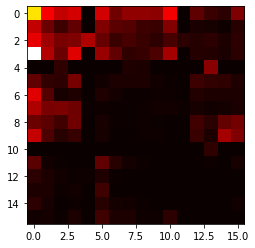

trained 0.1-500 2 times - ep num = 1
tensor([32.2152, 31.5681, 31.9556, 31.6950], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([21.0274, 19.5537, 20.5463, 19.5557], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([13.4157, 13.7208, 13.5670, 13.8294], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([8.9784, 9.1203, 8.9308, 8.8417], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([ 0.0715, 18.7188,  3.0763,  4.5590], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


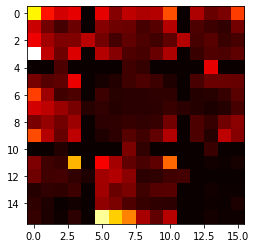

trained 0.1-500 2 times - ep num = 3
tensor([4.0924, 5.5458, 6.8731, 6.9563], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([3.5357, 4.9461, 4.9938, 6.6503], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([3.4722, 3.4985, 4.1112, 3.6547], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([-4.0454, -3.8797, -4.6374, -4.5365], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([-4.5156, -2.3799, -4.4780, -2.9763], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


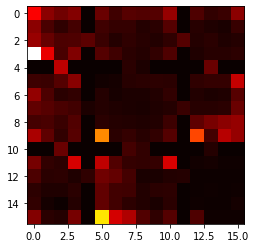

trained 0.1-500 2 times - ep num = 6
tensor([0.1453, 0.2426, 0.2128, 0.2764], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([0.8235, 0.8623, 0.8218, 0.7116], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([0.4230, 0.4270, 0.4156, 0.4406], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([0.7531, 0.8652, 0.8656, 0.9274], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([1.1817, 1.0703, 1.1048, 1.0250], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-500 2 times - ep num = 6
tensor([1.2739, 1.2795, 1.2566, 1.2274], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([1.2406, 1.3110, 1.3392, 1.3326], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([1.3350, 1.3455, 1.3186, 1.3552], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([-1.8547, -1.8550, -1.848

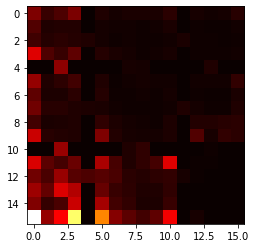

trained 0.1-500 2 times - ep num = 6
tensor([0.9361, 0.9432, 0.9378, 0.9510], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([0.9715, 0.9341, 0.9277, 0.8835], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([0.9236, 0.9230, 0.9191, 0.9293], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([0.9220, 0.9159, 0.9140, 0.9196], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([0.9119, 0.9128, 0.9054, 0.9152], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-500 2 times - ep num = 6
trained 0.1-1000 0 times - ep num = 0
tensor([4255.6987, 4613.5098, 4850.8115, 4268.0845], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([2381.5698, 2348.9822, 2366.9663, 2348.7061], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([1453.3656, 1492.2736, 1348.8344, 1612.2954], device='cuda:0',
       grad_fn=<Slic

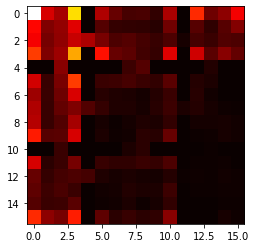

trained 0.1-1000 0 times - ep num = 2
tensor([-277.3423, -218.9008, -179.4739, -187.2388], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([ -89.4906, -180.5043, -178.9419, -155.0646], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-58.6243, -60.2635, -56.6201, -62.3599], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([-35.5906, -36.4436, -36.1997, -35.4582], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([-20.8541, -21.3394, -21.1390, -20.9506], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


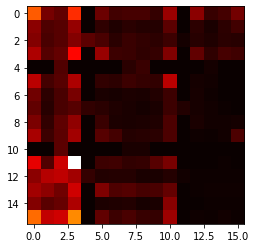

trained 0.1-1000 0 times - ep num = 3
tensor([  17.4933, -189.6272, -214.7600,   -7.6763], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([-31.8682, -31.9176, -32.1041, -32.1708], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([-19.4630, -19.4971, -19.5217, -19.4798], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([-10.5608, -10.5770, -10.5725, -10.5384], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([-5.1628, -5.1967, -5.2366, -5.2121], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


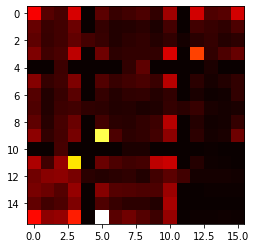

trained 0.1-1000 0 times - ep num = 3
tensor([-2.1270, -2.2135, -2.1322, -2.0154], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([-0.3368, -0.3390, -0.3350, -0.2712], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([0.6323, 0.6824, 0.6825, 0.6817], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([1.3048, 1.3153, 1.2940, 1.2778], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([1.2888, 1.1877, 1.2450, 1.3290], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-1000 0 times - ep num = 5
tensor([1.5536, 1.5497, 1.5530, 1.5647], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([1.7449, 1.7500, 1.7469, 1.7339], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([1.8302, 1.8058, 1.8229, 1.8576], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([1.8281, 1.8313

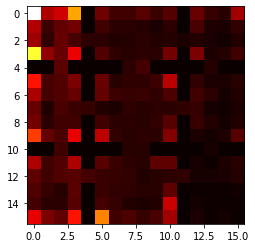

trained 0.1-1000 0 times - ep num = 17
tensor([1.3285, 1.3222, 1.3252, 1.3277], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([1.3222, 1.3030, 1.3095, 1.3371], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([1.2995, 1.2970, 1.2960, 1.3020], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([1.2899, 1.2896, 1.2918, 1.2934], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([1.2885, 1.2841, 1.2805, 1.2850], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-1000 0 times - ep num = 18
trained 0.1-1000 1 times - ep num = 0
tensor([19.1768,  7.6988, 11.3476,  0.2927], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([ 3.2824,  9.1876,  6.0215, 11.4564], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([51.1232, 46.9636, 37.3895, 54.0889], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706

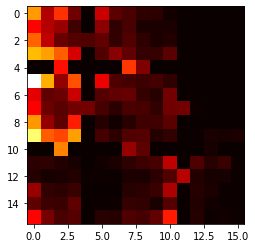

trained 0.1-1000 1 times - ep num = 2
tensor([13.6941, 13.5561, 13.9980, 13.8801], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([8.9370, 8.8222, 9.2942, 9.4086], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([6.9677, 6.7921, 6.7704, 7.3251], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([5.3720, 5.3488, 5.2874, 5.1612], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([0.7272, 0.5826, 0.8106, 0.5778], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


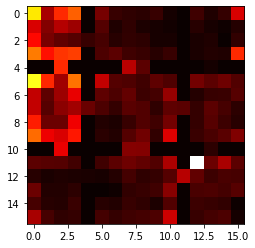

trained 0.1-1000 1 times - ep num = 6
tensor([4.2346, 1.5778, 0.7333, 0.7892], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([  3.5624, -10.2011,   1.3395,  -1.9501], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([2.4623, 2.5549, 2.2980, 2.4051], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([2.4915, 2.1151, 2.5402, 2.5583], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([2.4240, 2.5927, 2.5180, 2.3527], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


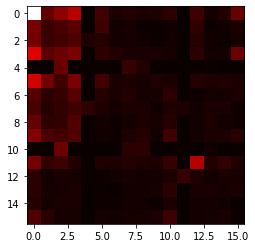

trained 0.1-1000 1 times - ep num = 6
tensor([2.2906, 2.3206, 2.2434, 2.2528], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([-3.7198,  3.3609, -6.1026,  3.5374], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([5.1317, 5.1299, 5.1068, 5.1501], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([4.0459, 3.9087, 3.6277, 3.8941], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([3.1291, 3.1314, 3.1185, 3.1698], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-1000 1 times - ep num = 8
tensor([2.6896, 2.6818, 2.6763, 2.6698], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([2.4580, 2.2225, 2.1247, 2.4741], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([2.2190, 2.2423, 2.2300, 2.1738], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([2.0546, 2.0516, 2.

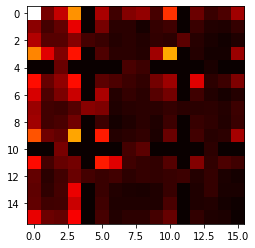

trained 0.1-1000 1 times - ep num = 11
tensor([1.3340, 1.3461, 1.3245, 1.3266], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([1.3189, 1.3215, 1.3195, 1.3204], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([1.3071, 1.3073, 1.3112, 1.3097], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([1.2854, 1.3092, 1.3168, 1.3036], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([1.2916, 1.2910, 1.2894, 1.2834], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-1000 1 times - ep num = 11
trained 0.1-1000 2 times - ep num = 0
tensor([-4537.0381, -4667.6650, -4626.5742, -4528.9482], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([-3090.0132, -2985.6421, -2867.7996, -3026.1372], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([-1895.1974, -1822.3892, -1902.7025, -1830.8014], device='cuda:0',
    

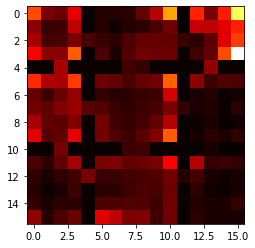

trained 0.1-1000 2 times - ep num = 4
tensor([-49.2965, -49.3220, -49.2581, -49.0790], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-352.7641, -514.6292,   23.7681,   71.0558], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-220.2463, -270.3728, -217.5938, -228.9558], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([-186.2348, -191.2054, -171.3652, -174.1115], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([-95.1557, -94.5884, -96.7220, -95.3631], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


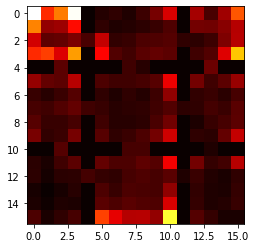

trained 0.1-1000 2 times - ep num = 9
tensor([-74.9311, -74.6549, -74.6442, -75.0047], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([-61.6707, -50.9440, -33.5012, -57.0951], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([-30.3470, -31.1247, -30.4003, -32.2129], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([-32.2112, -32.0554, -32.2137, -32.2458], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([-12.7292, -17.0959, -12.5987, -15.8259], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


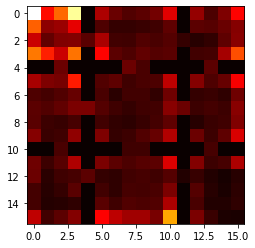

trained 0.1-1000 2 times - ep num = 13
tensor([13.9910, 11.6478, 15.2484,  8.4873], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([-14.2483, -14.1828, -13.9960, -14.0451], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([-10.1183, -10.0240,  -9.7958,  -9.9490], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([-4.8078, -5.0552, -5.1699, -3.6563], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([-1.6057, -1.8140, -1.7337, -1.8016], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-1000 2 times - ep num = 15
tensor([-1.0271, -0.6097, -0.6659, -0.6251], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([2.9987, 6.9877, 3.4901, 4.3699], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([2.4558, 2.9050, 2.1845, 3.0675], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638

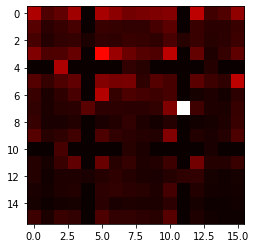

trained 0.1-1000 2 times - ep num = 25
tensor([1.1899, 1.1682, 1.2054, 1.2098], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([1.2532, 1.2620, 1.3059, 1.2279], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([1.2521, 1.2675, 1.2380, 1.2599], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([1.2727, 1.2617, 1.2558, 1.2528], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([1.2665, 1.2376, 1.2475, 1.2211], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-1000 2 times - ep num = 25
trained 0.1-5000 0 times - ep num = 0
tensor([3.0750, 3.9255, 3.7563, 3.2275], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([5.9217, 5.9886, 6.1440, 5.7621], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([28034.8164, 28208.3867, 28730.4082, 27811.9609], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.3

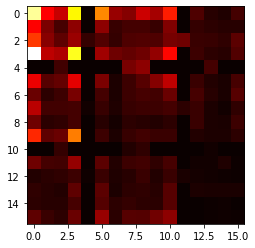

trained 0.1-5000 0 times - ep num = 1
tensor([5939.1289, 5984.0293, 6025.3511, 6021.1685], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([3520.7788, 3476.3508, 3496.2991, 3482.3826], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([2129.6487, 2104.7681, 2127.6030, 2136.3843], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([1279.2930, 1276.1614, 1282.1725, 1290.0391], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([754.4998, 754.7872, 743.8873, 744.7009], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


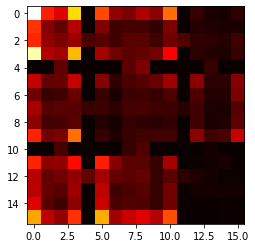

trained 0.1-5000 0 times - ep num = 2
tensor([439.4789, 443.8380, 442.7926, 443.4788], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([252.3749, 252.9652, 251.3926, 250.7257], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([151.8802, 151.7985, 152.8055, 151.2948], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([88.8849, 88.8374, 88.3308, 87.9225], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([53.8970, 53.8964, 53.3970, 53.7930], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


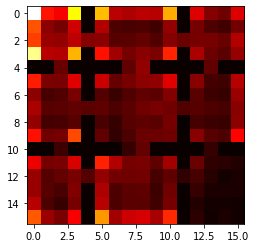

trained 0.1-5000 0 times - ep num = 5
tensor([33.7267, 33.4510, 34.1577, 33.5655], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([21.8219, 21.7338, 22.3152, 22.3859], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([15.0637, 14.2881, 14.8183, 15.3939], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([11.6687, 11.3248, 11.5312, 11.8260], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([7.4346, 8.0815, 8.6795, 8.8719], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-5000 0 times - ep num = 6
tensor([6.3837, 6.2847, 6.4873, 6.8632], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([5.1838, 5.2546, 5.2544, 5.3681], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([5.6267, 5.5612, 5.1651, 5.6734], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([4.7679

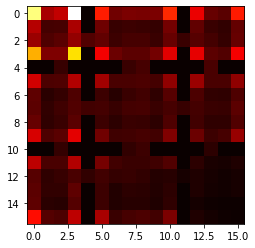

trained 0.1-5000 0 times - ep num = 15
tensor([2.9137, 2.8658, 2.9053, 2.9071], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.8150, 2.7984, 2.8517, 2.7847], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.8758, 2.8943, 2.8734, 2.8892], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.7978, 2.8256, 2.8388, 2.8360], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.7260, 2.7699, 2.7455, 2.7310], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-5000 0 times - ep num = 16
trained 0.1-5000 1 times - ep num = 0
tensor([1187.4878, 1126.7383, 1234.8604, 1409.9993], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([507.1737, 499.8775, 518.1313, 510.1886], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([ 321.7039, -105.4933,  984.1835,  621.8347], device='cuda:0',
       grad_fn=<Slic

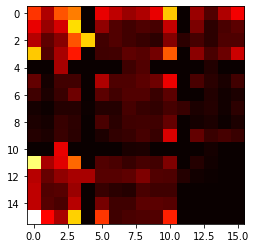

trained 0.1-5000 1 times - ep num = 0
tensor([71.4005, 68.7371, 74.1000, 71.6563], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([45.3747, 45.4831, 45.4114, 45.6027], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([29.5302, 29.4902, 29.4090, 29.5014], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([20.0491, 20.2872, 19.7670, 19.9569], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([14.5151, 14.4968, 14.4795, 14.5052], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


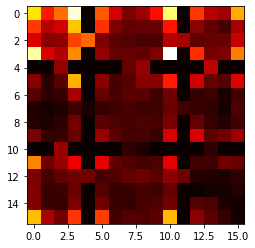

trained 0.1-5000 1 times - ep num = 4
tensor([-630.0111, -626.3206, -599.1533, -616.7037], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([-396.1148, -403.3917, -387.5172, -400.0617], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([-220.0937, -204.6639, -220.4229, -213.7286], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([-125.5017, -133.8879, -128.7230, -128.6170], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([-66.4994, -65.7541, -65.1396, -66.0237], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


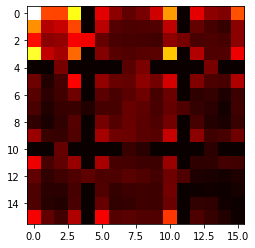

trained 0.1-5000 1 times - ep num = 5
tensor([-46.8146, -46.5262, -46.0397, -45.7230], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([-25.7964, -26.1646, -26.5662, -26.0392], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([-14.0124, -13.7896, -13.6336, -14.0369], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([  1.1392, -11.7439,  18.4781,  31.6074], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([-3.9559, -4.1027, -3.5410, -4.2849], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-5000 1 times - ep num = 7
tensor([-1.0858, -1.3500, -1.1815, -0.9109], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([1.6210, 2.2002, 1.0954, 1.0650], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([1.9748, 1.5156, 2.1094, 2.0774], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598

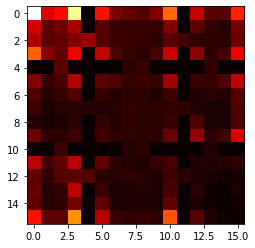

trained 0.1-5000 1 times - ep num = 20
tensor([2.9024, 2.9361, 2.9262, 2.9283], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.9055, 2.8437, 2.8473, 2.8395], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.7886, 2.8276, 2.7086, 2.7777], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.8240, 2.8133, 2.7917, 2.8184], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.8305, 2.8285, 2.8256, 2.8255], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-5000 1 times - ep num = 20
trained 0.1-5000 2 times - ep num = 0
tensor([3.1912, 3.0168, 3.3958, 3.6797], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([25662.2754, 24711.3535, 24534.0156, 24391.8926], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([14473.6455, 14293.1602, 14422.6797, 14556.2402], device='cuda:0',
       grad_fn=<Slic

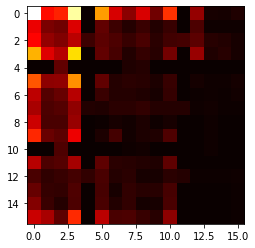

trained 0.1-5000 2 times - ep num = 1
tensor([2887.2612, 3021.3130, 2931.1558, 2883.3088], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([1831.3470, 1852.1002, 1840.5890, 1868.9016], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([1086.5789, 1086.0208, 1086.1912, 1083.8151], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([574.9670, 618.8200, 566.1682, 572.6448], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([401.3462, 404.2292, 398.0578, 403.3440], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


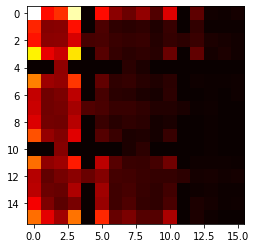

trained 0.1-5000 2 times - ep num = 1
tensor([232.2039, 231.9239, 231.6611, 233.3772], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([142.1143, 141.1779, 141.1752, 141.1868], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([86.8690, 86.7602, 87.0497, 86.7020], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([54.6131, 55.5024, 55.5048, 55.7866], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([33.0822, 34.0977, 34.2096, 34.2310], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


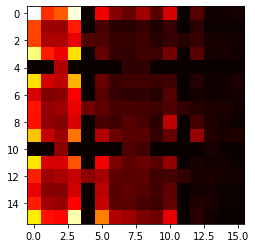

trained 0.1-5000 2 times - ep num = 1
tensor([20.5228, 21.7543, 22.1865, 22.1814], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([14.2081, 13.2623, 13.7787, 12.9207], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([8.7151, 8.8311, 8.7233, 8.5997], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([7.4788, 7.1022, 7.3093, 7.2920], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([5.8246, 5.9385, 5.2925, 4.9537], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.1-5000 2 times - ep num = 2
tensor([6.1584, 5.6845, 6.1159, 6.8727], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([5.3844, 5.8325, 5.7076, 5.5275], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([4.5944, 4.7086, 4.5436, 5.1241], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([5.0377, 4.9471

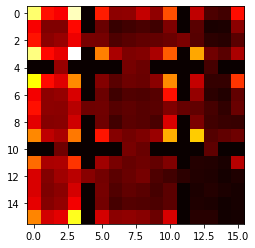

trained 0.1-5000 2 times - ep num = 18
tensor([2.8137, 2.7626, 2.8068, 2.8198], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.6905, 2.7430, 2.7020, 2.7424], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.7712, 2.7689, 2.7634, 2.7113], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.6975, 2.7604, 2.7171, 2.7648], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.7335, 2.7724, 2.7737, 2.8121], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.1-5000 2 times - ep num = 18
trained 0.5-500 0 times - ep num = 0
tensor([6.9858, 5.8149, 6.1706, 6.9496], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([8.1725, 8.1379, 8.2171, 8.2474], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([7.9989, 8.2609, 9.0008, 8.9879], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999999996


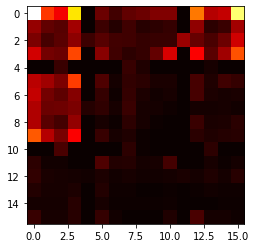

trained 0.5-500 0 times - ep num = 2
tensor([-140.7547, -147.3628, -150.5638, -144.6905], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-85.1682, -83.6396, -82.4313, -78.8998], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-97.2330,   0.5886, -39.1721,  90.2695], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([219.0788, 242.6675, 258.6213, 248.4612], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([156.7492,  73.7276, 103.5651, 132.4906], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


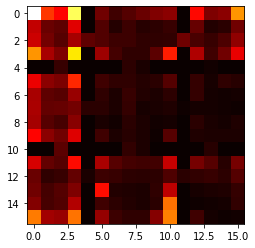

trained 0.5-500 0 times - ep num = 5
tensor([-35.0385, -36.7445, -38.4726, -35.2315], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([-20.5338, -22.1202, -19.4740, -21.0496], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([-20.5550, -25.6194, -13.0661, -18.7568], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([-11.8231,  -8.7067, -13.0067, -38.1014], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([-10.1294,  -9.8932, -12.0918, -10.4878], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


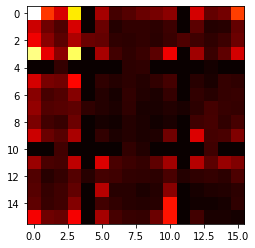

trained 0.5-500 0 times - ep num = 10
tensor([-21.7949, -22.1952, -22.4378, -22.3066], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([-12.6957, -12.3718, -12.1657, -12.9889], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([15.8233, 15.9378, 16.5185, 15.5768], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([11.3988, 10.7212, 11.6778, 11.3435], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([7.8635, 7.5218, 7.3680, 6.9425], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-500 0 times - ep num = 12
tensor([5.2939, 5.2719, 5.1374, 5.3503], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([3.7297, 3.7771, 3.8052, 4.0334], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([3.4640, 3.1615, 3.4782, 3.4720], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor

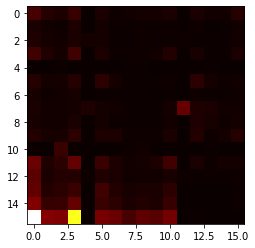

trained 0.5-500 0 times - ep num = 13
tensor([1.7975, 1.7946, 1.6239, 1.6828], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([1.7156, 1.7637, 1.8146, 1.7897], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.0337, 1.9958, 1.9780, 2.0319], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.0013, 2.0311, 1.9852, 2.0266], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.0488, 2.0230, 2.0531, 2.0658], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-500 0 times - ep num = 13
trained 0.5-500 1 times - ep num = 0
tensor([5.8046, 6.5202, 5.2125, 6.2916], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([-279.1237,    5.1977, -325.2622,  285.4491], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([20.9198, 20.5608, 20.4860, 20.9639], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.3070

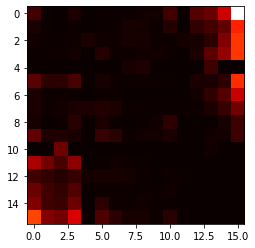

trained 0.5-500 1 times - ep num = 1
tensor([20.9131, 44.0576, 10.5877,  5.4482], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([14.7848, 13.9796, 15.3390, 14.0181], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([8.2443, 8.1362, 8.2275, 8.1670], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([6.9814, 7.1168, 6.8818, 6.8155], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([4.4935, 4.3934, 4.4999, 4.3719], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


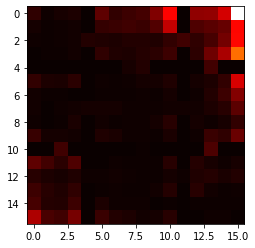

trained 0.5-500 1 times - ep num = 3
tensor([4.1054, 4.3717, 4.7732, 4.3651], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([4.4591, 4.4214, 4.4416, 4.3234], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([4.1831, 4.2926, 4.2317, 4.3125], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([3.6804, 3.6254, 3.9732, 3.9418], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([ -9.2310, -62.2231,  78.0866,  62.2877], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


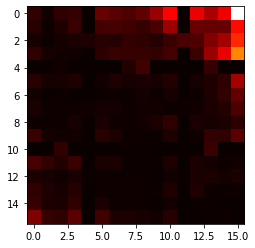

trained 0.5-500 1 times - ep num = 3
tensor([1.6337, 1.6360, 1.5657, 1.6166], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([2.4171, 2.4781, 2.5658, 2.4240], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([2.8653, 2.9663, 3.0150, 2.9453], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([3.0984, 3.1016, 3.0801, 3.0563], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([3.2466, 3.0109, 3.1403, 3.0716], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-500 1 times - ep num = 5
tensor([2.9127, 3.0040, 2.9812, 3.0208], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([3.0537, 3.0139, 3.0254, 3.0265], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([3.0265, 3.0690, 3.0159, 3.0018], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([2.9822, 3.0845, 3.1801, 

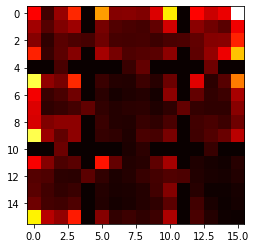

trained 0.5-500 1 times - ep num = 11
tensor([2.1233, 2.1206, 2.1175, 2.1182], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.1372, 2.0891, 2.1220, 2.1096], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.0852, 2.0770, 2.0885, 2.0953], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.0775, 2.0778, 2.0785, 2.0826], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.0701, 2.0541, 2.0605, 2.0546], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-500 1 times - ep num = 11
trained 0.5-500 2 times - ep num = 0
tensor([6.2149, 6.6864, 6.3951, 6.5409], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([-20809.6016,  -7778.4917,   -358.6233,  21973.7754], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([-199.8481, -233.9928, -228.5539, -231.0120], device='cuda:0',
       grad_fn=<SliceBa

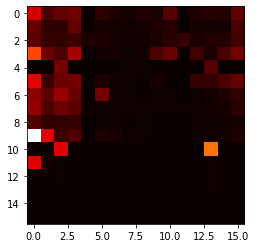

trained 0.5-500 2 times - ep num = 0
tensor([-34.6557, -34.7766, -34.5767, -34.6374], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-17.9949, -17.9251, -18.0908, -17.9383], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-8.5075, -8.4780, -8.4364, -8.3980], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([-3.1243, -2.8256, -3.2241, -2.0492], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([-14.6560,  -8.9207,  -6.5174,  -8.7848], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


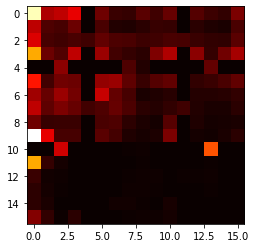

trained 0.5-500 2 times - ep num = 1
tensor([-2.9524, -2.8573, -3.1351, -2.6439], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([-0.7879,  0.8982,  1.3358, -1.1363], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([1.7633, 1.6703, 1.7751, 1.7072], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([2.3115, 1.8383, 2.0821, 2.7569], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([3.0966, 3.0876, 3.0357, 3.1209], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


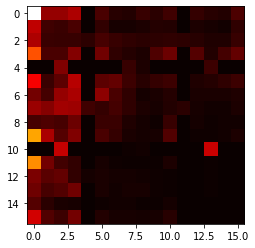

trained 0.5-500 2 times - ep num = 1
tensor([  7.3772, -19.4968,  -9.2480,  -7.4634], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([0.8539, 0.5947, 0.6321, 0.6312], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([1.8961, 1.7690, 1.7430, 1.7366], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([2.4628, 2.3404, 2.3900, 2.4761], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([2.6927, 3.0231, 2.7209, 2.9896], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-500 2 times - ep num = 1
tensor([3.1213, 3.2697, 3.2238, 3.0002], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([3.1786, 3.1023, 3.1470, 3.1294], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([3.1192, 3.1340, 3.0971, 3.1105], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([3.0804, 2.9893, 

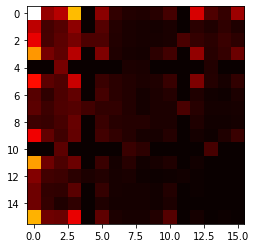

trained 0.5-500 2 times - ep num = 3
tensor([2.0984, 2.1447, 2.1171, 2.1067], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.1206, 2.0859, 2.0963, 2.1095], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.0884, 2.0881, 2.0903, 2.0875], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.0778, 2.0810, 2.0778, 2.0743], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.0650, 2.0644, 2.0626, 2.0620], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-500 2 times - ep num = 3
trained 0.5-1000 0 times - ep num = 0
tensor([ 9.5501,  8.7943,  9.1491, 10.2391], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([-4.0060, -6.4956, -5.4920, -3.0432], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([ 809.0309, -585.6706, 1406.6476, -224.9374], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.3

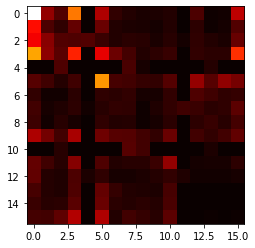

trained 0.5-1000 0 times - ep num = 2
tensor([-8.6651, -8.6712, -8.8278, -8.8476], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-1.7005, -1.7324, -1.7935, -1.8510], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([1.6463, 1.7510, 1.7917, 1.9980], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([4.1011, 4.0842, 4.0689, 4.0493], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([5.5779, 5.2624, 5.0262, 5.1355], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


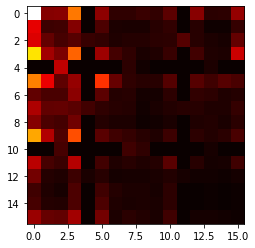

trained 0.5-1000 0 times - ep num = 4
tensor([6.3389, 6.4651, 6.5280, 6.2796], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([7.2462, 7.0062, 7.2617, 7.1787], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([6.6785, 6.8629, 6.6256, 6.7215], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([6.1798, 6.0289, 6.1615, 6.3634], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([5.9467, 6.0159, 5.8933, 5.8906], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


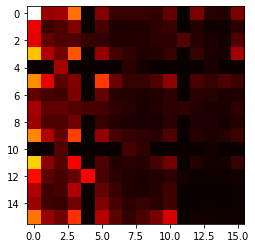

trained 0.5-1000 0 times - ep num = 5
tensor([5.5000, 5.4533, 5.6210, 5.7952], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([5.3414, 5.3778, 5.2947, 5.2440], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([5.4045, 5.9995, 5.2587, 4.1563], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([5.2600, 4.9131, 5.0719, 5.0851], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([4.9816, 5.0462, 5.0506, 4.9668], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-1000 0 times - ep num = 7
tensor([4.6292, 4.8117, 4.8171, 4.7026], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([4.6633, 4.6353, 4.6540, 4.6793], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([4.4177, 4.8326, 4.1116, 4.6812], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([4.4261, 4.4305, 4.4048

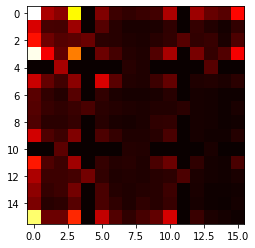

trained 0.5-1000 0 times - ep num = 21
tensor([2.9904, 2.9951, 2.9924, 2.9903], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.9620, 2.9431, 2.9574, 2.9642], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.9158, 2.8936, 2.9074, 2.9417], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.9101, 2.9032, 2.9033, 2.9190], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.9204, 2.9239, 2.9271, 2.9634], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-1000 0 times - ep num = 21
trained 0.5-1000 1 times - ep num = 0
tensor([9.9176, 9.1507, 9.7515, 9.6942], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([ 2435.7510,   606.6344, 16468.1055, 18801.3086], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([12969.9375, 12086.5039, 12888.8564, 13323.5869], device='cuda:0',
       grad_fn=<Slic

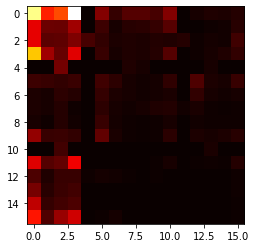

trained 0.5-1000 1 times - ep num = 2
tensor([2318.9102, 2339.4207, 2307.8433, 2331.8352], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([1368.1389, 1380.6404, 1376.1512, 1381.7062], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([768.3699, 775.3995, 744.9738, 752.3496], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([483.0216, 492.5643, 485.0823, 491.6639], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([283.9440, 283.6084, 283.4407, 282.1514], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


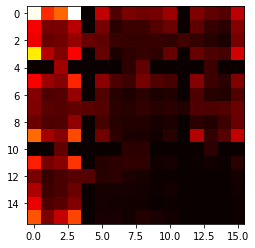

trained 0.5-1000 1 times - ep num = 4
tensor([166.7109, 166.1858, 165.2910, 165.8985], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([102.3806, 102.5126, 101.5818, 102.4920], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([61.2263, 61.5967, 61.6246, 60.9697], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([38.2026, 37.8382, 38.6636, 38.5668], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([24.2628, 24.9286, 23.6726, 24.3181], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


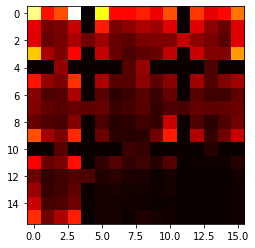

trained 0.5-1000 1 times - ep num = 4
tensor([16.4419, 15.7263, 15.9380, 16.3836], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([ 5.4733, 21.5601,  8.3536, 17.7838], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([23.4988, 27.8147, 26.7987, 29.7795], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([18.5295, 19.3277, 20.1182, 18.4400], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([ 9.5850, 11.5523, 12.1277, 10.6859], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-1000 1 times - ep num = 6
tensor([9.8745, 9.4937, 9.3720, 9.5993], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([7.7908, 7.6097, 7.5212, 7.5528], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([6.6623, 6.5504, 6.5500, 6.4181], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([5.

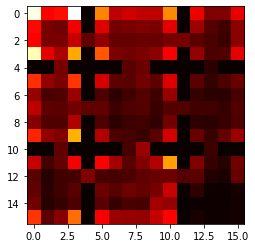

trained 0.5-1000 1 times - ep num = 22
tensor([2.8309, 2.8592, 2.8710, 2.8372], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.8272, 2.8624, 2.8078, 2.8338], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.7741, 2.7447, 2.7715, 2.7716], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.7973, 2.7961, 2.7833, 2.8311], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.8062, 2.7904, 2.8103, 2.8180], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-1000 1 times - ep num = 22
trained 0.5-1000 2 times - ep num = 0
tensor([9.3900, 7.6866, 8.1957, 9.0128], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([11.3031, 10.9121, 10.9670, 10.5104], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([-4613.5298, -4635.6450, -4730.8472, -4746.3975], device='cuda:0',
       grad_fn=<SliceBackward0>)

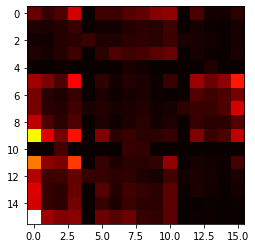

trained 0.5-1000 2 times - ep num = 1
tensor([-12184.3164, -12407.6357, -11929.7510, -12138.5332], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-7142.8159, -7123.5469, -7346.4141, -7143.7163], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-4409.7651, -4386.1548, -4367.3940, -4489.0298], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([-2770.7229, -2808.3533, -2817.4749, -2817.0449], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([-1591.7966, -1595.2859, -1583.5681, -1618.6061], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


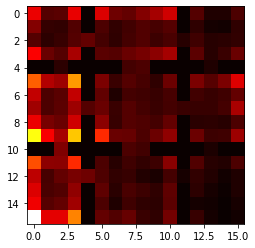

trained 0.5-1000 2 times - ep num = 5
tensor([-1107.7366,  -914.4894,  -918.7976, -1038.8300], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([-525.7443, -526.7798, -522.4248, -528.1104], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([-327.3680, -332.6950, -332.0988, -333.6786], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([-191.2142, -191.3198, -189.8226, -190.2652], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([-113.3563, -112.1388, -111.8483, -112.4788], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


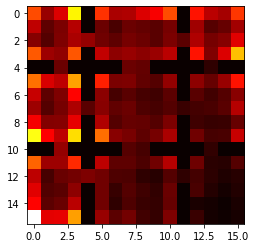

trained 0.5-1000 2 times - ep num = 8
tensor([-62.1534, -62.6787, -62.8778, -62.8288], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([-42.0615, -41.3673, -41.9340, -41.8614], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([-22.6231, -22.4699, -22.4208, -22.5826], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([-11.0194, -10.9224, -10.6782, -11.4714], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([-6.3552, -6.2425, -5.8869, -5.9651], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-1000 2 times - ep num = 10
tensor([-2.4843, -3.0099, -2.5097, -2.7599], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([ 0.8739,  0.4996,  0.6101, -0.0645], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([2.8764, 2.0604, 2.5932, 3.0339], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.0119

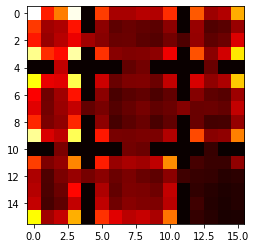

trained 0.5-1000 2 times - ep num = 30
tensor([2.9041, 2.9384, 2.9759, 2.9420], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.8136, 2.8211, 2.8566, 2.7992], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.8726, 2.8503, 2.8790, 2.9145], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.7752, 2.7703, 2.7545, 2.7668], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.7331, 2.7815, 2.7688, 2.7947], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-1000 2 times - ep num = 33
trained 0.5-5000 0 times - ep num = 0
tensor([20.8787, 23.9810, 22.2468, 22.8314], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([ -7228.0415, -29836.2617, -95106.5078,   7244.8799], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([7378.3096, 7628.0317, 7704.4453, 7476.1743], device='cuda:0',
       grad_fn=<

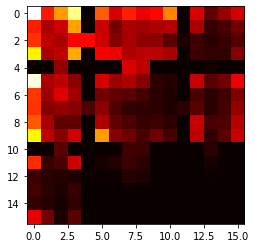

trained 0.5-5000 0 times - ep num = 0
tensor([1589.4314, 1577.8705, 1562.5172, 1569.9034], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([972.8414, 907.9359, 976.0884, 973.2646], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([557.8810, 562.5881, 562.4939, 565.0488], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([355.5735, 354.9948, 353.3057, 356.8709], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([51.6115, 51.3027, 51.7091, 51.1384], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


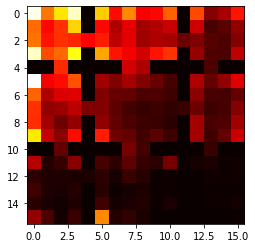

trained 0.5-5000 0 times - ep num = 1
tensor([35.2799, 35.3177, 35.3366, 35.2802], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([25.5686, 25.7923, 25.6646, 25.4710], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([19.7886, 19.6918, 19.7406, 19.6961], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([16.7176, 16.7745, 16.6453, 16.7602], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([211.2047, -44.7998, 130.4192,   3.9598], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


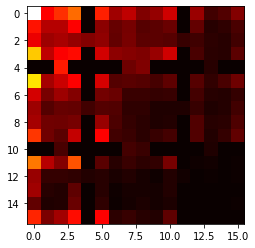

trained 0.5-5000 0 times - ep num = 1
tensor([14.9918, 14.9558, 15.1043, 14.9805], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([12.8820, 12.8576, 13.2256, 13.2362], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([11.8675, 11.5554, 11.7540, 12.1259], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([10.8393, 10.8390, 10.9144, 10.8234], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([10.4745, 10.4185, 10.6821, 10.4418], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-5000 0 times - ep num = 7
tensor([11.0487, 11.4113,  9.8057,  9.6155], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([10.7128, 10.8229, 10.7780, 10.8383], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([10.1731, 10.1969, 10.1910, 10.1924], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.01190159851363867

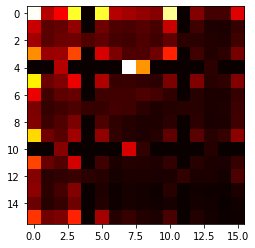

trained 0.5-5000 0 times - ep num = 16
tensor([6.4139, 6.4263, 6.3555, 6.3973], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([6.3787, 6.3755, 6.2845, 6.2966], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([6.2006, 6.2129, 6.0598, 6.1917], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([6.2574, 6.2416, 6.2543, 6.2481], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([6.3044, 6.2415, 6.2168, 6.2519], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-5000 0 times - ep num = 16
trained 0.5-5000 1 times - ep num = 0
tensor([8.8584, 8.7485, 9.4899, 9.0965], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([-485.6916, -230.3716,  480.3273, -521.0001], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([1.2611, 1.6520, 1.4460, 0.5924], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706

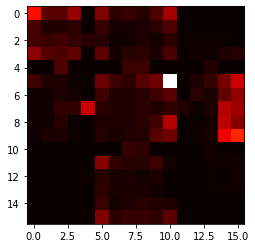

trained 0.5-5000 1 times - ep num = 1
tensor([  56.0276, -167.2516,  -56.2994,  170.6579], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([38.1941, 37.8395, 37.5652, 38.1671], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([28.2937, 28.5997, 28.6671, 28.2971], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([22.8605, 23.3785, 22.5361, 22.7368], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([19.9644, 19.4901, 19.5381, 19.4973], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


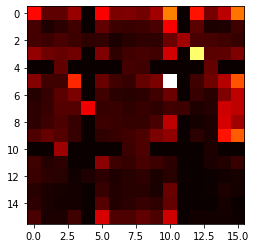

trained 0.5-5000 1 times - ep num = 2
tensor([23.2503, 14.9959,  6.8343, 11.1296], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([13.2324, 13.2733, 13.3170, 13.4000], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([12.8135, 12.5527, 12.5827, 12.4470], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([11.9177, 11.1819, 11.6746, 12.1659], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([14.9143, 15.0420, 15.0103, 15.0347], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


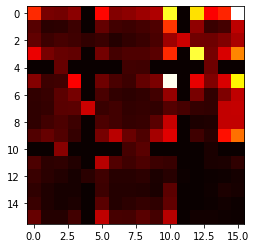

trained 0.5-5000 1 times - ep num = 3
tensor([13.2089, 13.2852, 13.3658, 13.4071], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([12.1391, 12.0398, 12.0321, 11.9871], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([11.6077, 11.4460, 11.4124, 11.6796], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([10.3132, 11.0093, 10.7201, 11.0191], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([12.2918, 11.0391,  9.6534,  9.4626], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-5000 1 times - ep num = 4
tensor([10.0987, 10.1745, 10.1335, 10.1787], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([9.7087, 9.7192, 9.6824, 9.7431], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([9.6816, 9.5304, 9.4576, 9.2569], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor

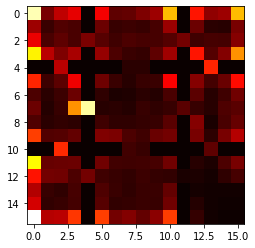

trained 0.5-5000 1 times - ep num = 8
tensor([6.4335, 6.5188, 6.5155, 6.5677], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([6.4524, 6.4019, 6.3679, 6.4044], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([6.4440, 6.4423, 6.4128, 6.3537], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([6.1861, 6.1962, 6.2000, 6.2309], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([6.2449, 6.2596, 6.2386, 6.2835], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-5000 1 times - ep num = 8
trained 0.5-5000 2 times - ep num = 0
tensor([ 2852.9470,  -137.9668, -1268.2494, -2465.4648], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([60.4189, 60.0526, 60.3536, 60.2986], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([46.5265, 45.1590, 44.3305, 46.1060], device='cuda:0',
       grad_fn=<SliceBackward0

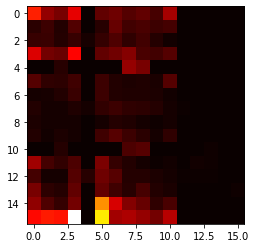

trained 0.5-5000 2 times - ep num = 1
tensor([15.4403, 23.5930, 19.6096, 27.2548], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-54.2128, -31.6494, -21.4963, -47.3290], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-327.8026, -282.6772, -333.3897, -300.6566], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([-180.1461, -190.0474, -168.1006, -196.9797], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([-83.4225, -80.4061, -80.5067, -80.7224], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


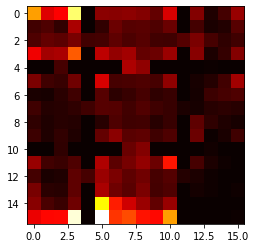

trained 0.5-5000 2 times - ep num = 2
tensor([-36.9249, -37.3226, -37.1354, -37.1160], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([-17.4623, -17.4873, -17.5406, -17.4949], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([-5.3420, -5.3227, -5.5735, -5.5811], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([1.4735, 1.3697, 1.2935, 1.4835], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([4.9486, 5.8592, 5.1670, 5.9517], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


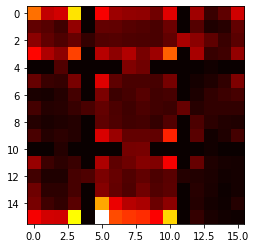

trained 0.5-5000 2 times - ep num = 5
tensor([7.0987, 6.9194, 6.9277, 7.0891], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([8.6033, 8.5509, 8.6141, 8.4808], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([11.4793, 16.4360,  4.0323, 16.4945], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([7.7774, 7.7408, 7.8496, 7.7345], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([8.6582, 8.6912, 8.8004, 8.8654], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 0.5-5000 2 times - ep num = 6
tensor([8.9521, 9.0126, 8.8429, 8.8501], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([9.1757, 8.9112, 9.1296, 8.8417], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([10.8693, 10.5012, 10.5016, 10.4952], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([9.8184, 9.6746

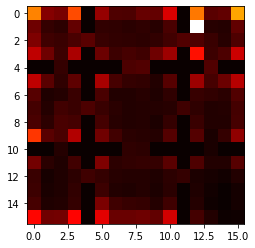

trained 0.5-5000 2 times - ep num = 21
tensor([6.5027, 6.5287, 6.5087, 6.5191], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([6.3894, 6.0939, 6.3368, 6.2182], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([6.0748, 6.0541, 6.0804, 6.0835], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([6.1091, 6.0472, 6.1720, 6.0280], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([5.9696, 6.0912, 5.9864, 6.0571], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 0.5-5000 2 times - ep num = 21
trained 1-500 0 times - ep num = 0
tensor([-60.1545, -59.3063, -60.1119, -60.2025], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([-29.5205, -29.1227, -29.1305, -28.6828], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([16711.3086, 17687.0645, 17256.4043, 15380.1016], device='cuda:0',
       grad_fn=<SliceBa

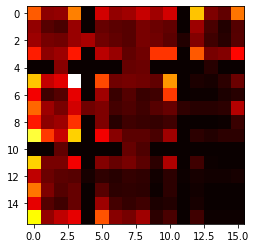

trained 1-500 0 times - ep num = 1
tensor([3574.4514, 3524.3018, 3552.0989, 3501.4009], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([2068.4353, 2066.4575, 2060.7915, 2068.2644], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([1244.1613, 1265.2485, 1263.0012, 1288.4012], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([743.0314, 743.6429, 715.7723, 743.4093], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([437.8521, 437.6874, 436.1435, 431.5799], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


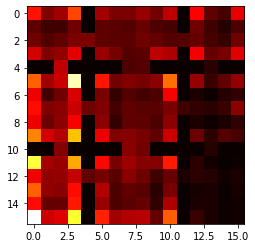

trained 1-500 0 times - ep num = 4
tensor([278.5716, 279.4117, 273.3362, 266.3338], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([164.5064, 163.9663, 161.1549, 165.6592], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([101.9337,  99.8518, 101.1129, 101.4679], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([60.9957, 61.3721, 61.6268, 62.2165], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([39.7035, 39.6995, 39.0672, 39.5152], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


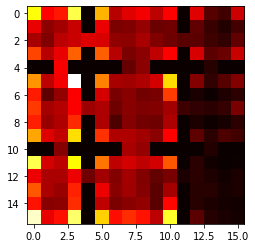

trained 1-500 0 times - ep num = 5
tensor([25.0001, 25.4371, 24.7808, 25.1683], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([16.3361, 16.4947, 16.3613, 16.3421], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([11.5052, 11.3741, 11.3580, 11.4394], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([10.9894, 11.3913, 11.0259, 11.1341], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([9.4335, 9.4417, 9.4066, 9.2596], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-500 0 times - ep num = 6
tensor([7.5524, 7.5216, 7.4662, 7.5442], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([6.2415, 6.2024, 6.2727, 6.2427], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([5.3457, 5.4113, 5.4809, 5.3285], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([5.1024, 4.93

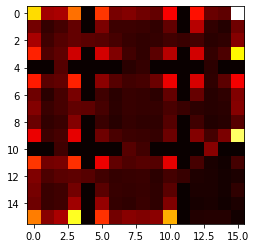

trained 1-500 0 times - ep num = 20
tensor([3.0511, 3.0418, 3.0363, 3.0414], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([3.0233, 3.0234, 3.0177, 3.0166], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.9264, 2.9329, 2.9091, 2.9196], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.8328, 2.8635, 2.8504, 2.8362], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.7456, 2.7494, 2.7841, 2.7325], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-500 0 times - ep num = 20
trained 1-500 1 times - ep num = 0
tensor([6.8680, 6.9124, 6.7865, 7.0411], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([ 9.9496,  9.3830,  9.6657, 10.0187], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([68405.5156, 69790.5625, 71252.4297, 66992.3047], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.307062

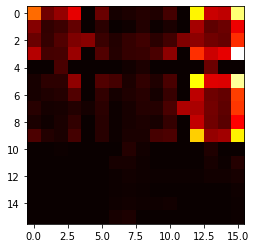

trained 1-500 1 times - ep num = 1
tensor([14044.2598, 14044.9082, 14234.7520, 14201.9023], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([8791.0879, 8859.0186, 8857.0156, 8879.9932], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([5104.5825, 5129.2500, 5135.8970, 5138.6626], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([3023.7822, 3023.5786, 3018.6697, 3004.5117], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([1809.8602, 1801.4423, 1799.3846, 1801.0392], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


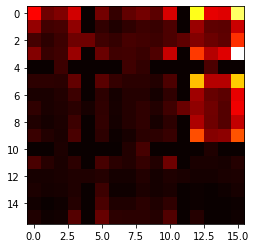

trained 1-500 1 times - ep num = 4
tensor([1041.3458, 1034.8737, 1031.5723, 1032.6204], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([616.3441, 620.2775, 615.8495, 615.8905], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([382.6240, 383.6382, 381.6910, 381.0377], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([285.8661, 298.8166, 283.2756, 267.0114], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([152.6886, 150.5659, 152.5915, 151.0986], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


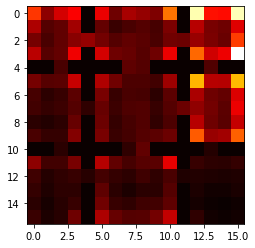

trained 1-500 1 times - ep num = 6
tensor([91.1513, 90.9144, 91.1552, 90.9038], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([56.8550, 57.4015, 56.7508, 56.8590], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([35.2320, 34.9779, 35.8736, 35.4549], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([  23.9755,   59.5096,   47.0312, -119.7655], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([-0.9749, -1.1615,  0.0308, -1.2591], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-500 1 times - ep num = 7
tensor([2.5341, 1.7111, 1.4246, 1.9032], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([3.7924, 3.4104, 2.8649, 3.2957], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([5.6106, 6.2405, 5.8992, 5.6242], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([

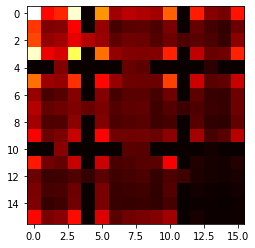

trained 1-500 1 times - ep num = 13
tensor([2.8875, 2.9654, 2.8700, 2.8090], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.8429, 2.8618, 2.8909, 2.8863], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([2.8714, 2.7948, 2.8073, 2.8410], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.8319, 2.8291, 2.7791, 2.8484], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.7687, 2.7528, 2.7582, 2.7483], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-500 1 times - ep num = 15
trained 1-500 2 times - ep num = 0
tensor([ 3468.8574,  7167.4429,  4522.1772, -6493.0513], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([1725.2383, 1620.4757, 1450.4680, 1552.8126], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([-49.3876, -50.3461, -49.9129, -68.8875], device='cuda:0',
       grad_fn=<SliceBack

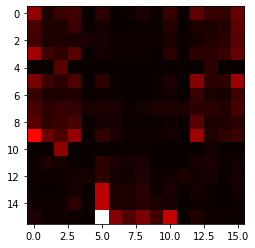

trained 1-500 2 times - ep num = 3
tensor([13.6210, 13.6599, 13.5963, 13.5236], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([10.9597, 11.2824, 11.0420, 11.2971], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([9.5025, 9.3902, 9.5704, 9.6724], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([8.4907, 8.5107, 8.5037, 8.4309], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([7.8250, 7.7045, 7.6518, 7.7933], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


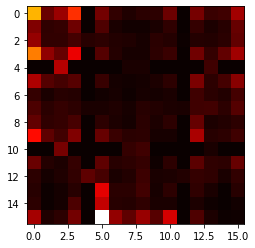

trained 1-500 2 times - ep num = 5
tensor([7.4930, 7.5169, 7.2518, 7.4191], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([28.6472, 28.6545, 28.4822, 28.6839], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([19.2400, 19.1530, 19.0757, 19.1892], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([13.7239, 13.6459, 13.7000, 13.6254], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([10.2321, 10.2910, 10.2306, 10.2610], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


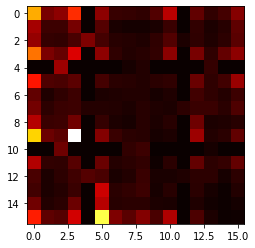

trained 1-500 2 times - ep num = 7
tensor([8.2295, 8.2607, 8.2675, 8.3629], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([7.0398, 7.0418, 7.0462, 7.2518], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([3.4495, 3.6578, 3.5728, 3.7512], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([4.1606, 4.2174, 4.1382, 4.1914], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([4.3598, 4.3277, 4.3545, 4.3032], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-500 2 times - ep num = 10
tensor([4.5747, 4.4575, 4.4317, 4.5027], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([4.3944, 4.3748, 4.3765, 4.3567], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([4.5823, 4.6028, 4.5741, 4.5789], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([4.4698, 4.4595, 4.4620, 4.4

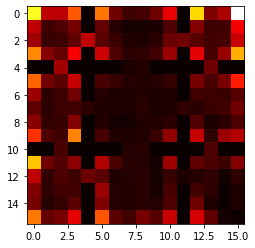

trained 1-500 2 times - ep num = 20
tensor([3.0230, 3.0242, 3.0401, 3.0330], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([2.9951, 3.0169, 2.9935, 3.0054], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([3.0044, 2.9786, 2.9936, 2.9814], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([2.9763, 2.9730, 2.9713, 2.9691], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([2.9019, 2.9128, 2.9303, 2.8808], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-500 2 times - ep num = 22
trained 1-1000 0 times - ep num = 0
tensor([3713.9253, 4641.0791, 3789.6057, 3789.7781], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([2123.0708, 1842.5651, 1951.1791, 1952.9904], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([1134.0566, 1145.0925, 1288.4917, 1234.1760], device='cuda:0',
       grad_fn=<SliceBac

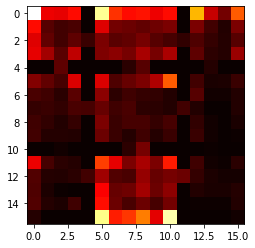

trained 1-1000 0 times - ep num = 2
tensor([ 494.5561,  279.4957,   37.8473, 1671.3768], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([104.5958, 104.2552, 104.4244, 104.7056], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([63.3049, 67.9120, 65.4477, 64.1744], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([ 10.8385, 111.0418,  92.7935,  24.4048], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([34.1779, 31.1032, 31.8904, 27.4955], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


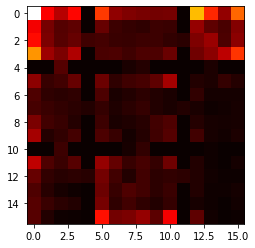

trained 1-1000 0 times - ep num = 2
tensor([24.5525, 24.0142, 23.8493, 24.3953], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([17.6016, 17.5980, 17.7195, 17.7187], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([14.0330, 13.3197, 13.4777, 13.8353], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([11.1495, 11.2912, 11.2304, 11.0690], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([ 51.0059, -11.5414,  -9.1428,  -6.8827], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


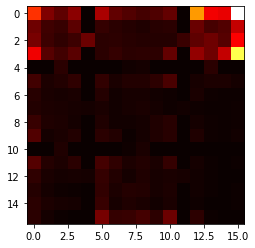

trained 1-1000 0 times - ep num = 2
tensor([8.2816, 8.2993, 8.2981, 8.1941], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([7.6158, 7.4775, 7.5796, 7.7061], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([6.9094, 7.3419, 7.2305, 7.5297], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([8.3025, 8.4703, 8.3841, 8.4116], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([7.6993, 7.5812, 7.6090, 7.5797], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-1000 0 times - ep num = 2
tensor([6.9417, 6.9848, 7.1151, 7.0824], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([6.5449, 6.2612, 6.9191, 6.7153], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([6.0606, 6.1383, 7.1921, 6.8194], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([6.0891, 6.4608, 6.4241, 6.

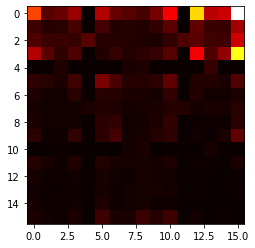

trained 1-1000 0 times - ep num = 6
tensor([4.3089, 4.3204, 4.3057, 4.3068], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([4.1928, 4.1715, 4.1649, 4.1845], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([4.2045, 4.2675, 4.1203, 4.1747], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([4.1617, 4.1602, 4.1596, 4.1572], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([4.1149, 4.1173, 4.1233, 4.1098], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-1000 0 times - ep num = 6
trained 1-1000 1 times - ep num = 0
tensor([10.8256, 11.2196, 11.3633, 11.7505], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([14.7112, 14.6373, 13.6799, 14.8360], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([15.0738, 15.9658, 15.7121, 15.8458], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.3070624999999

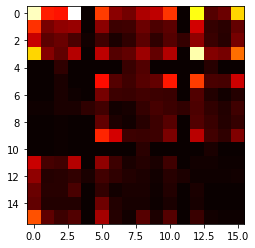

trained 1-1000 1 times - ep num = 1
tensor([-346.1263, -434.6422, -613.7234, -556.8942], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([-75.2067, -71.9606, -79.3407, -60.4529], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-20.3518, -21.4003, -19.5908, -22.1296], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([15.2886,  8.1191,  2.1050, 26.6884], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([-20.3119, -12.2096, -10.1153, -19.7699], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


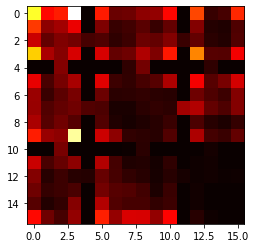

trained 1-1000 1 times - ep num = 1
tensor([4.6016, 4.3973, 4.3601, 4.8074], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([6.1283, 6.1389, 5.9969, 6.2054], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([6.7562, 6.8721, 6.9144, 6.8861], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([7.3179, 7.1880, 7.3737, 7.0623], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([7.5417, 7.1498, 7.3953, 7.3033], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


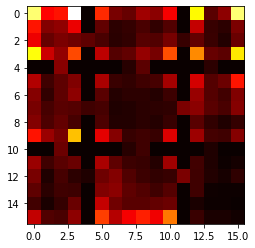

trained 1-1000 1 times - ep num = 6
tensor([7.3335, 7.3889, 7.4268, 7.3372], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([-1.0759,  0.1923,  0.1688, -0.6321], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([2.0994, 2.1571, 2.1424, 2.1673], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([4.0209, 4.0122, 4.0353, 3.9801], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([5.0513, 5.0141, 4.8551, 5.1690], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-1000 1 times - ep num = 11
tensor([5.6206, 5.5733, 5.5255, 5.6338], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([5.8560, 5.7973, 5.7788, 5.8608], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([5.8829, 5.9288, 5.9474, 5.8847], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([6.0023, 6.0098, 6.000

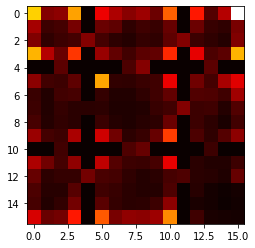

trained 1-1000 1 times - ep num = 31
tensor([4.2321, 4.2372, 4.2999, 4.2620], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([4.2001, 4.2228, 4.1699, 4.1865], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([4.2073, 4.2199, 4.2214, 4.2166], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([4.1069, 4.0933, 4.0711, 4.0963], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([4.0108, 4.0384, 3.9834, 4.0249], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-1000 1 times - ep num = 31
trained 1-1000 2 times - ep num = 0
tensor([17.4439, 15.9477, 21.8381, 14.9043], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([57.4624, 61.9266, 62.1393, 58.0193], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([42.1120, 45.0643, 41.3631, 41.2542], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999

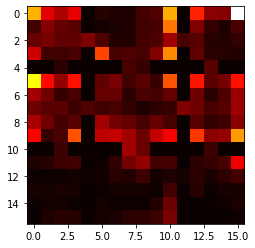

trained 1-1000 2 times - ep num = 2
tensor([34.1461, 34.0966, 33.9613, 34.4991], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([24.2777, 24.4510, 25.1124, 24.2048], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([19.2438, 18.7320, 18.7558, 18.9669], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([ -4.7802,  -4.7129, -10.1728,  -6.7958], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([-30.1912, -29.9947, -29.7776, -29.7538], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


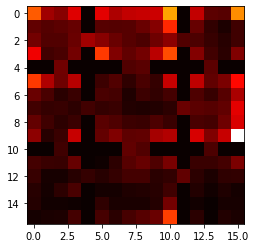

trained 1-1000 2 times - ep num = 9
tensor([-14.3930, -13.9573, -13.6955, -14.1484], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([-5.0059, -4.7565, -5.0143, -4.7811], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([0.2666, 0.3572, 0.3500, 0.4192], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([2.9962, 3.5526, 3.6925, 3.3121], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([4.2645, 4.7805, 6.3535, 5.1822], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


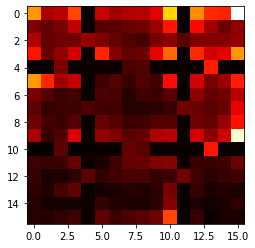

trained 1-1000 2 times - ep num = 11
tensor([5.0804, 5.1008, 5.1902, 5.1364], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([5.9385, 5.8775, 5.9457, 5.9657], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([8.5051, 8.5633, 8.5136, 8.5592], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([7.6421, 7.4504, 7.8220, 7.7202], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([7.1913, 7.2675, 7.0944, 7.0835], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-1000 2 times - ep num = 11
tensor([6.8500, 6.8050, 6.9578, 6.8852], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([12.0548, 11.9927, 12.9394, 12.7261], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([10.0955, 10.0614,  9.8887,  9.9518], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
tensor([8.2195, 8.4576, 

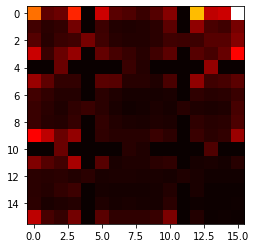

trained 1-1000 2 times - ep num = 15
tensor([4.1923, 4.2168, 4.2137, 4.2387], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([4.0199, 4.0563, 4.0949, 4.1495], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([4.0166, 3.9628, 4.0514, 4.0263], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([4.0253, 4.0017, 4.0411, 4.0266], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([3.9370, 3.9437, 3.9548, 3.9594], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-1000 2 times - ep num = 15
trained 1-5000 0 times - ep num = 0
tensor([-173.3433, -109.3393, -157.7837,   85.2975], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([39.0146, 44.8844, 49.6311, 42.0878], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([36.6459, 28.6050, 35.4156, 35.0482], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.307

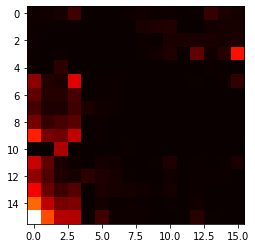

trained 1-5000 0 times - ep num = 0
tensor([23.6807, 23.6325, 24.1945, 23.9661], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([20.9939, 22.6642, 21.6137, 21.0670], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([-33.5373, -65.2770, -35.8762, -56.3412], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([-18.0400, -18.6362, -19.4070, -17.5394], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([-2.6446, -2.6594, -2.9922, -2.8630], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


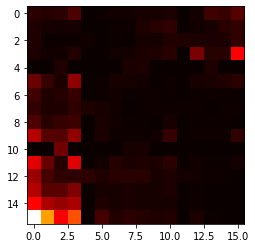

trained 1-5000 0 times - ep num = 1
tensor([5.1956, 5.1680, 5.1905, 5.2913], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([9.7191, 9.9209, 9.8139, 9.4583], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([12.4608, 12.3199, 13.6741, 12.7685], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([14.8968, 13.9478, 15.1906, 14.0002], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([15.8077, 16.2820, 15.9234, 15.8824], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


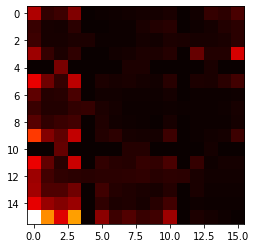

trained 1-5000 0 times - ep num = 4
tensor([15.5445, 15.2734, 15.3659, 15.3452], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([14.9575, 14.8355, 13.7373, 14.4000], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([14.7509, 14.6216, 14.7623, 14.7913], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([14.3861, 14.3721, 14.4182, 14.4989], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([14.2127, 14.4340, 14.4746, 14.6255], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-5000 0 times - ep num = 5
tensor([13.3158, 13.1483, 13.1844, 13.2089], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([13.0756, 12.9151, 13.1577, 12.6688], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([13.0617, 13.1483, 12.9707, 13.1220], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
te

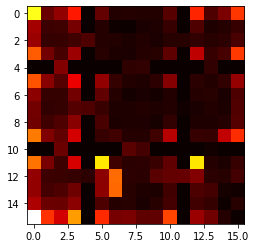

trained 1-5000 0 times - ep num = 10
tensor([8.9363, 9.0840, 8.9284, 8.9462], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([9.0806, 9.1605, 9.0194, 9.0484], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([8.8249, 8.7684, 8.7679, 8.7536], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([8.3426, 8.6164, 8.3129, 8.3647], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([8.4758, 8.4678, 8.3888, 8.4099], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-5000 0 times - ep num = 10
trained 1-5000 1 times - ep num = 0
tensor([12.0108, 10.4142, 10.9474, 11.3732], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([50.6315, 49.7978, 55.4587, 51.9565], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([40.0065, 41.0365, 43.4443, 40.7644], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999

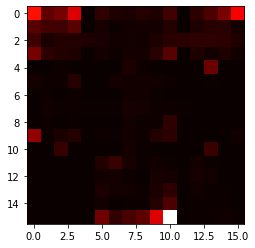

trained 1-5000 1 times - ep num = 3
tensor([10.3318,  9.8395, 11.4141, 11.6453], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([14.5476, 13.9143, 14.9722, 14.8157], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([17.7288, 17.7916, 17.4866, 17.4193], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([16.8628, 17.1602, 17.5257, 18.0474], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([26.8105, 26.2636, 26.3799, 27.8517], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


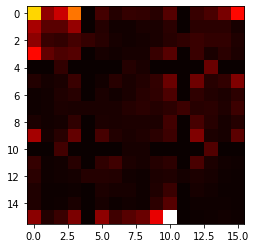

trained 1-5000 1 times - ep num = 6
tensor([22.1040, 22.0536, 21.8791, 22.1849], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([19.7963, 21.0109, 19.7389, 19.8781], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([18.6351, 18.5859, 18.4739, 18.6009], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([17.9261, 17.9007, 17.9371, 17.9164], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([17.0454, 17.2910, 17.1466, 16.8899], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


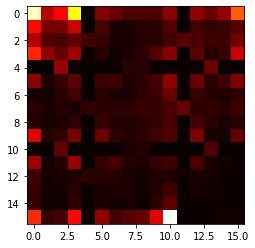

trained 1-5000 1 times - ep num = 6
tensor([16.2511, 16.0556, 16.1112, 16.2189], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([16.1112, 15.3801, 15.5618, 16.1142], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([14.7491, 14.7931, 14.8152, 14.7313], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([14.1680, 14.7975, 13.6190, 15.2236], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([13.3759, 13.2332, 13.5335, 13.1701], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-5000 1 times - ep num = 6
tensor([13.6520, 13.6063, 13.5347, 13.5991], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([13.2808, 12.7717, 13.2496, 12.9448], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([12.9037, 13.4825, 13.0897, 13.2536], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
te

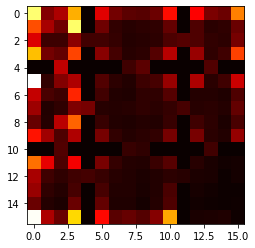

trained 1-5000 1 times - ep num = 14
tensor([9.1783, 9.2468, 9.0865, 9.0798], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([8.6555, 8.6507, 8.6085, 8.7248], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([8.7661, 8.6260, 8.6413, 8.5478], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([8.4012, 8.3810, 8.4438, 8.4658], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([8.5247, 8.5949, 8.4692, 8.4554], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-5000 1 times - ep num = 14
trained 1-5000 2 times - ep num = 0
tensor([12.4268, 13.0841, 12.8854, 13.1647], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([18.9842, 19.1886, 18.8844, 19.7774], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([23.4574, 22.5015, 24.1759, 23.0781], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999

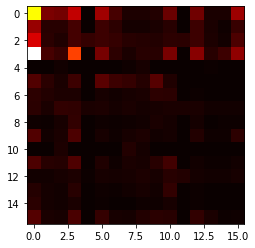

trained 1-5000 2 times - ep num = 4
tensor([4.9140, 5.4491, 5.2505, 5.0660], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([10.9202, 10.9155, 10.7803, 11.2265], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([685.3203, 789.9965, 184.5865, 266.5396], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([108.2034, 111.0424, 113.8237, 112.2249], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([74.5189, 79.7558, 80.5319, 78.9122], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


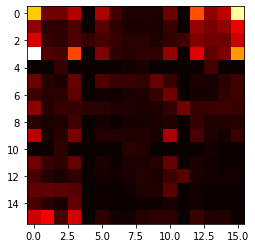

trained 1-5000 2 times - ep num = 6
tensor([48.1187, 47.9989, 47.9276, 47.9868], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709
tensor([36.2928, 36.4857, 36.7271, 36.8086], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.07112087856808602
tensor([24.2999, 28.1971, 25.8753, 27.0692], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.060452746782873115
tensor([21.9895, 21.7458, 22.0274, 21.7781], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.051384834765442144
tensor([19.9144, 19.8815, 21.0777, 19.8299], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.04367710955062582


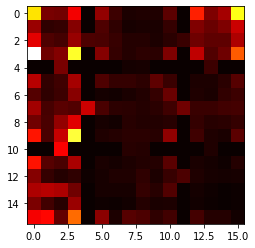

trained 1-5000 2 times - ep num = 9
tensor([17.9274, 17.7852, 17.5988, 17.3284], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.03712554311803195
tensor([16.3423, 16.7448, 16.3167, 15.2373], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.031556711650327154
tensor([13.6376, 70.6030,  3.9919,  9.6118], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.02682320490277808
tensor([22.5361, 24.9795, 24.3399, 23.4137], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.022799724167361368
tensor([18.4209, 18.4354, 18.6438, 18.2751], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.019379765542257163
trained 1-5000 2 times - ep num = 13
tensor([16.2090, 16.2695, 16.3849, 16.1404], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.016472800710918587
tensor([14.9283, 14.8964, 14.8889, 14.8949], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.014001880604280799
tensor([14.0204, 14.0070, 14.0767, 13.8929], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.011901598513638678
t

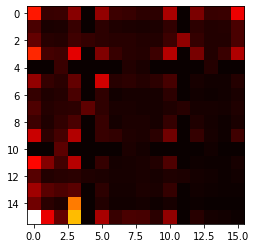

trained 1-5000 2 times - ep num = 16
tensor([9.1661, 9.0316, 9.0805, 9.1325], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00012569998207789698
tensor([9.0921, 9.0977, 9.0616, 8.9953], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.00010684498476621243
tensor([8.7256, 8.8148, 8.8070, 8.8512], device='cuda:0',
       grad_fn=<SliceBackward0>)
9.081823705128057e-05
tensor([8.8683, 8.7281, 8.6124, 8.6720], device='cuda:0',
       grad_fn=<SliceBackward0>)
7.719550149358847e-05
tensor([8.6681, 8.8960, 8.4471, 8.7283], device='cuda:0',
       grad_fn=<SliceBackward0>)
6.56161762695502e-05
trained 1-5000 2 times - ep num = 16


In [14]:
for sigma in [0.1, 0.5, 1]:
  for rate in [500, 1000, 5000]:
    avg_returns = []
    episodes = []
    current_coverage = []
    coverage_steps = [5000, 10000, 15000, 50000]
    prefix = f"{sigma}_{rate}_"

    # Noise defined
    for k in range(3):
        torch.cuda.empty_cache()
        current_return = []

        replay_buffer = deque(maxlen=BUFFER_SIZE)
        rew_buffer = []
        temp_episodes = []

        rat_cell = (0, 0)
        env = Qmaze(maze)
        env.reset(rat_cell)
        obs = env.observe()

        agent = DQNAgent(env, EPSILON_START, EPSILON_END, EPSILON_DECAY, GAMMA, 0.5)
        cnt = 0
        coverage_counter = 0
        episode = 0
        for step in itertools.count():
            agent.counter += 1
            action = agent.choose_action(step, obs)

            new_obs, rew, done = env.act(action)
            Transition = (obs, action, rew, done, new_obs)
            replay_buffer.append(Transition)
            obs = new_obs

            if done != 'not_over':
                rat_cell = (0,0)
                env.reset(rat_cell)
                obs = env.observe()
                rew_buffer.append(GAMMA**(cnt))
                episode += 1
                cnt = 0

            if len(replay_buffer) > BATCH_SIZE:
                transitions = random.sample(replay_buffer, BATCH_SIZE)
                obses = np.asarray([t[0] for t in transitions])
                actions = np.asarray([t[1] for t in transitions])
                rews = np.asarray([t[2] for t in transitions])
                dones = np.asarray([t[3] for t in transitions])
                new_obses = np.asarray([t[4] for t in transitions])

                converted_dones = [done != 'not_over' for done in dones]

                obses_t = torch.as_tensor(obses, dtype=torch.float32).to(device)
                actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1).to(device)
                rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1).to(device)
                dones_t = torch.as_tensor(converted_dones, dtype=torch.float32).unsqueeze(-1).to(device)
                new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32).to(device)

                # Calculate noise
                var = sigma / np.ceil (agent.counter / rate)

                agent.calculate_target(new_obses_t, rews_t, dones_t, var)
                agent.calculate_action_qvalues(obses_t, actions_t)
                agent.optimize_network()

            if step % TARGET_UPDATE_FREQ == 0:
                agent.update_target_network()

            if step in coverage_steps:
                if k == 0:
                    current_coverage.append(np.copy(env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])))
                else:
                    current_coverage[coverage_counter] = np.concatenate(
                        [current_coverage[coverage_counter], env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])], axis=0)

                coverage_counter += 1

                plt.imshow(env.coverage, cmap='hot', interpolation='nearest')
                plt.show()

            if step > 55000:
                episodes.append(np.copy(temp_episodes))
                avg_returns.append(np.copy(rew_buffer))
                break
            cnt += 1

            if step % 5000 == 0:
                temp_episodes.append(episode)
                print(f"trained {sigma}-{rate} {k} times - ep num = {episode}")

    min_length = np.min([len(array) for array in avg_returns])
    np.save(prefix+"episodes.npy", np.mean(episodes, axis=0))
    np.save(prefix+"score.npy", np.mean([array[:min_length] for array in avg_returns], axis=0))
    for s in range(len(coverage_steps)):
        np.save(prefix+f"heat_{coverage_steps[s]}.npy", np.mean(current_coverage[s], axis=0))

In [34]:
plt.imshow(np.mean(current_coverage[1], axis=0)[0:][:], cmap='hot', interpolation='nearest')

IndexError: ignored

<ipython-input-174-4ba5ae3ef7bf>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


KeyboardInterrupt: ignored

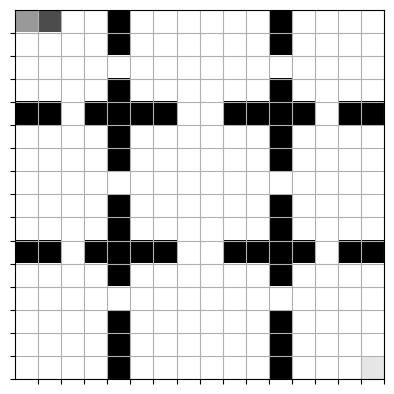

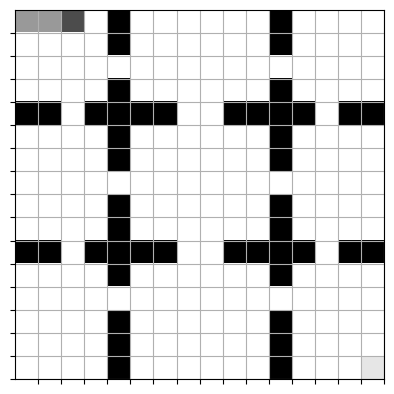

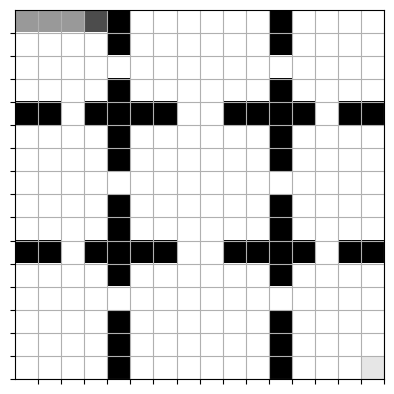

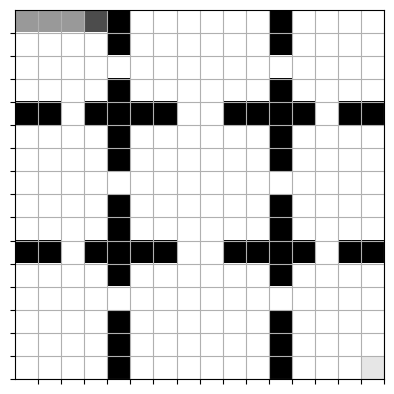

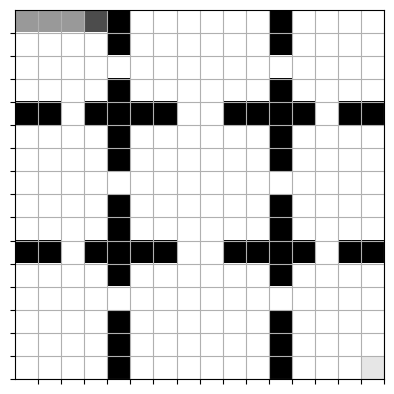

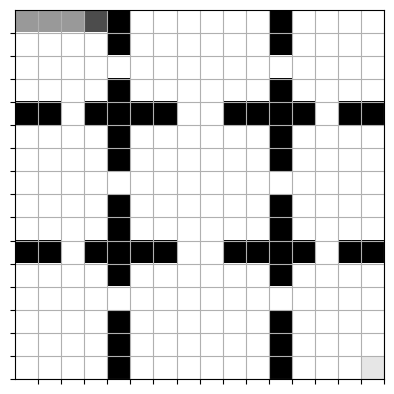

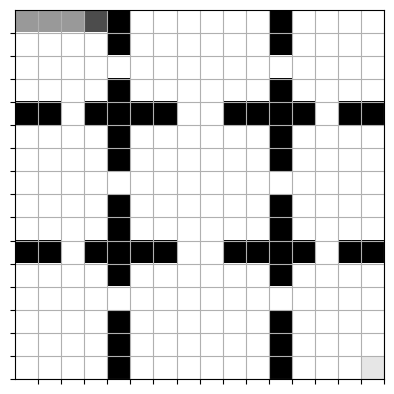

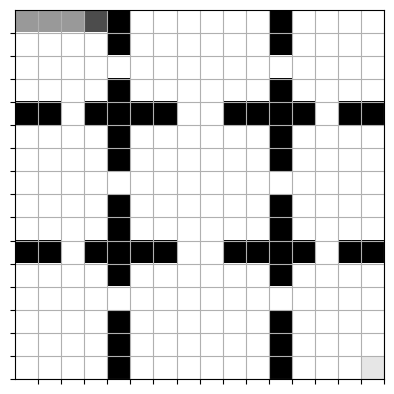

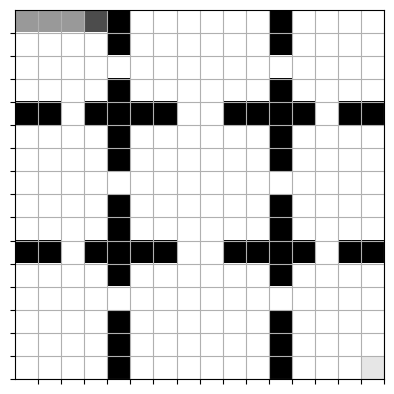

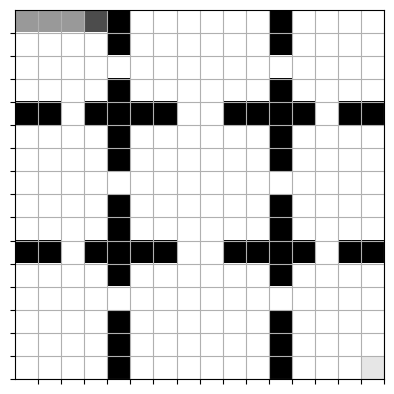

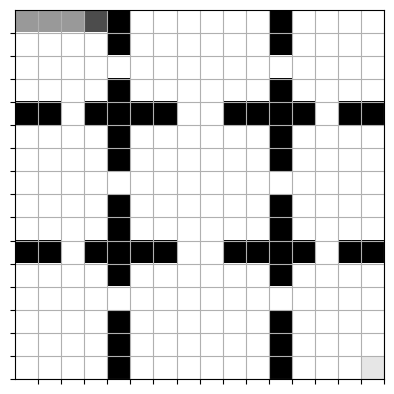

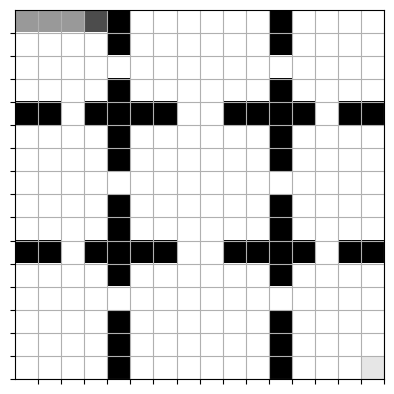

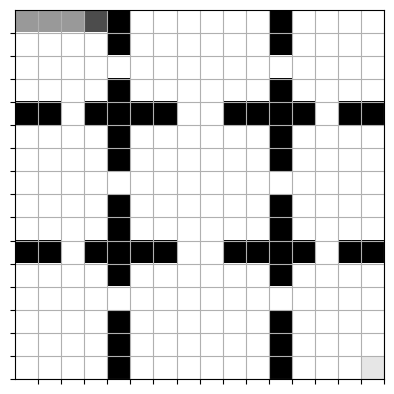

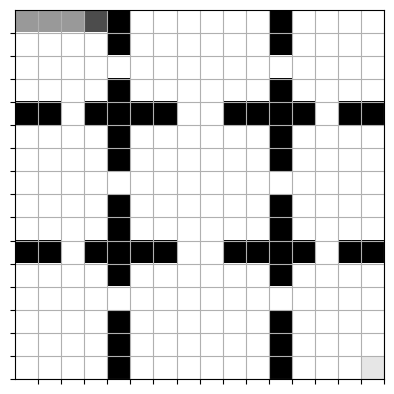

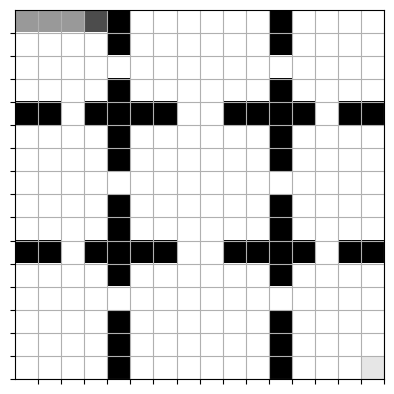

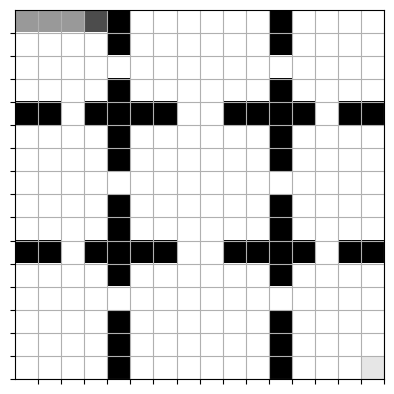

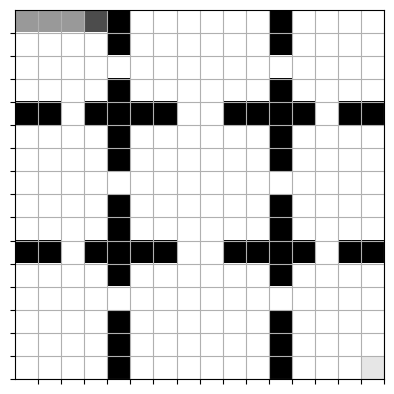

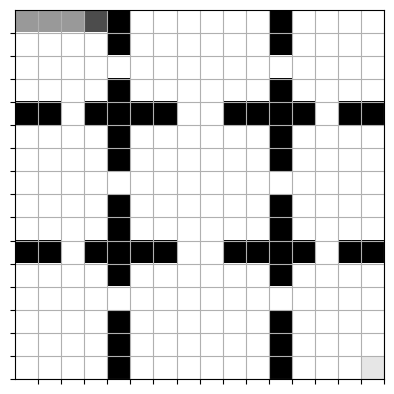

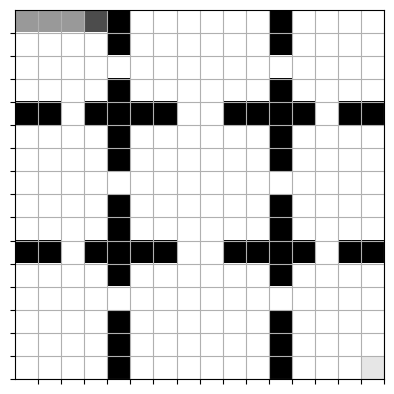

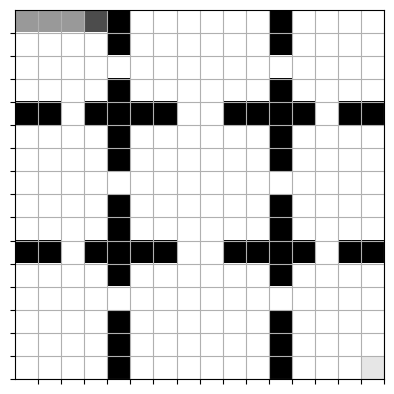

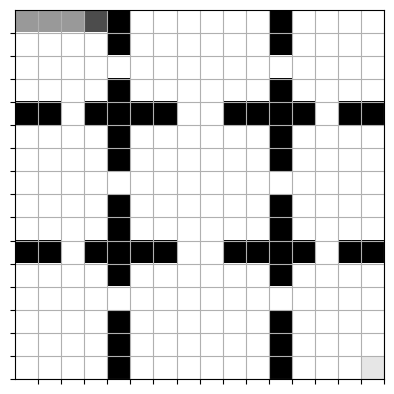

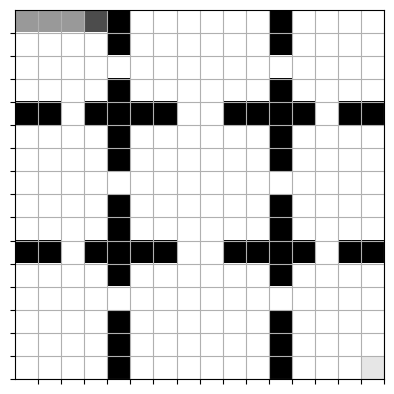

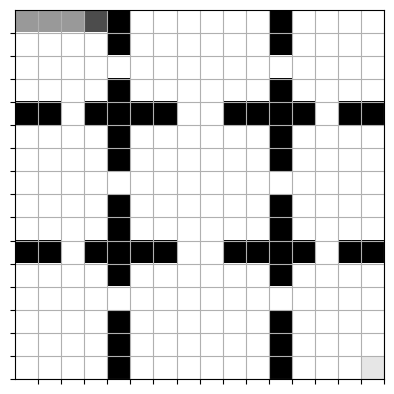

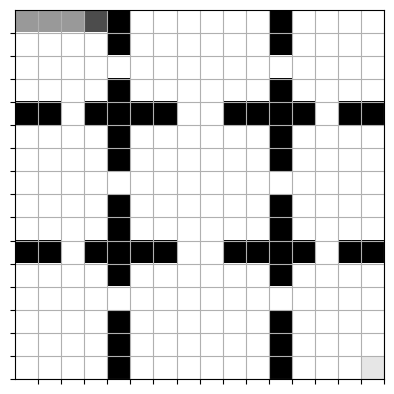

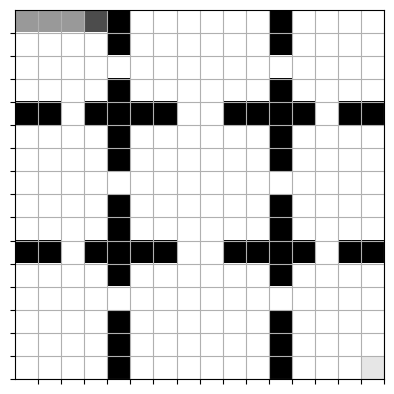

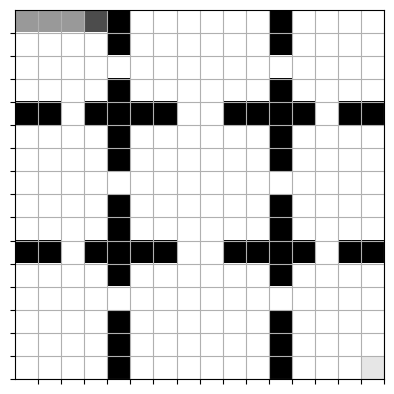

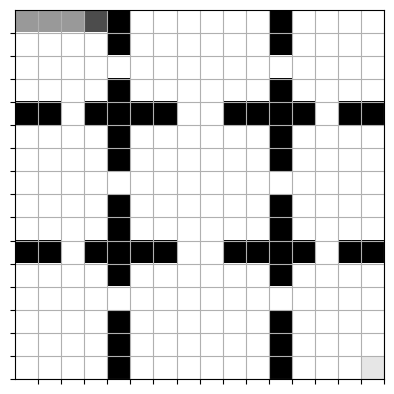

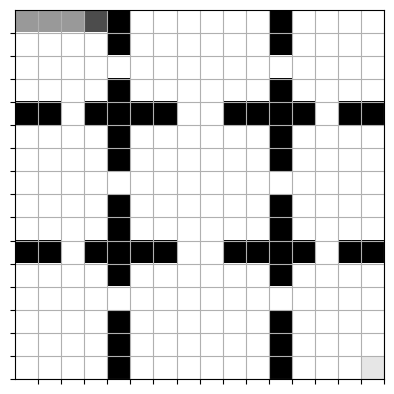

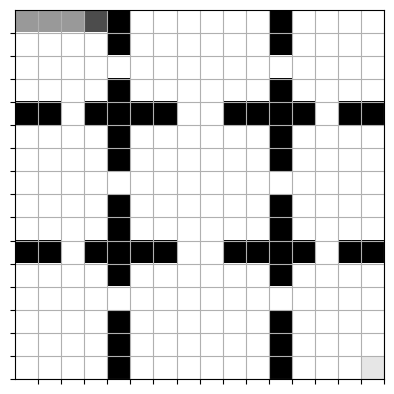

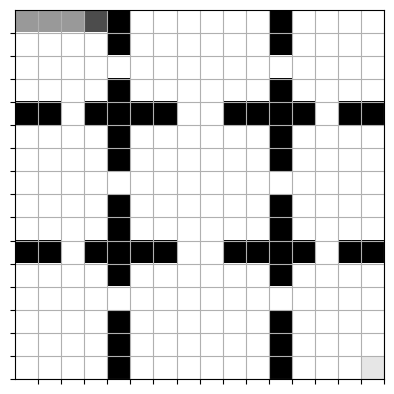

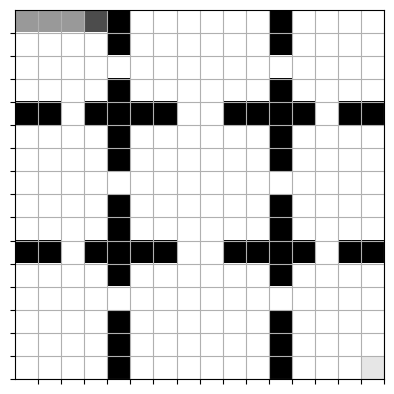

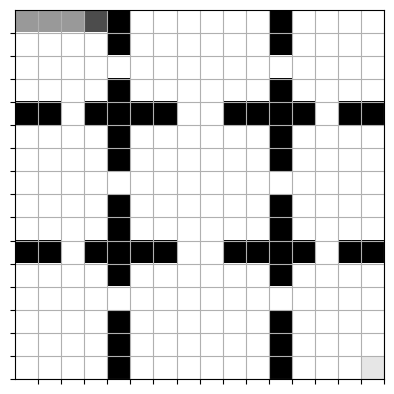

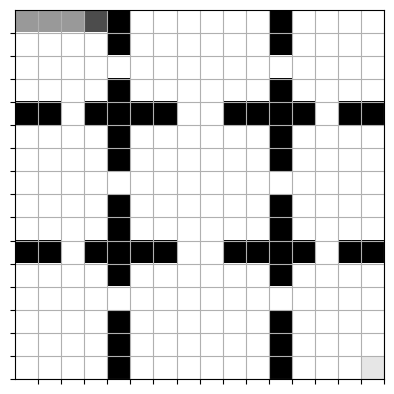

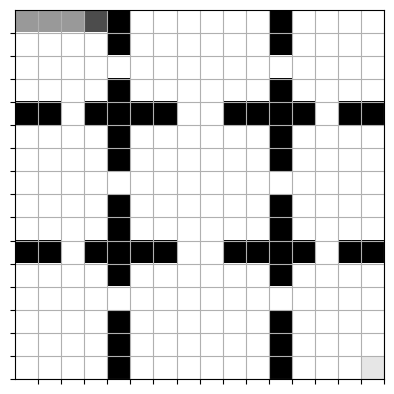

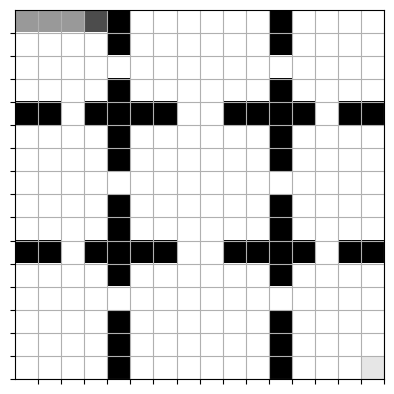

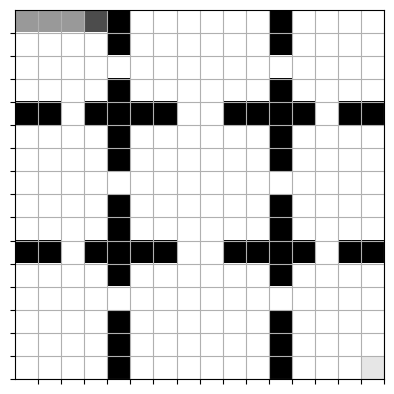

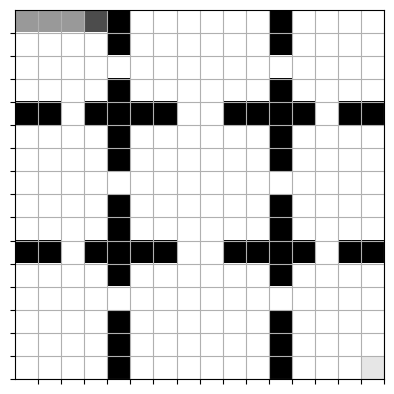

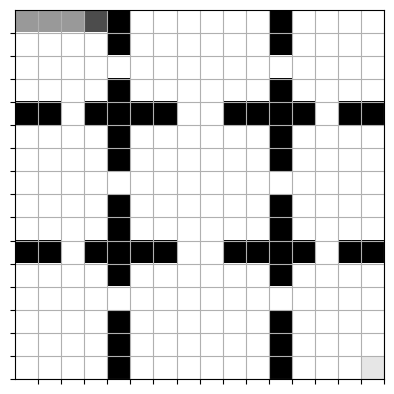

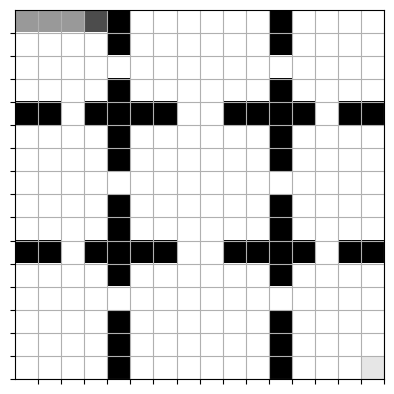

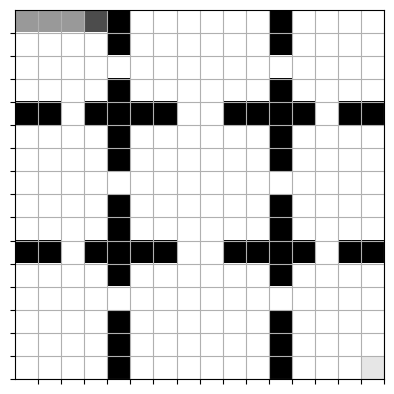

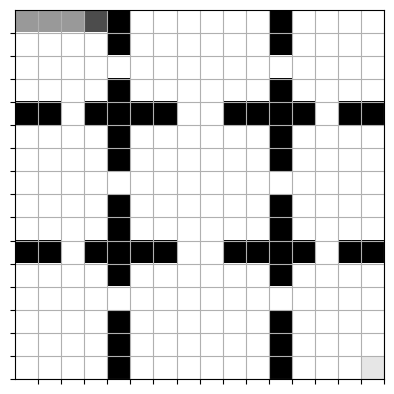

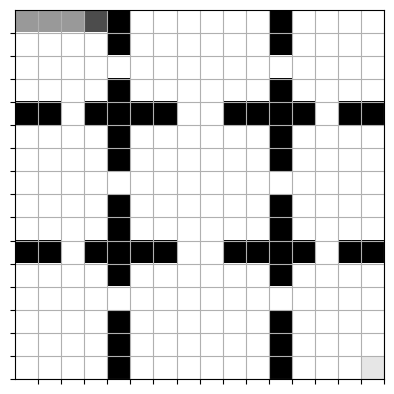

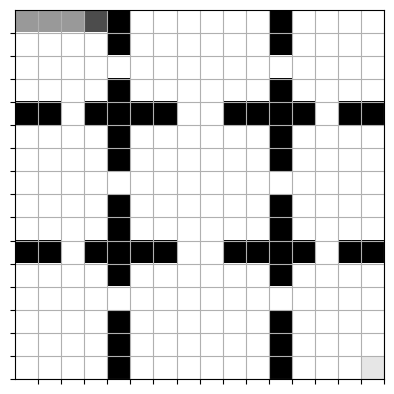

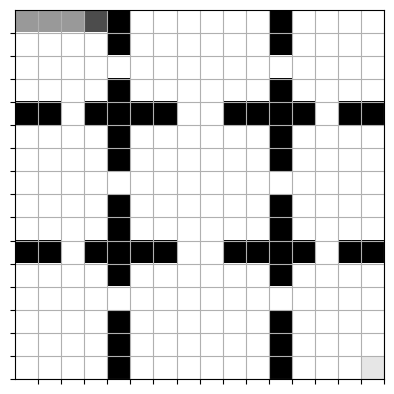

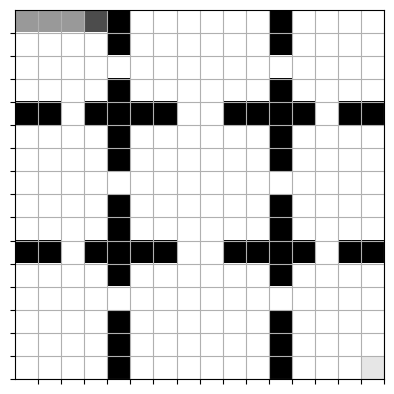

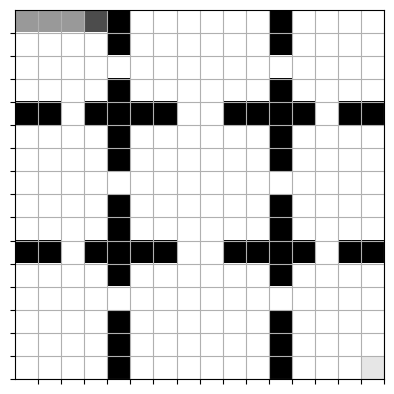

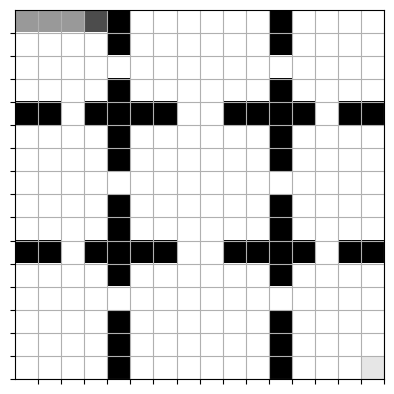

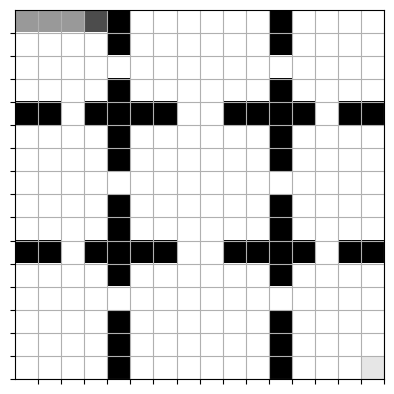

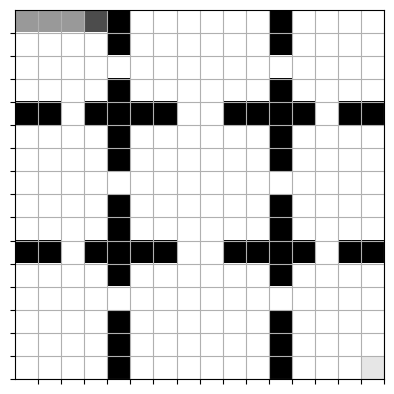

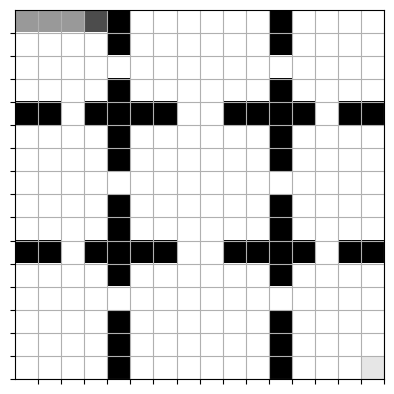

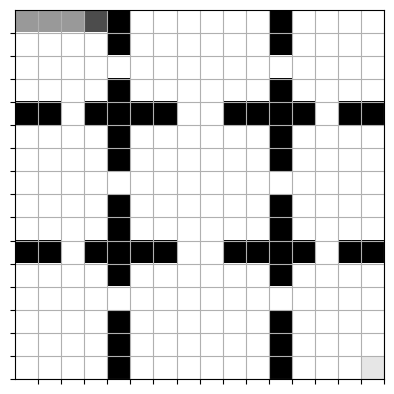

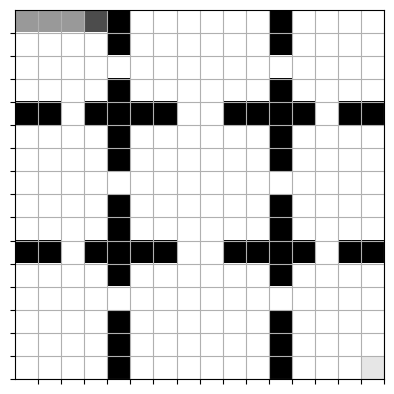

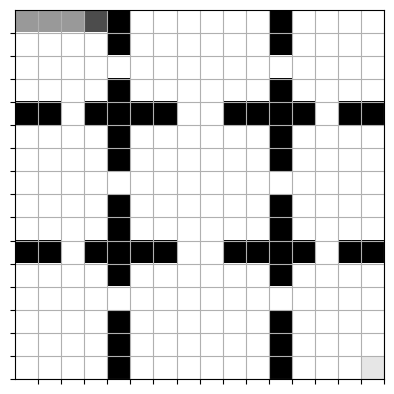

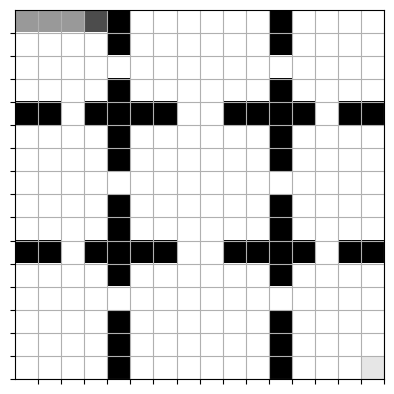

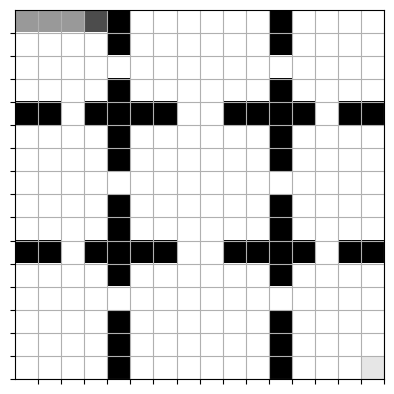

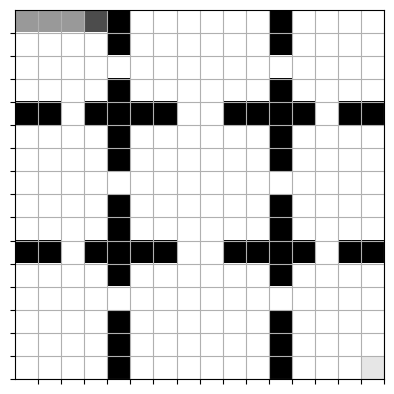

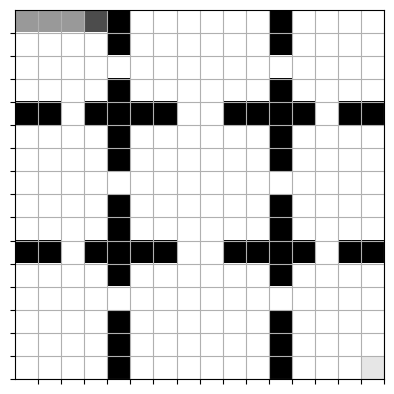

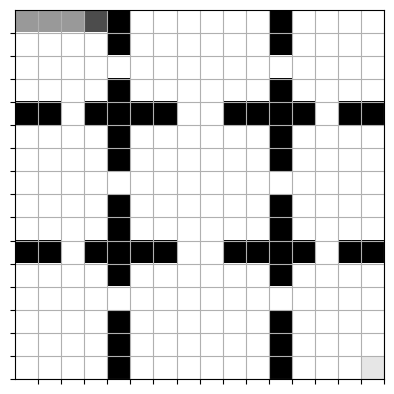

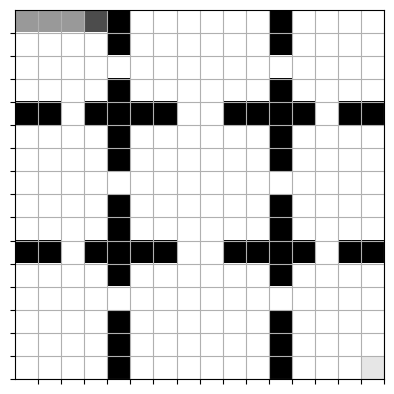

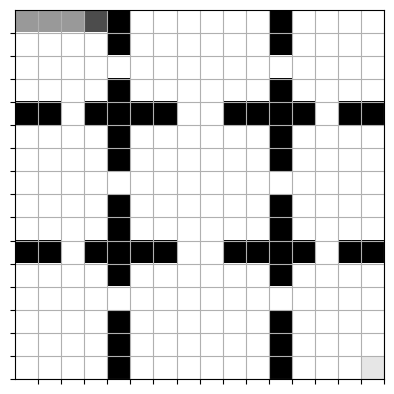

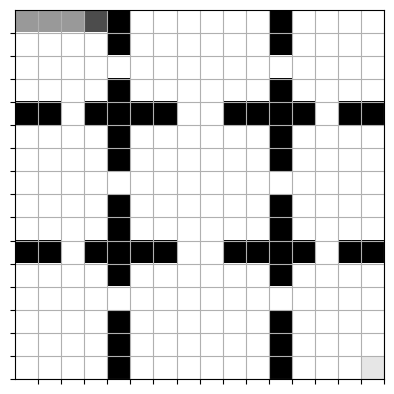

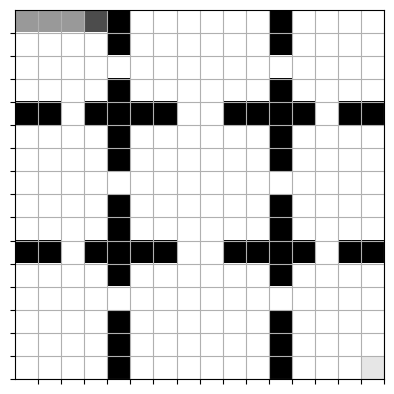

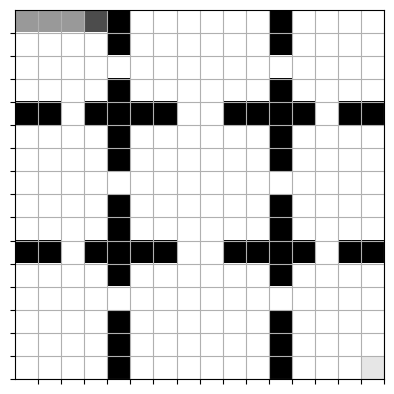

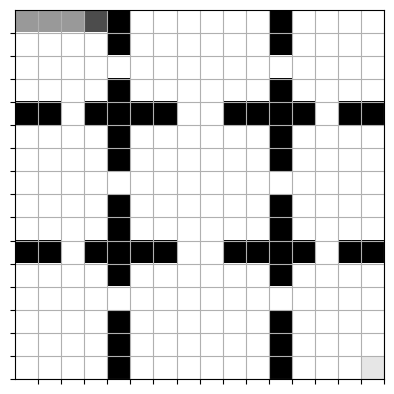

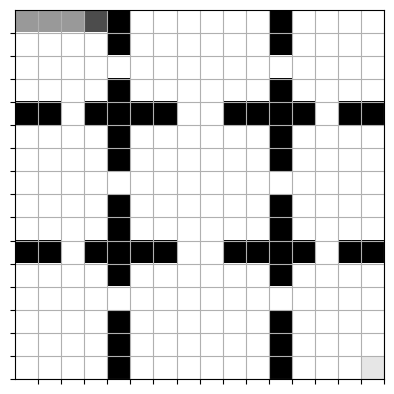

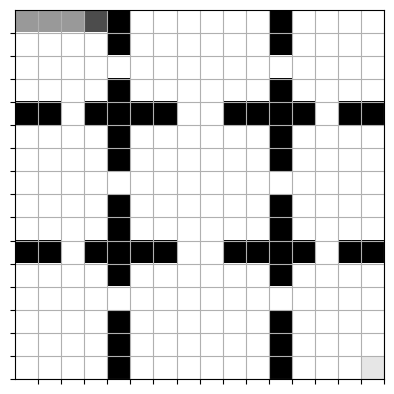

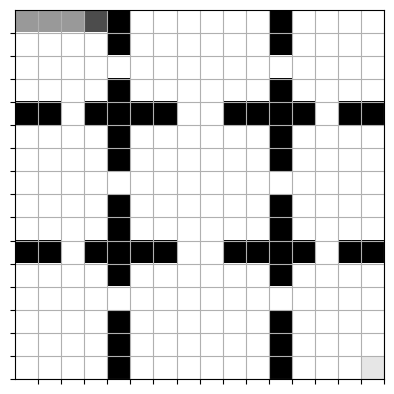

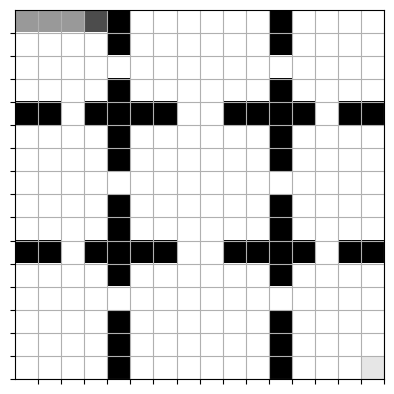

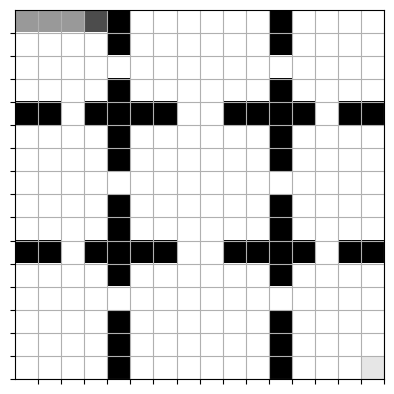

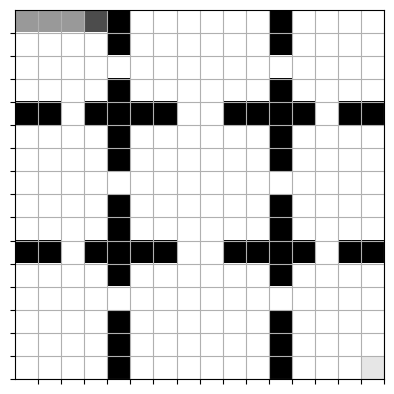

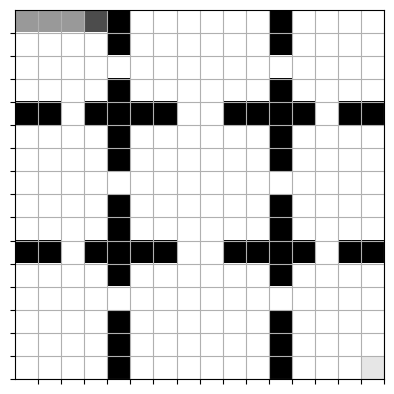

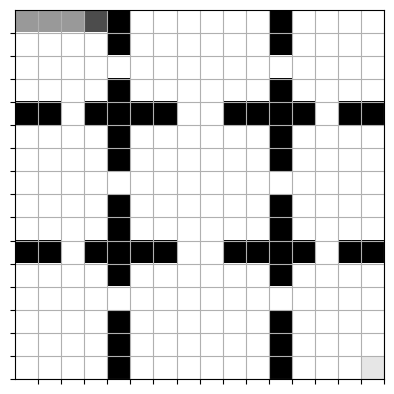

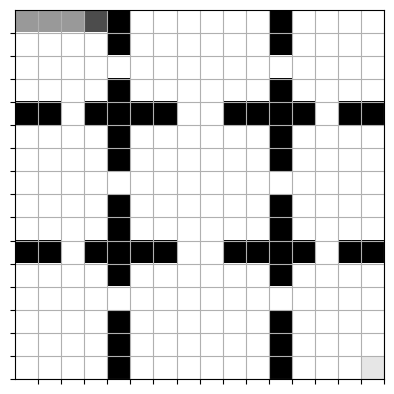

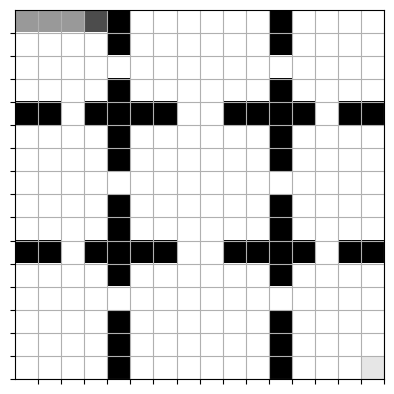

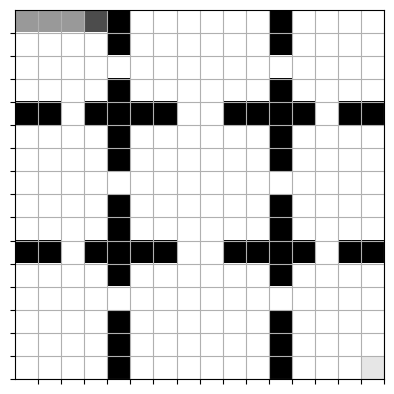

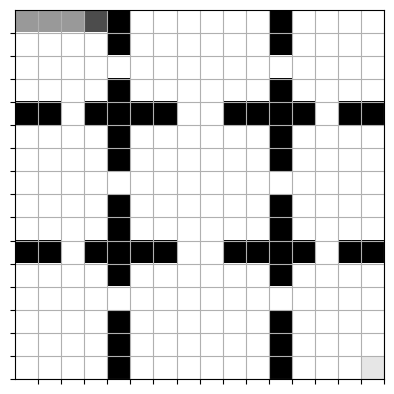

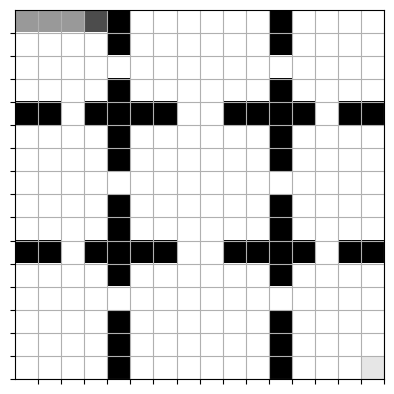

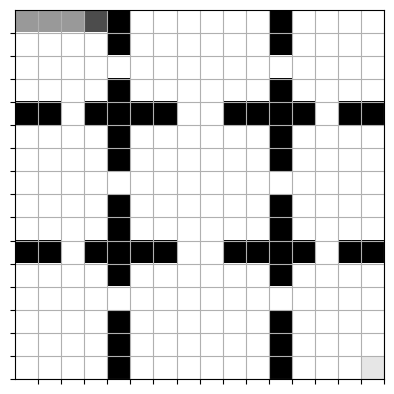

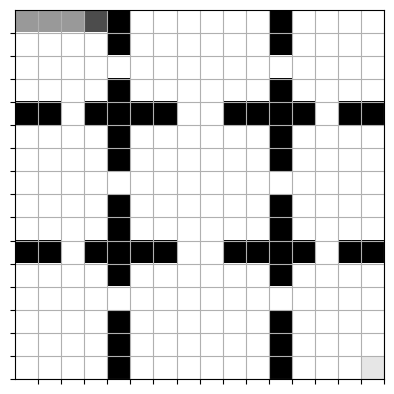

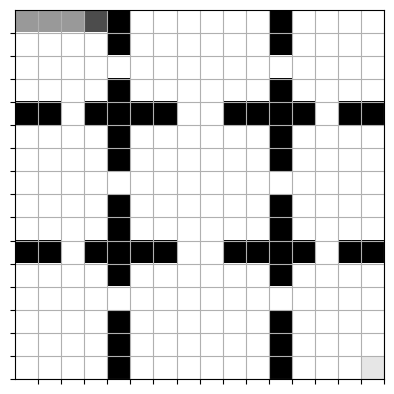

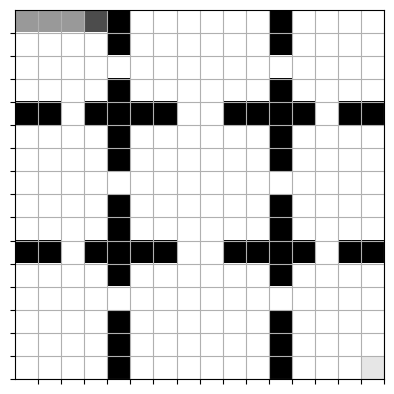

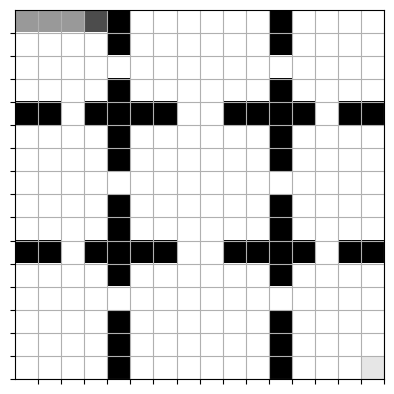

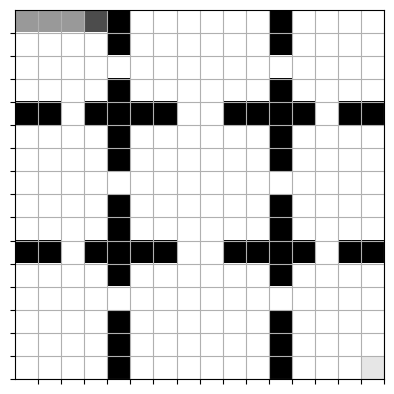

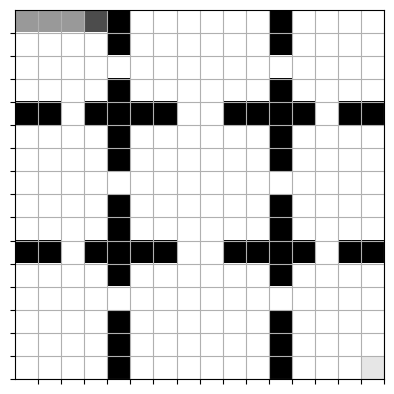

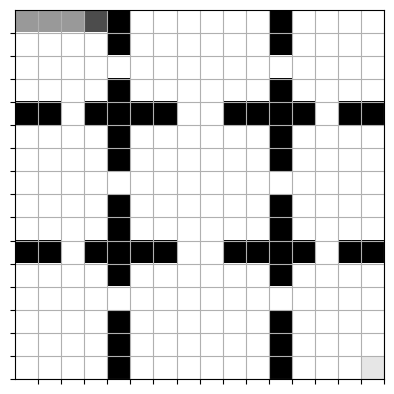

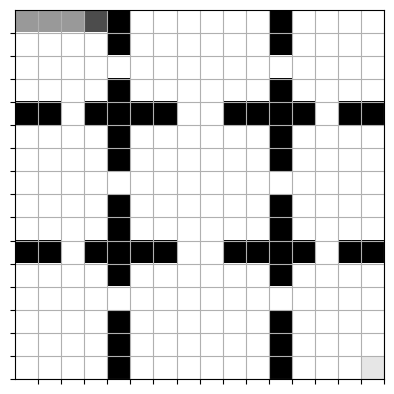

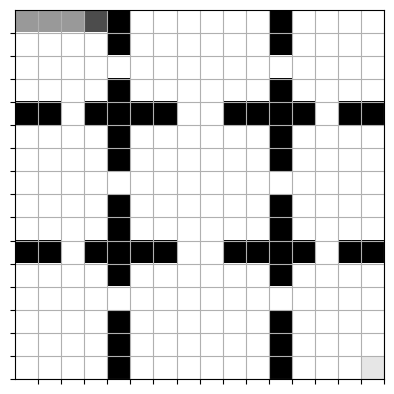

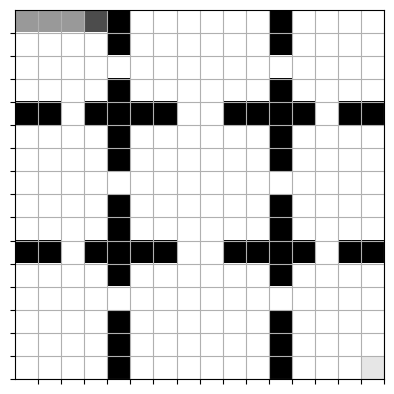

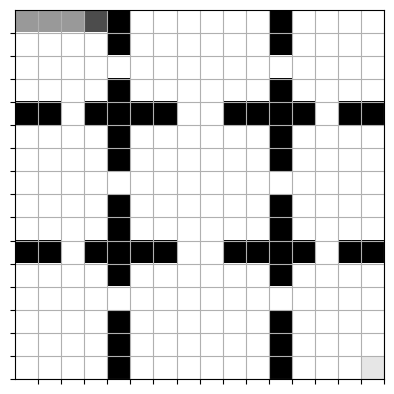

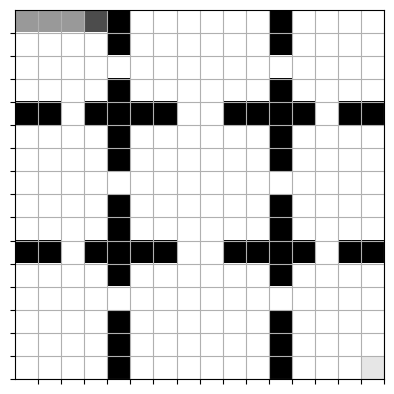

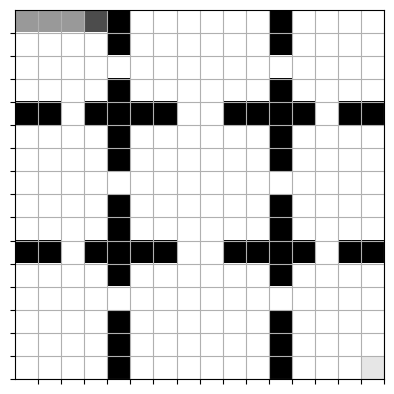

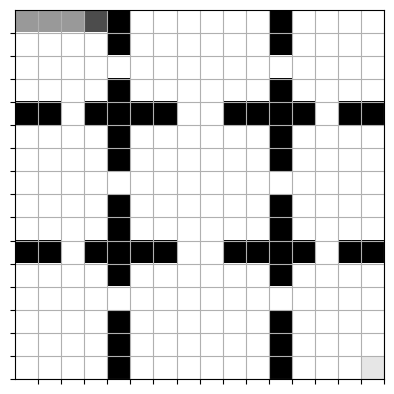

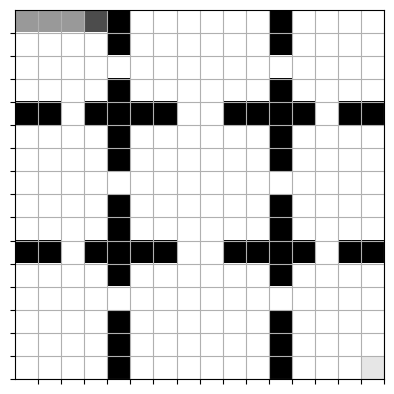

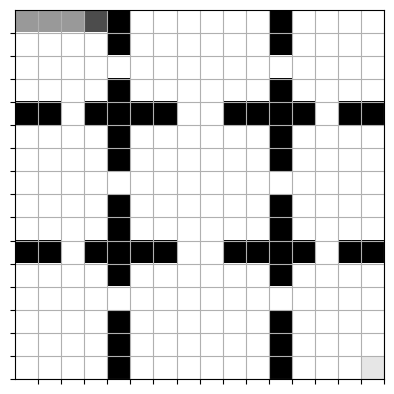

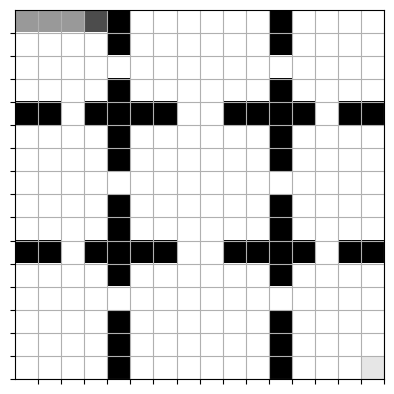

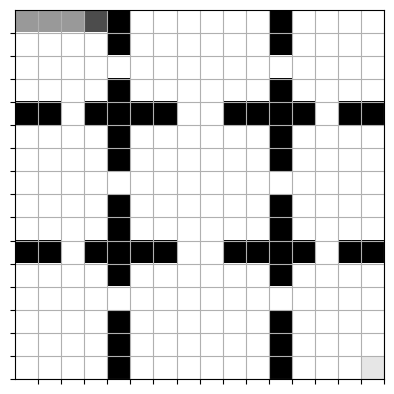

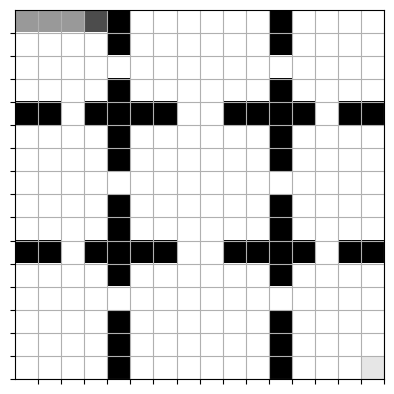

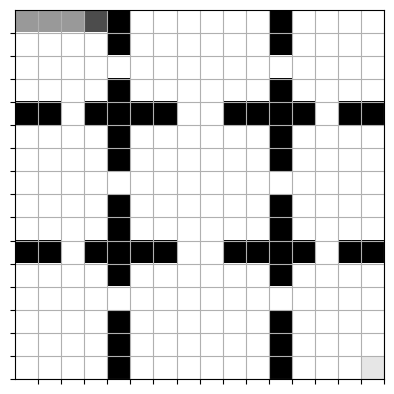

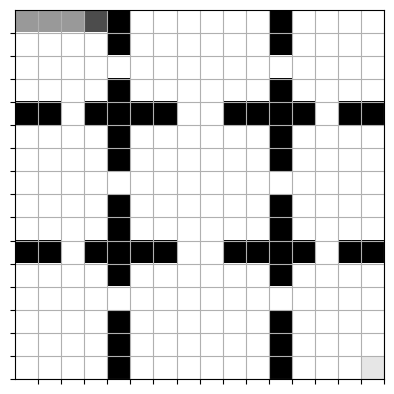

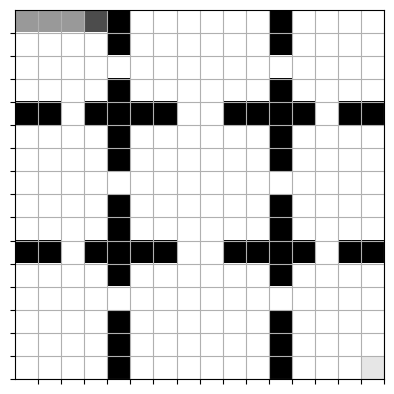

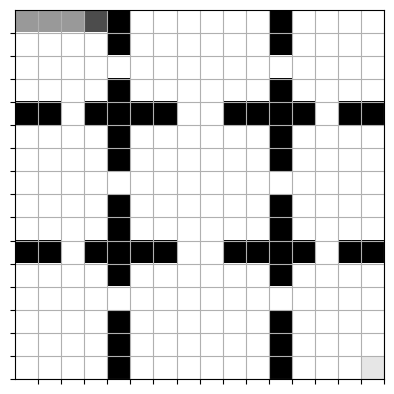

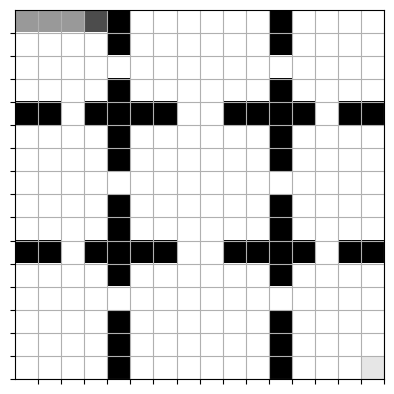

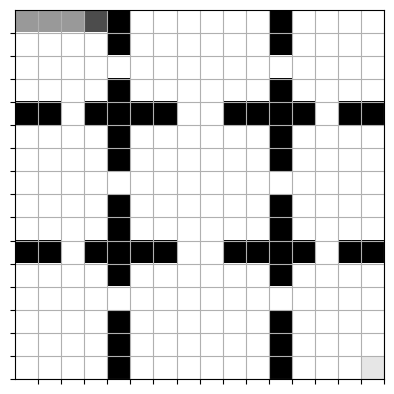

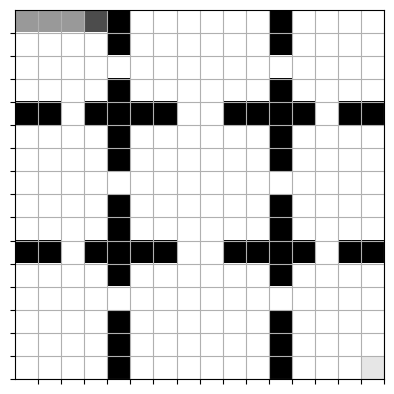

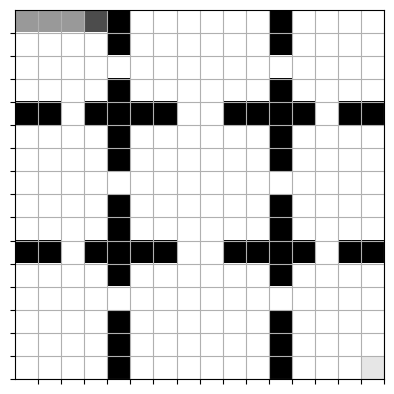

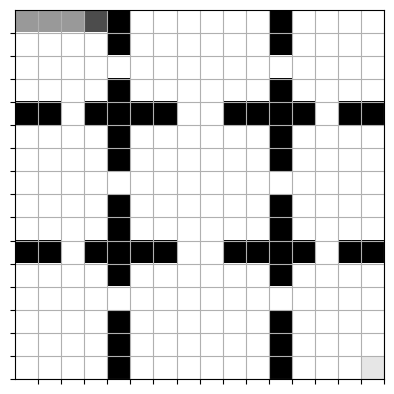

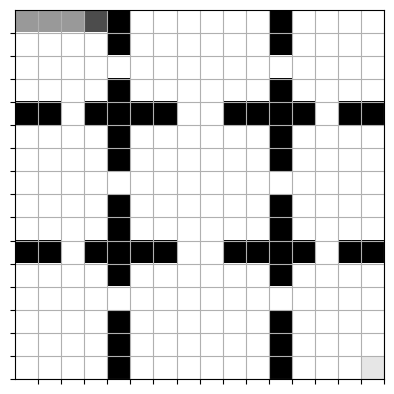

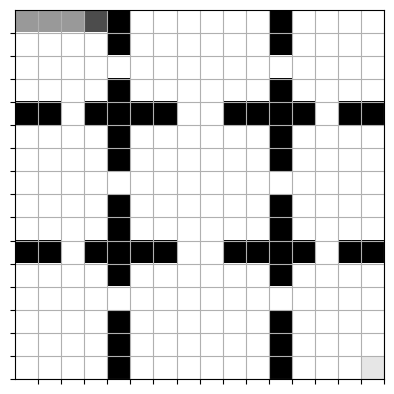

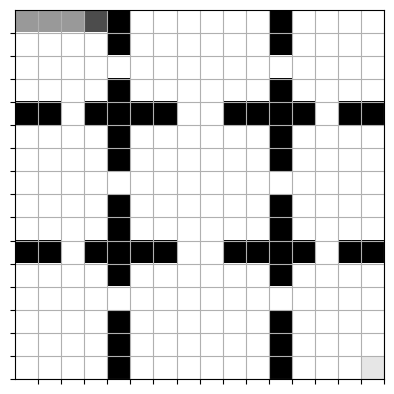

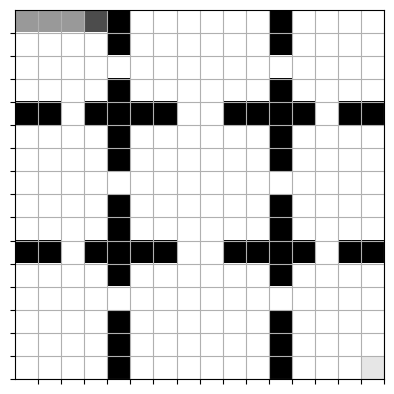

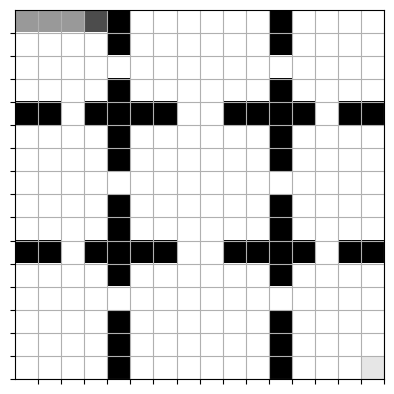

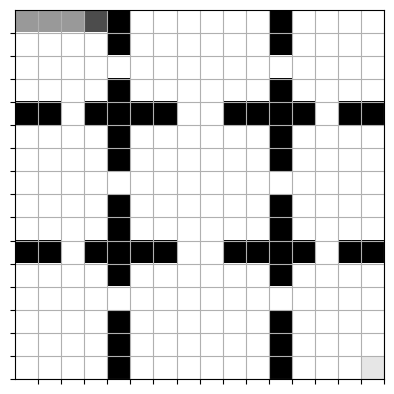

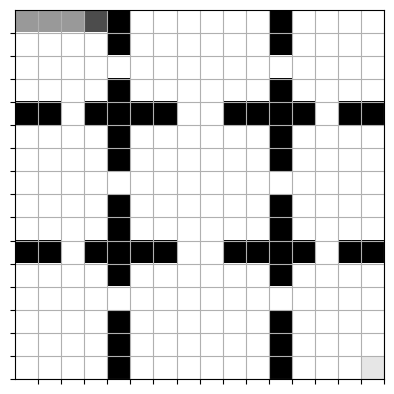

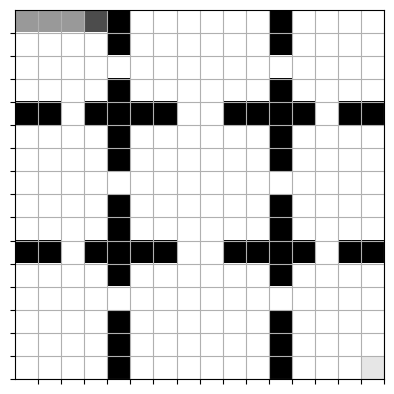

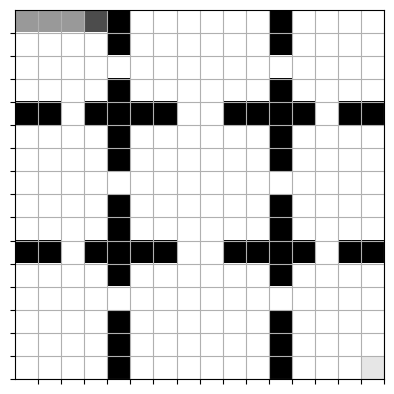

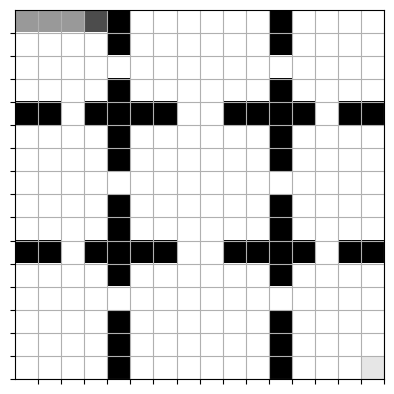

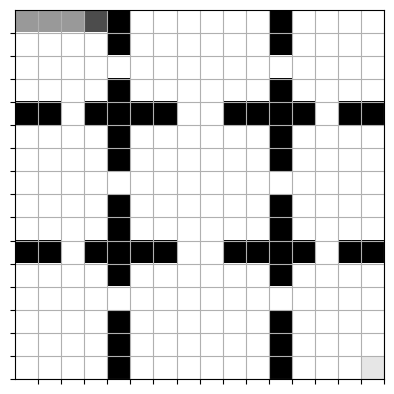

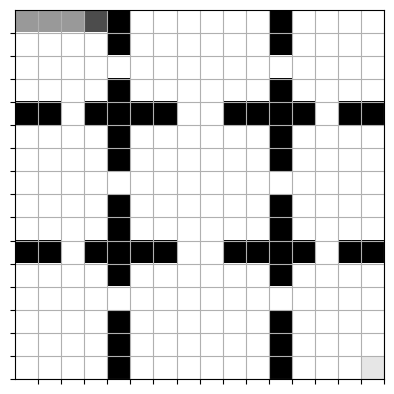

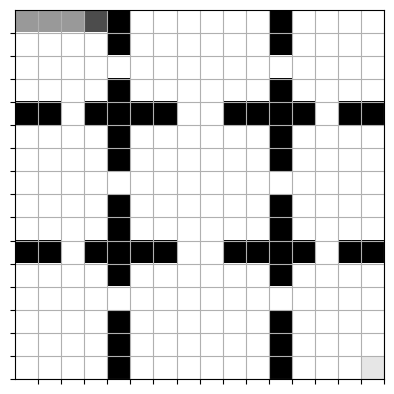

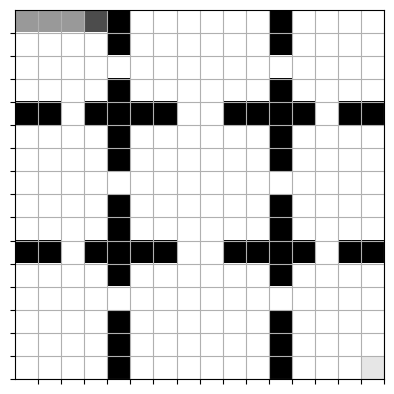

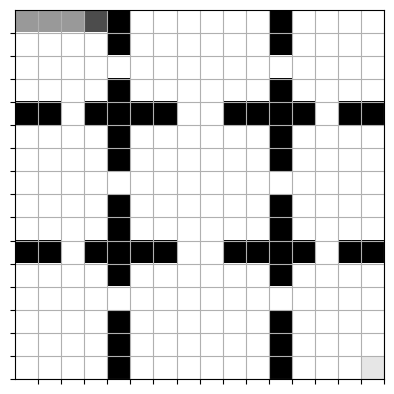

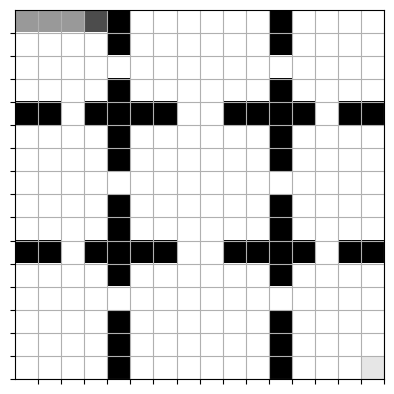

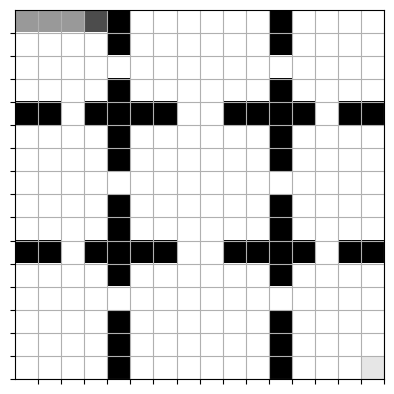

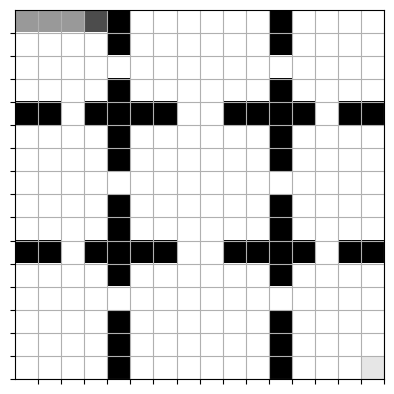

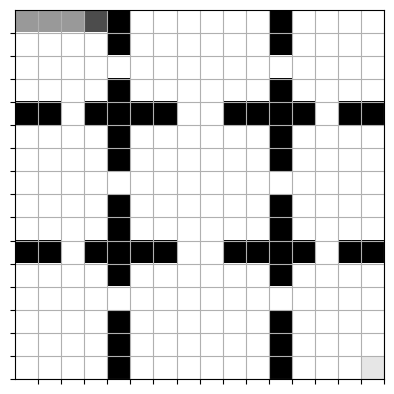

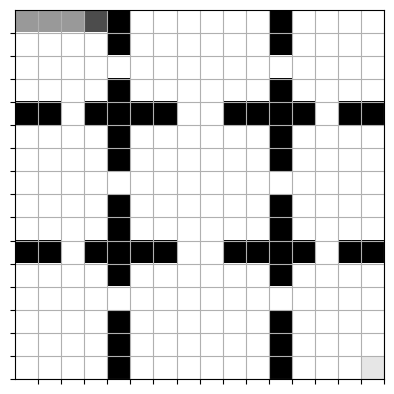

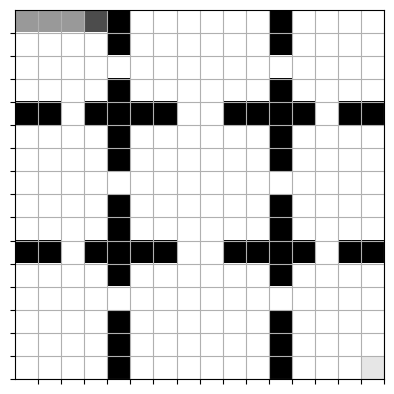

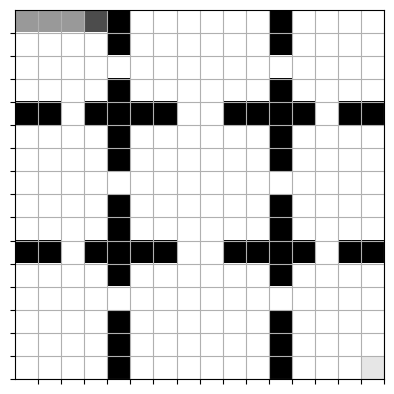

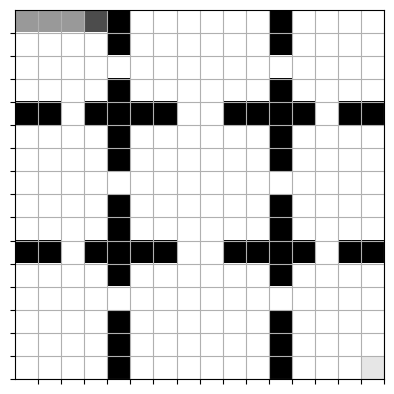

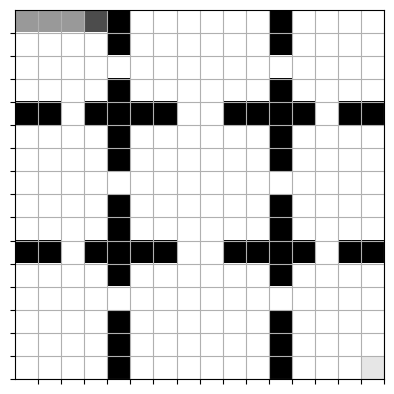

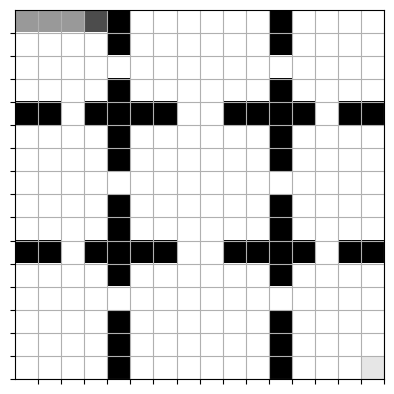

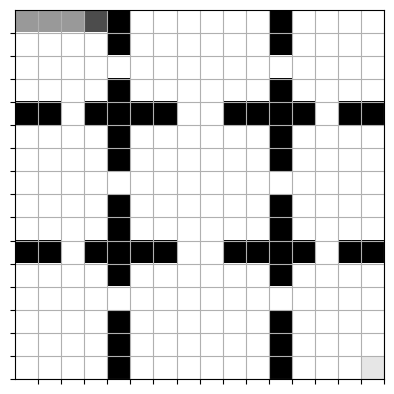

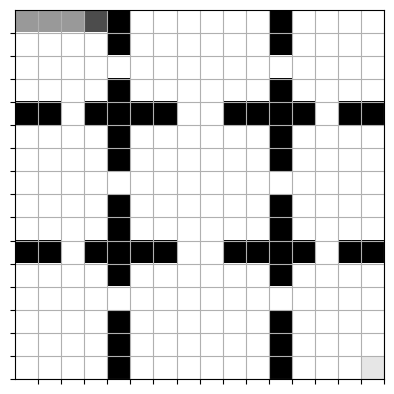

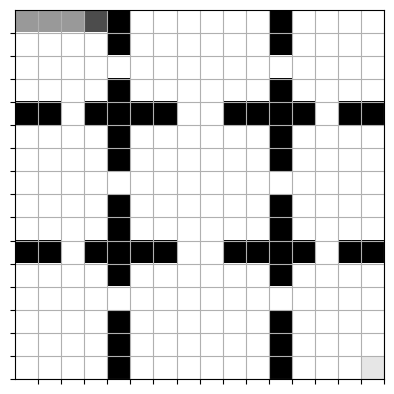

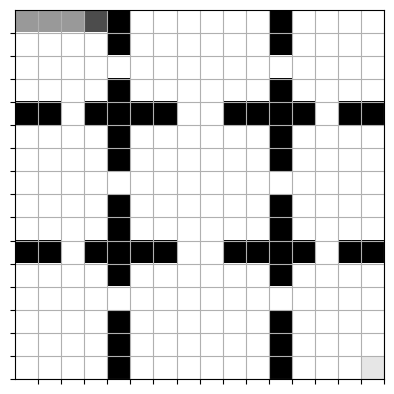

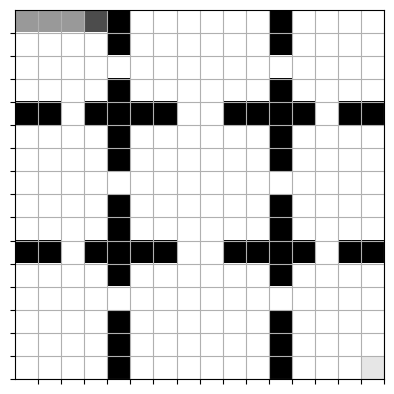

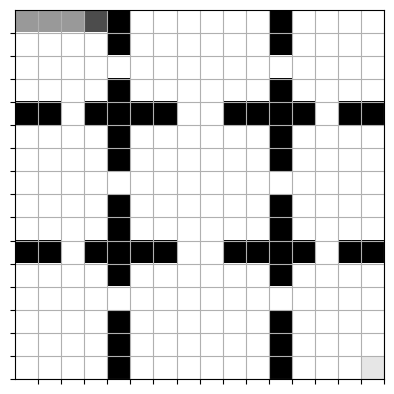

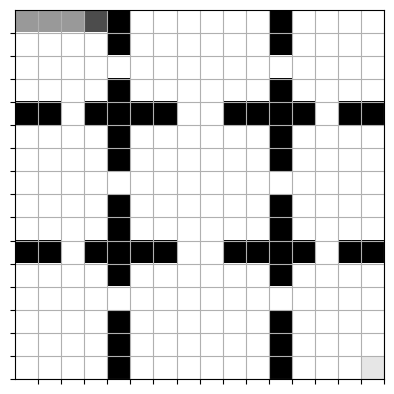

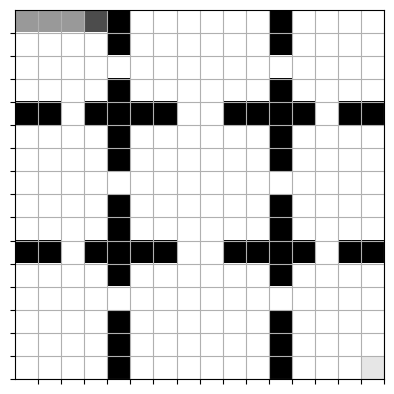

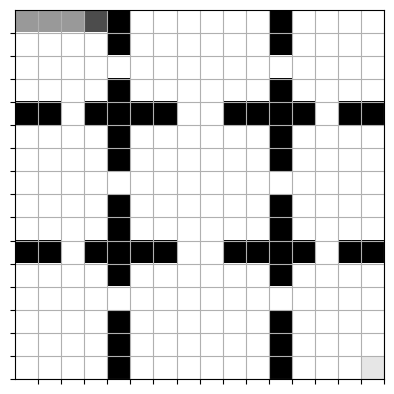

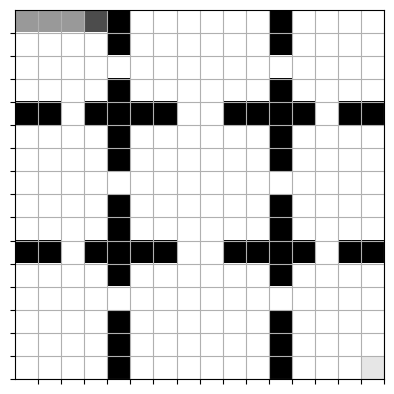

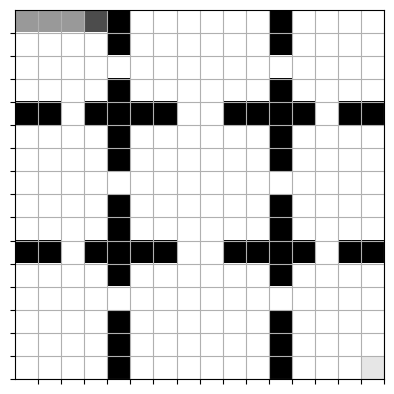

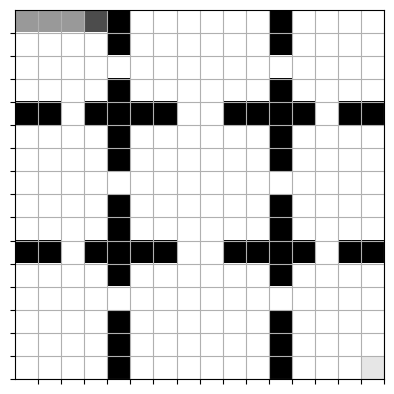

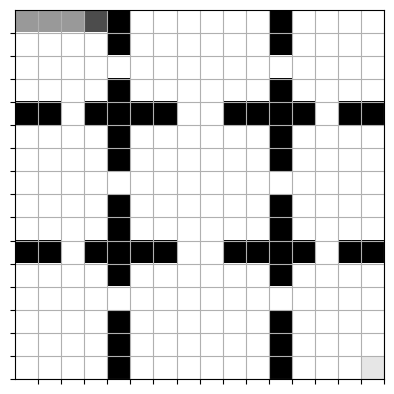

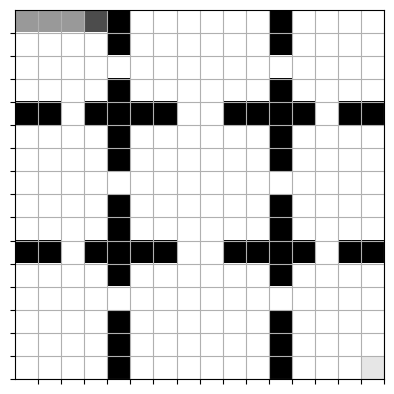

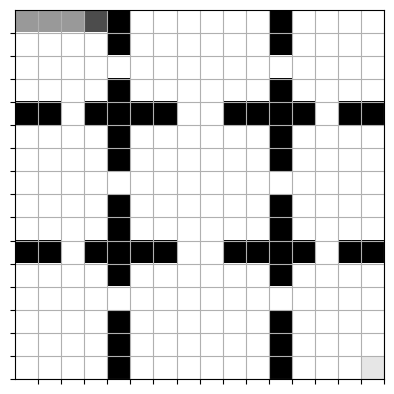

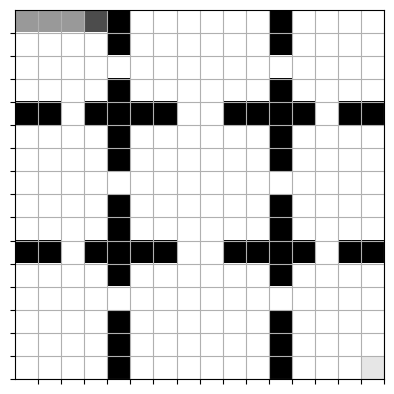

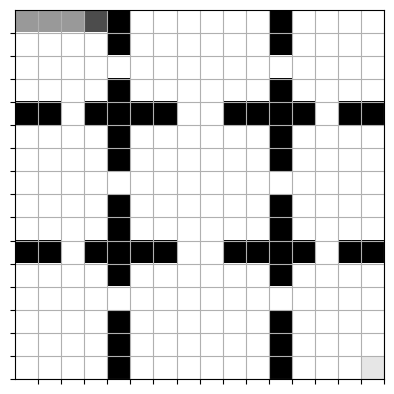

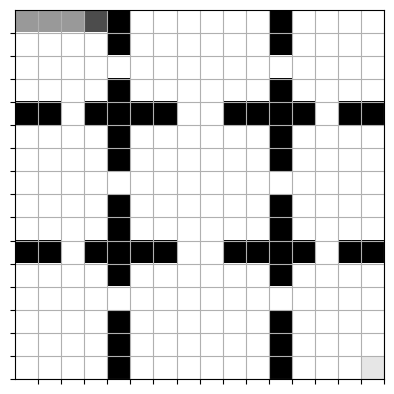

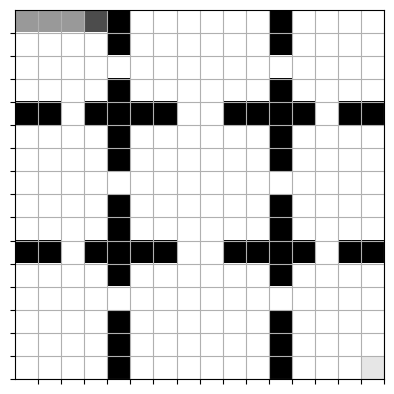

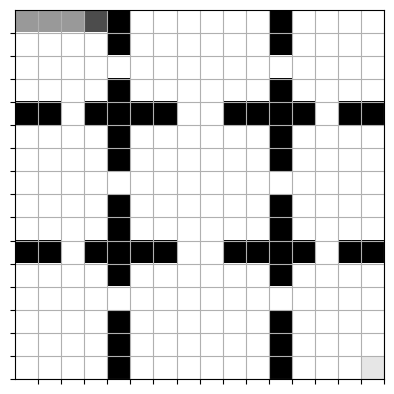

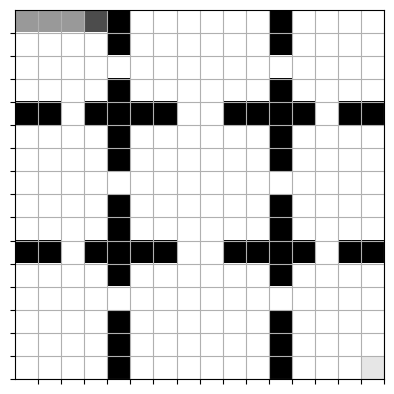

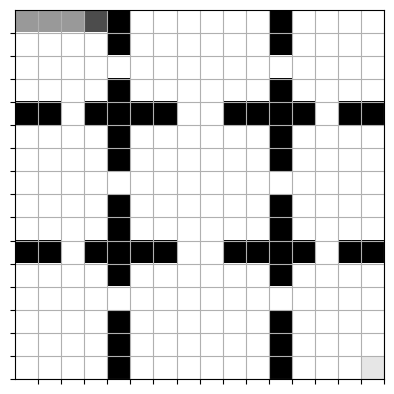

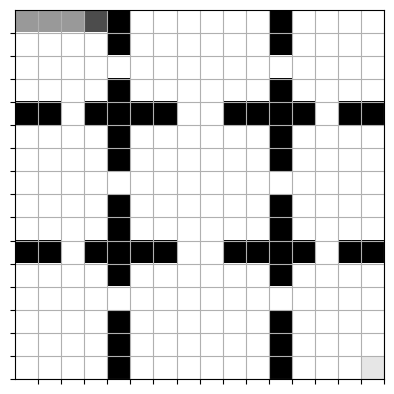

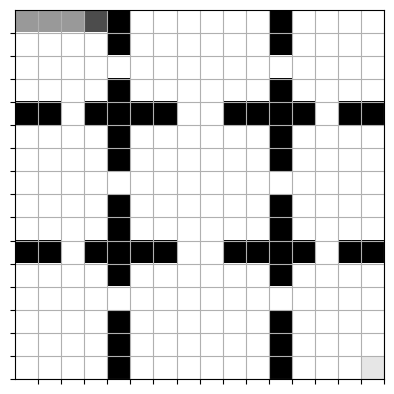

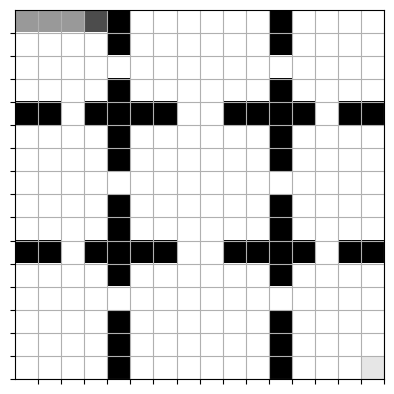

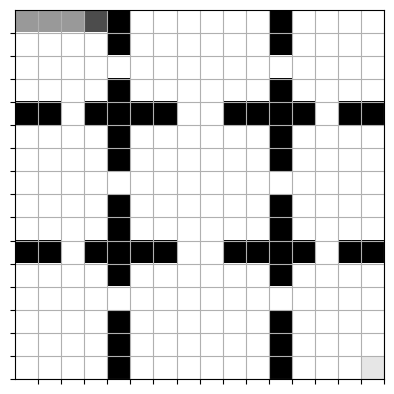

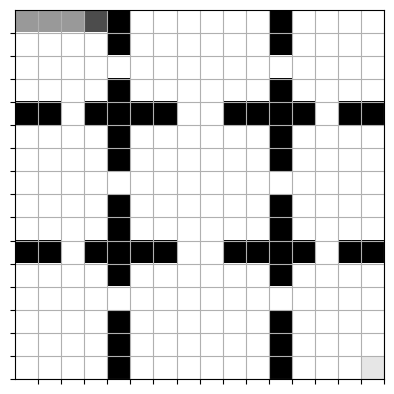

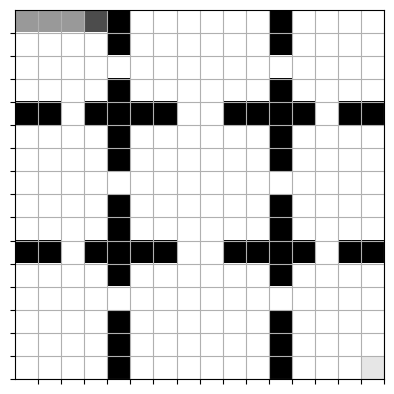

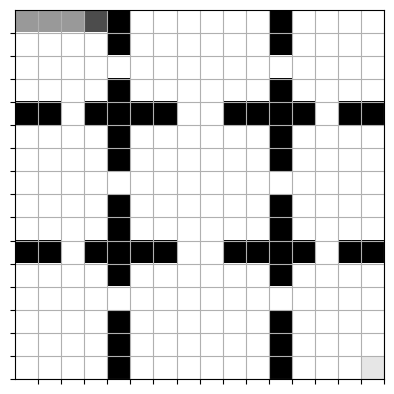

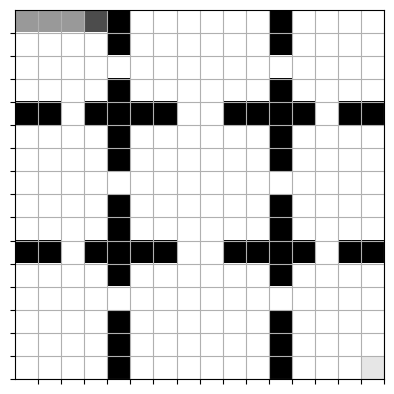

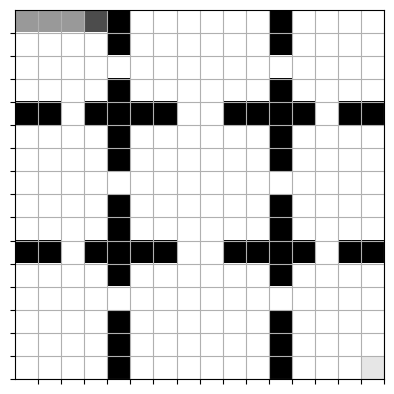

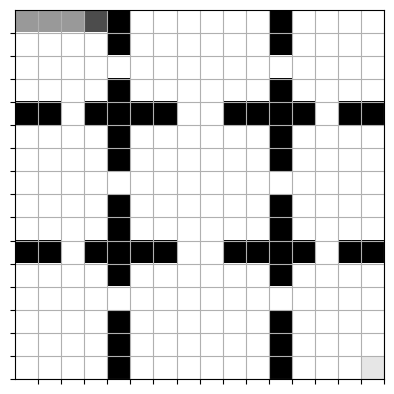

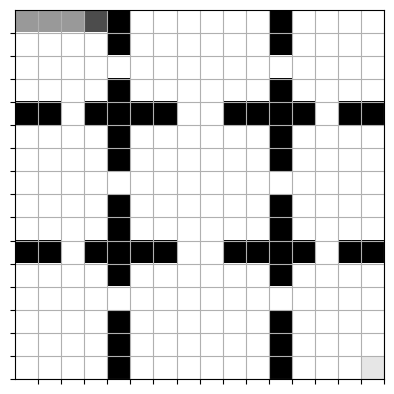

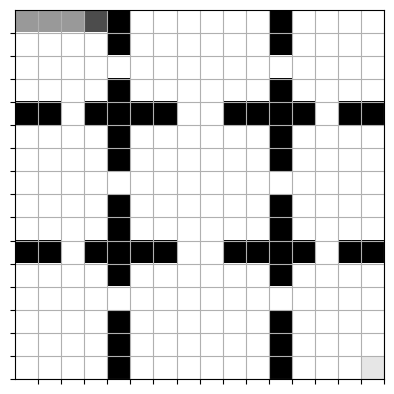

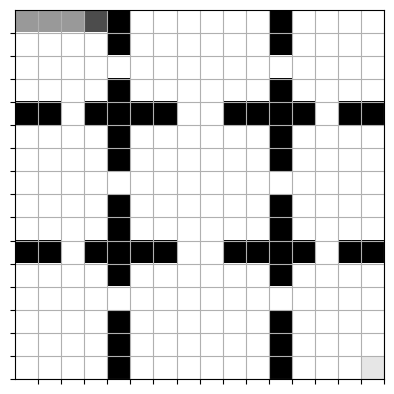

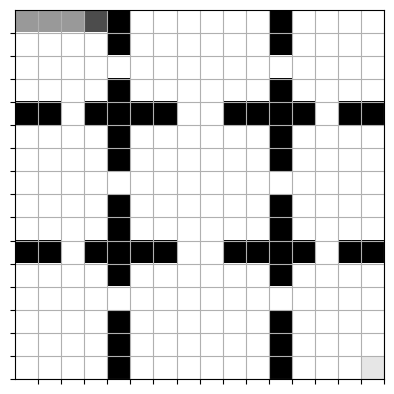

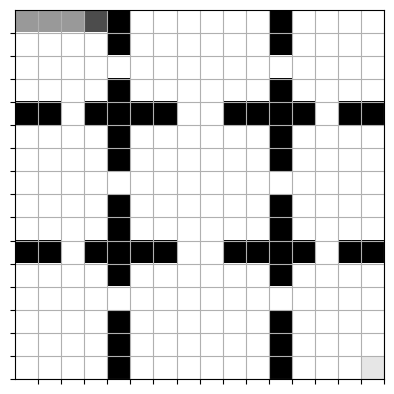

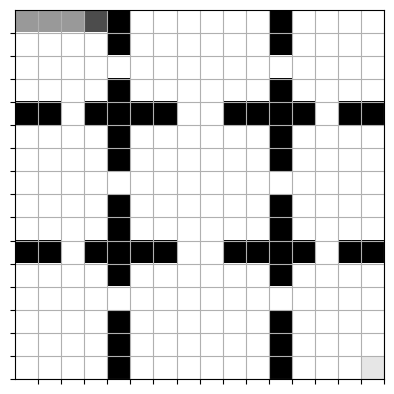

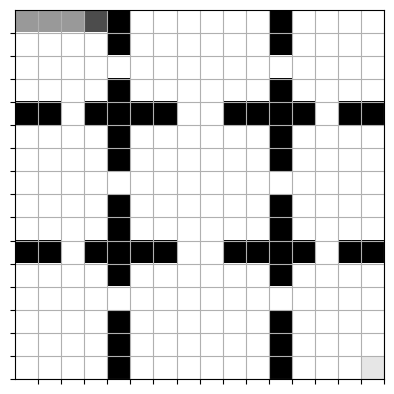

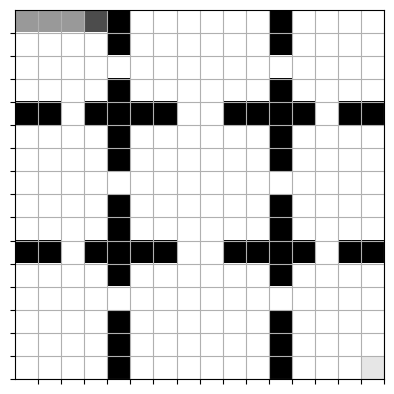

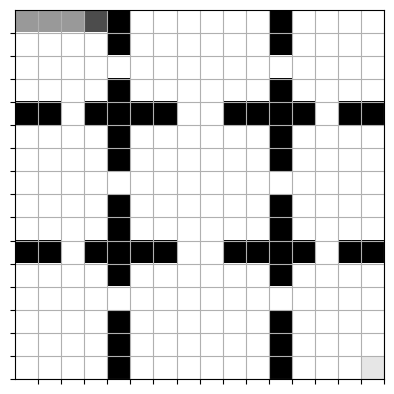

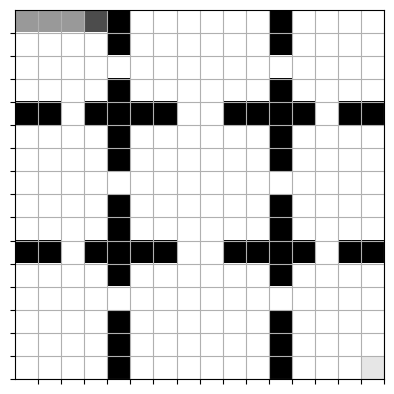

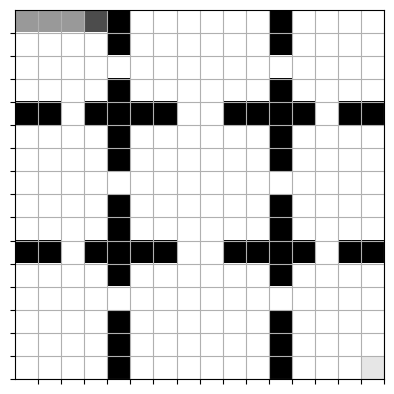

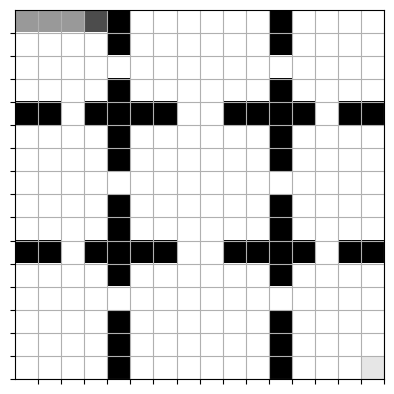

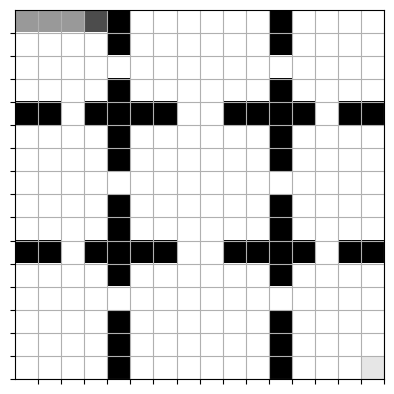

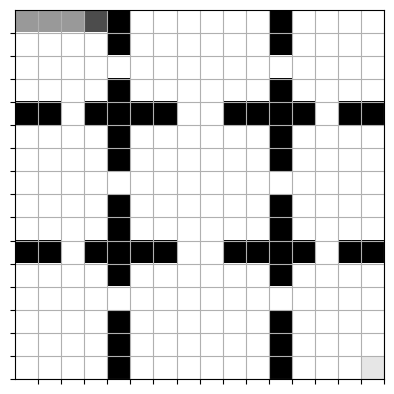

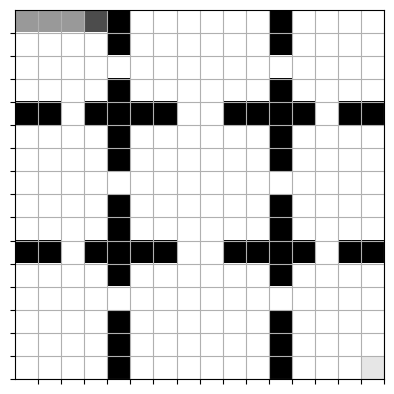

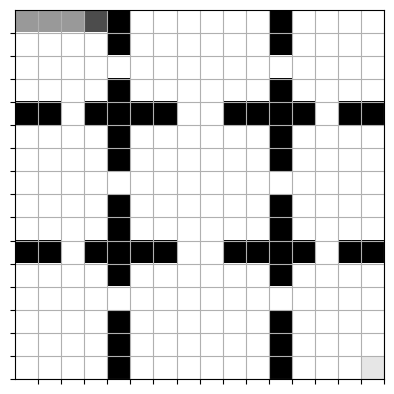

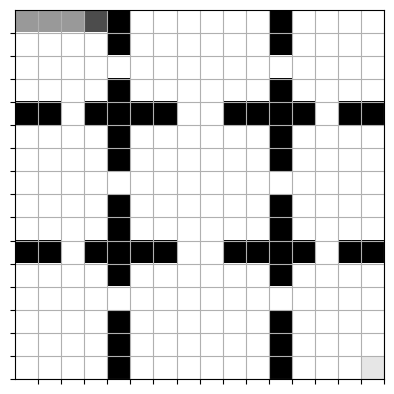

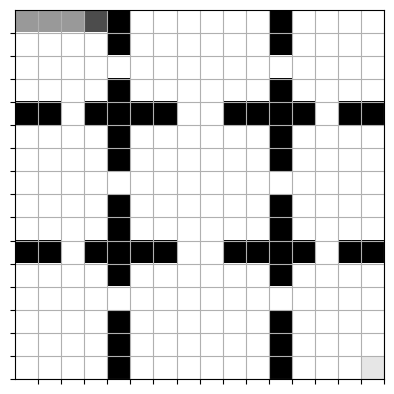

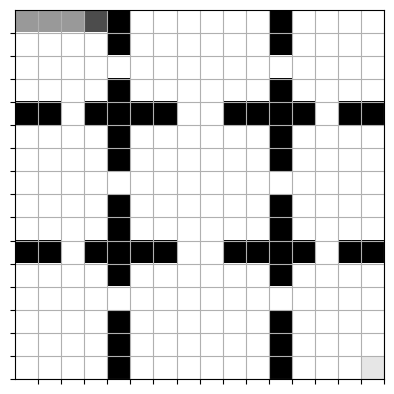

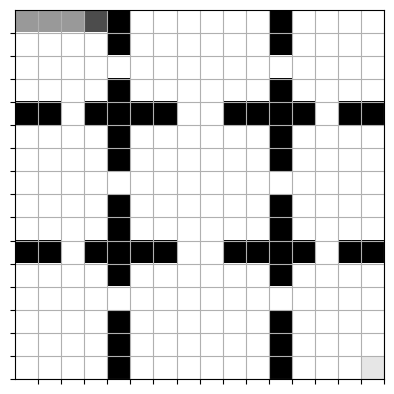

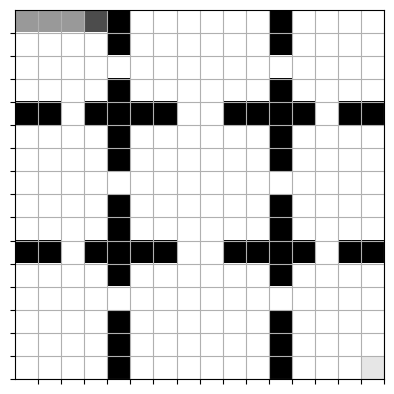

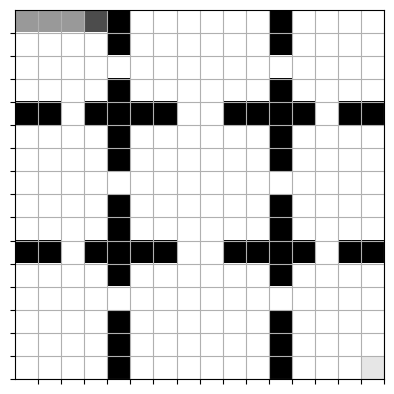

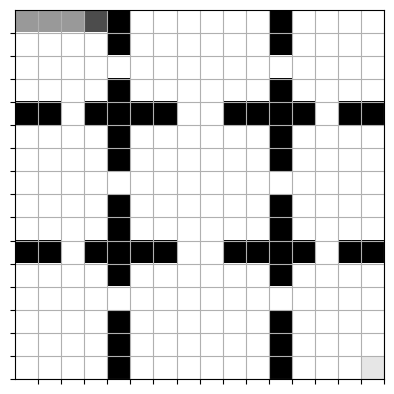

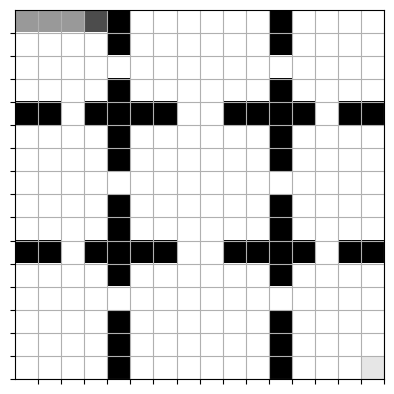

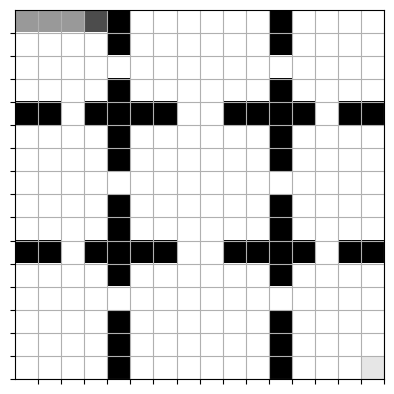

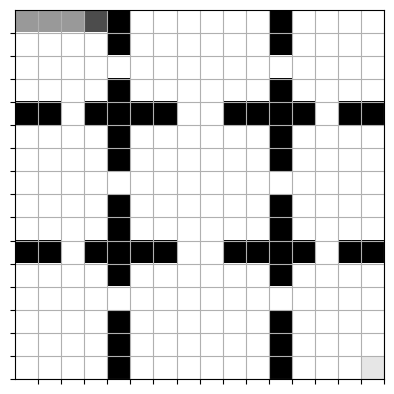

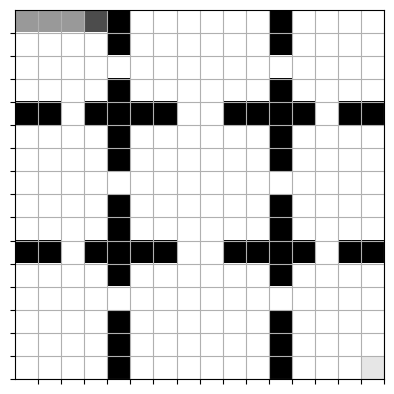

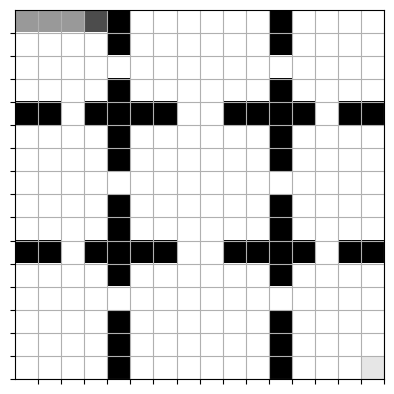

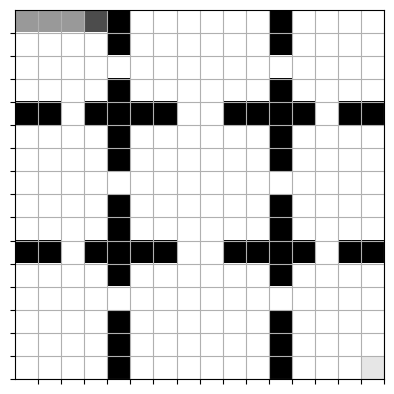

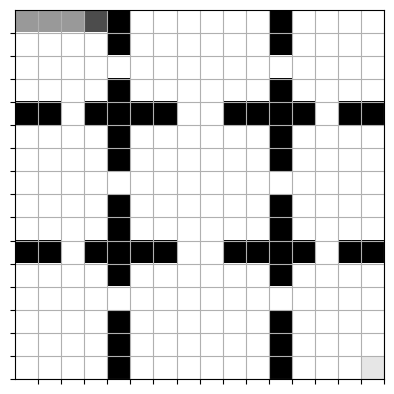

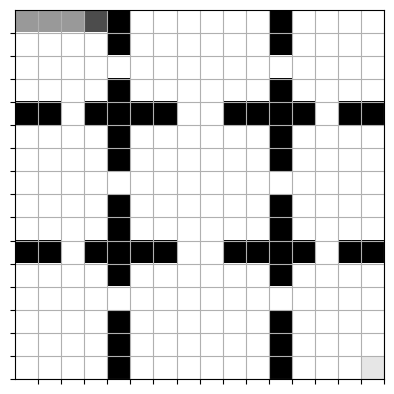

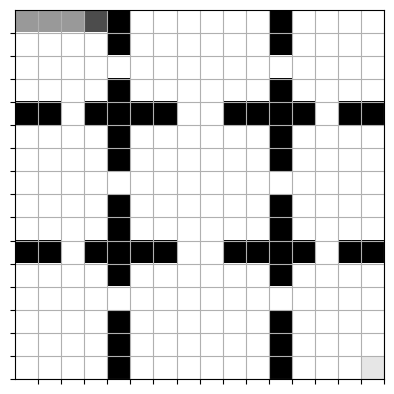

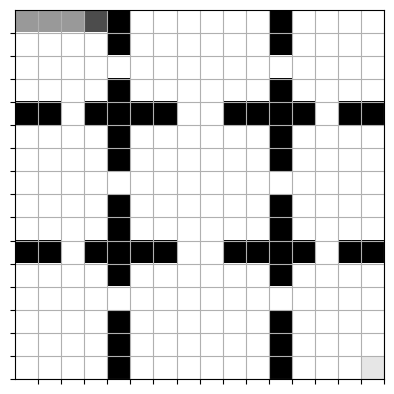

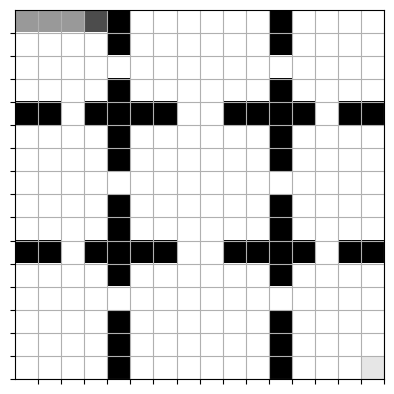

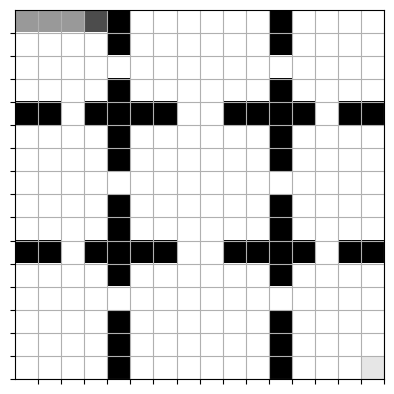

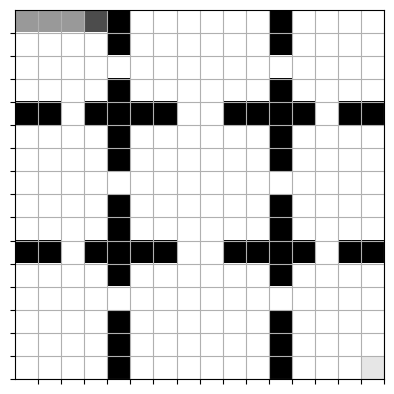

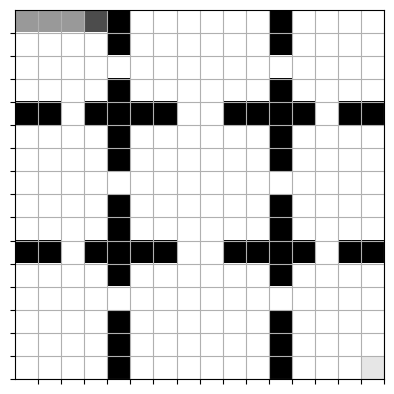

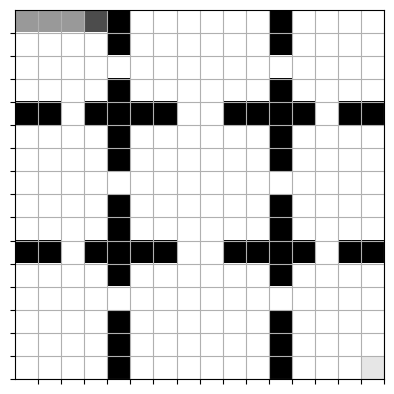

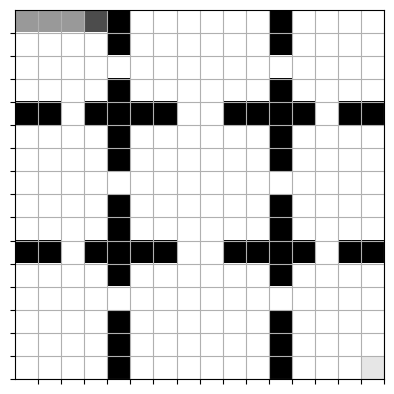

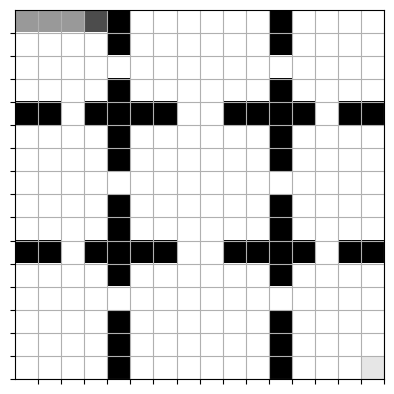

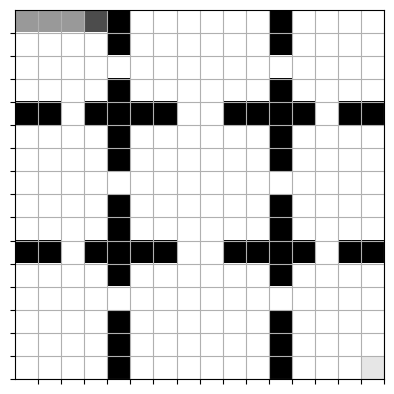

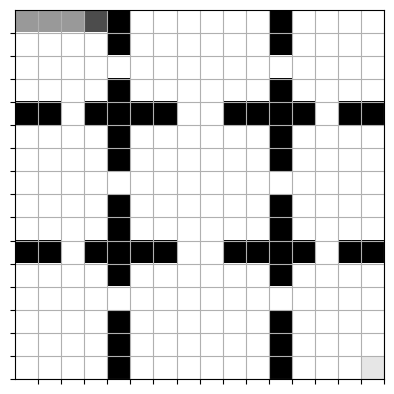

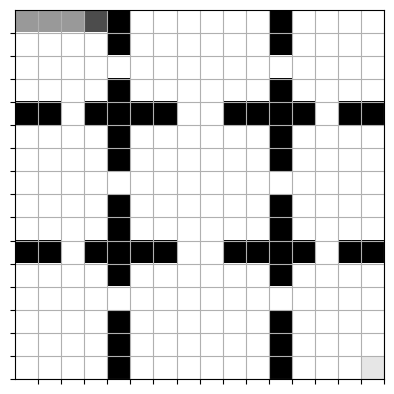

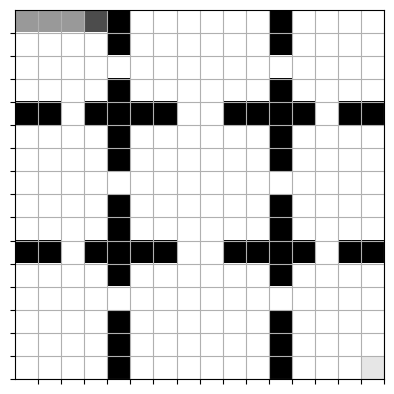

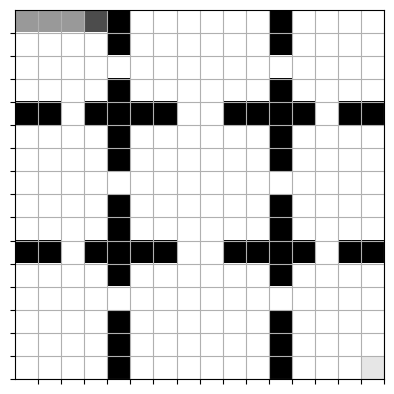

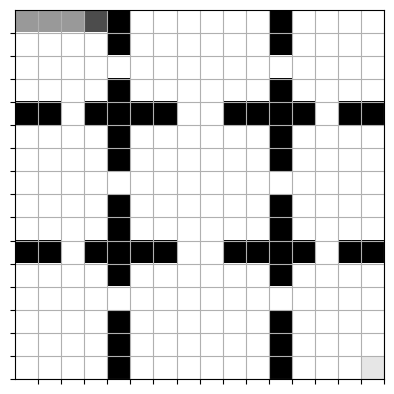

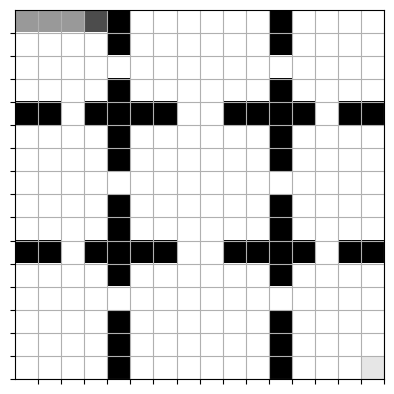

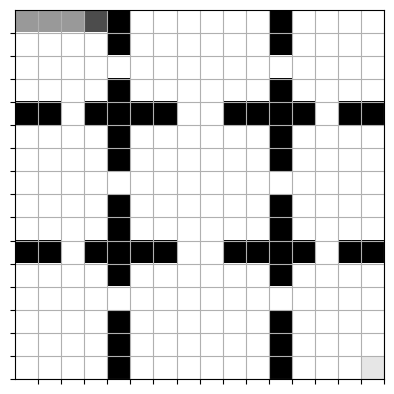

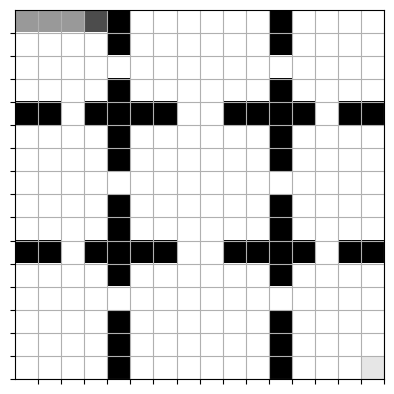

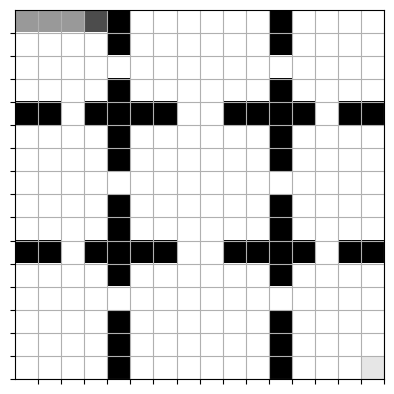

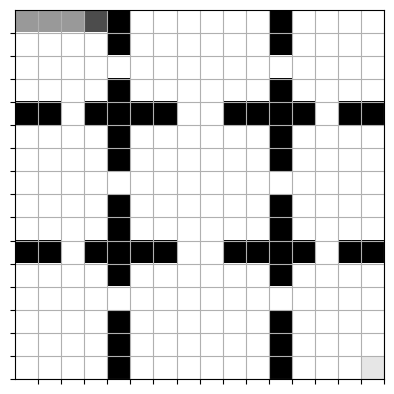

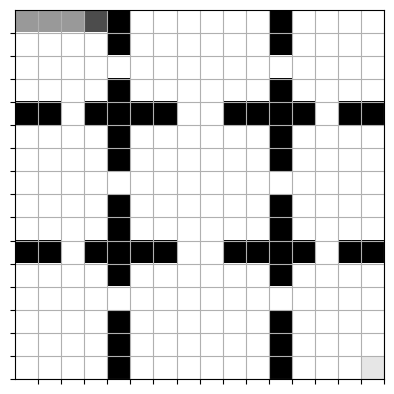

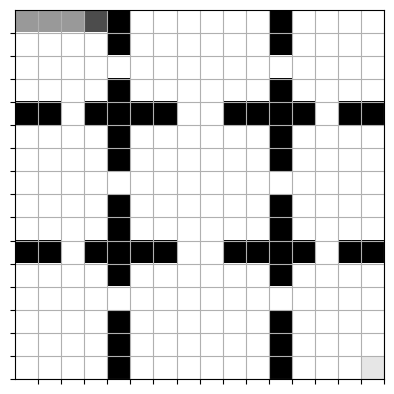

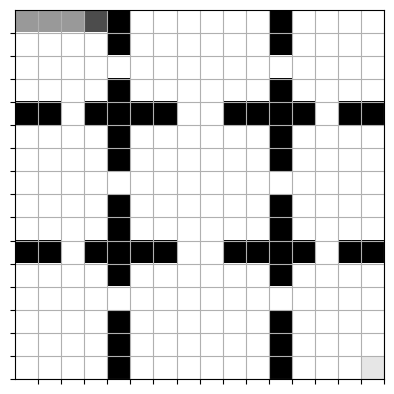

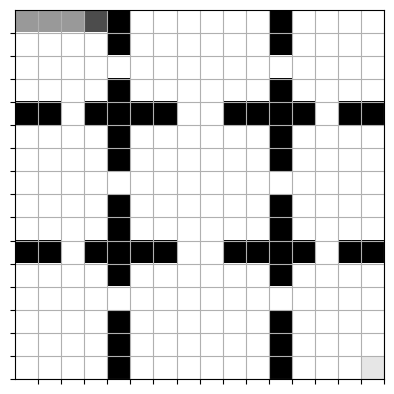

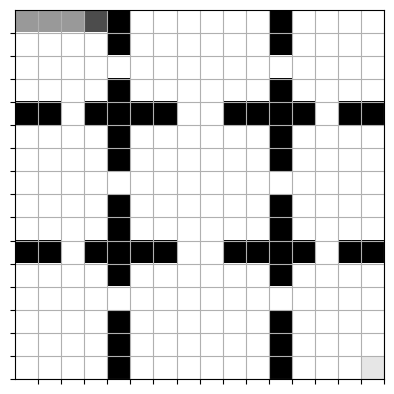

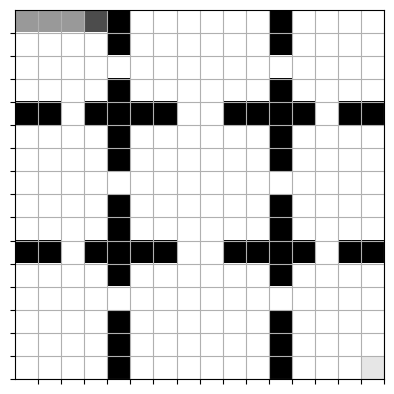

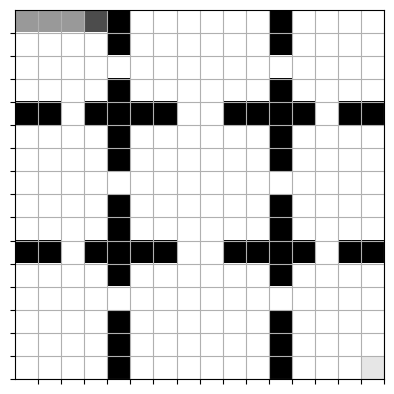

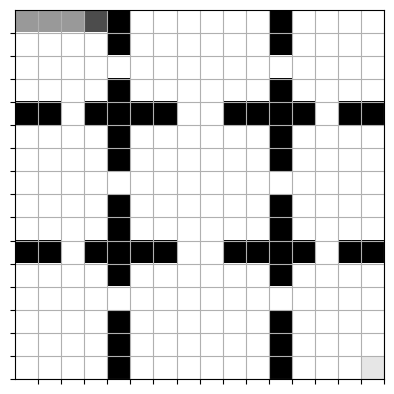

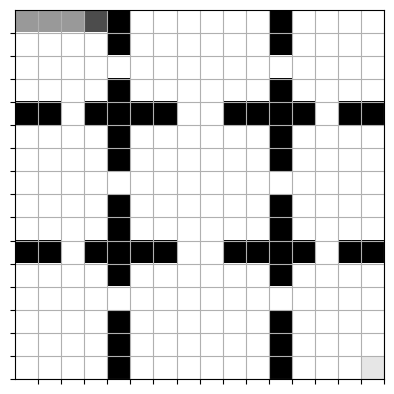

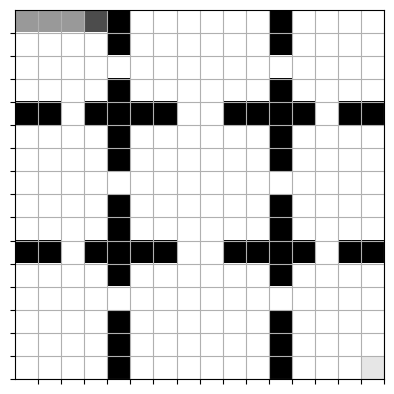

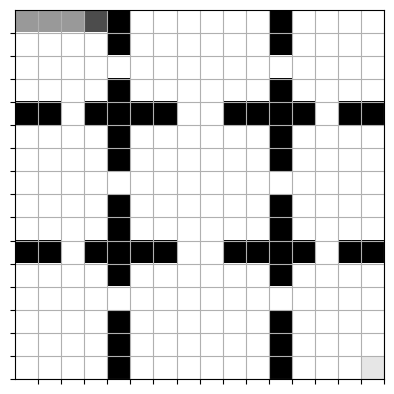

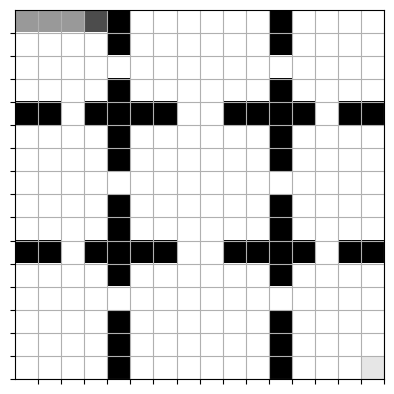

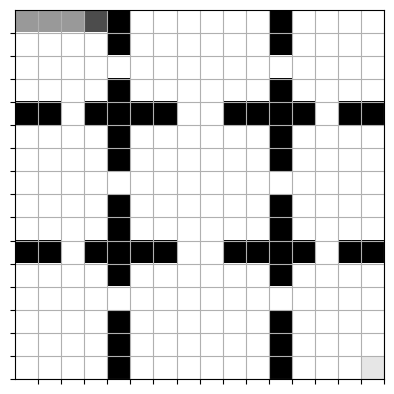

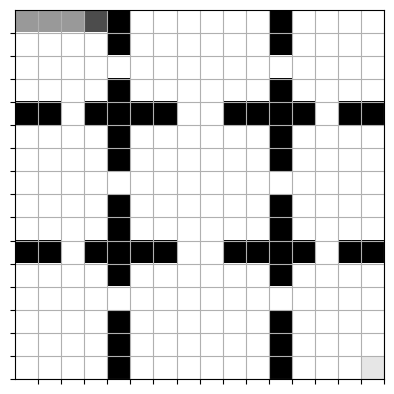

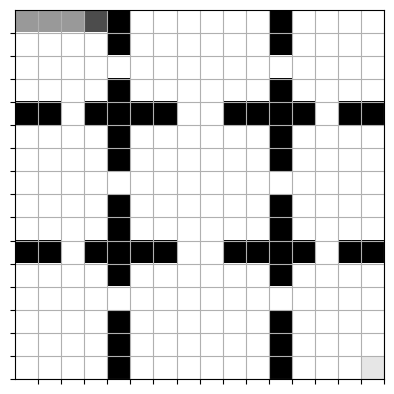

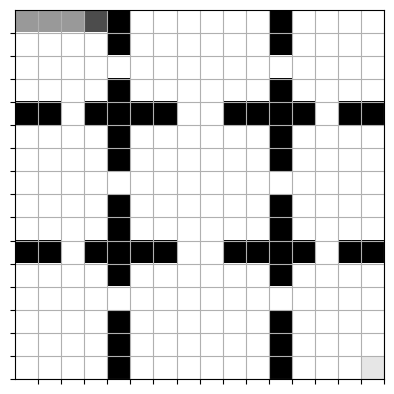

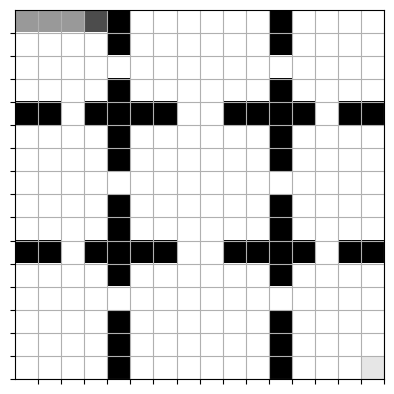

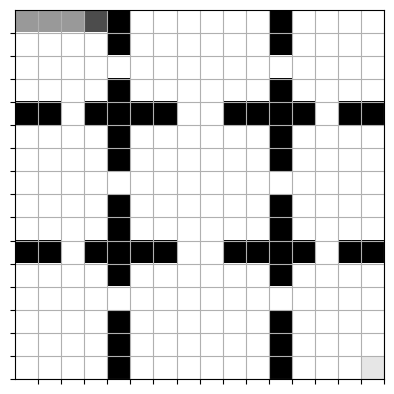

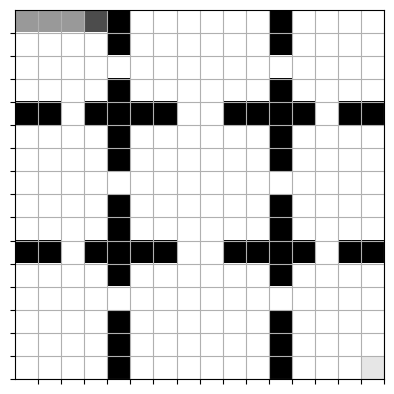

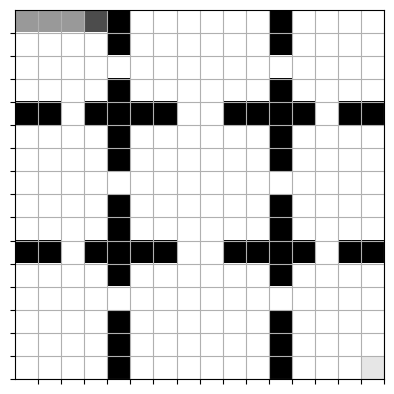

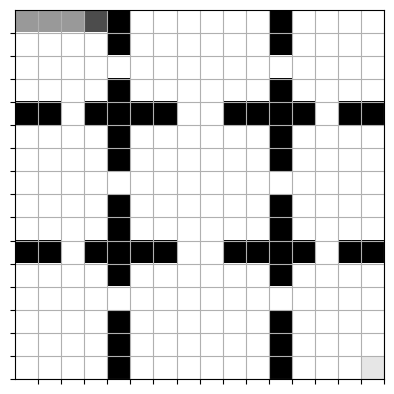

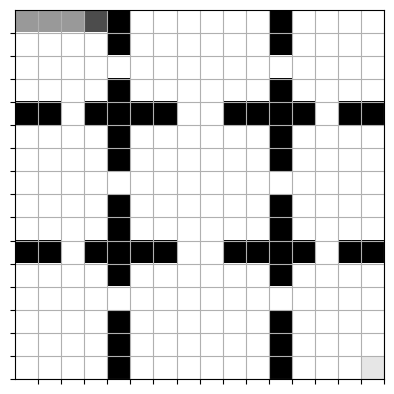

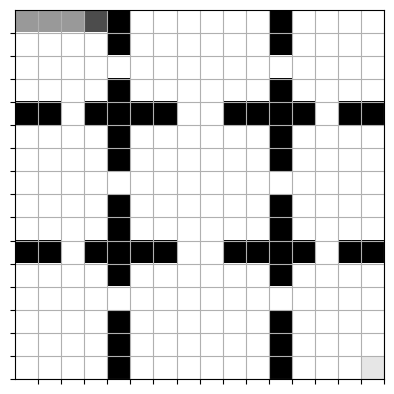

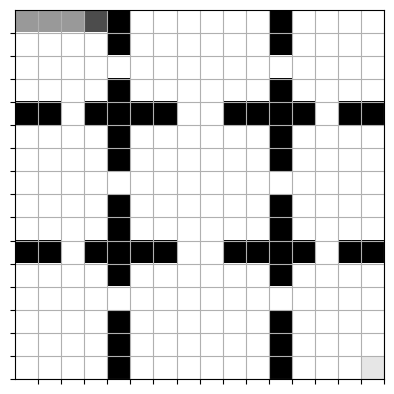

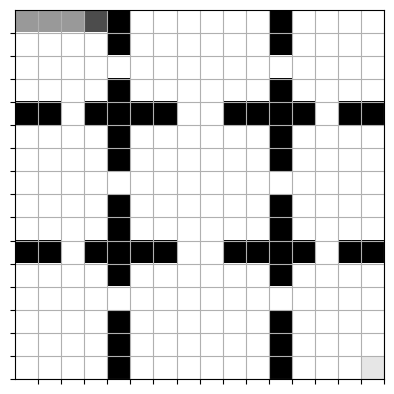

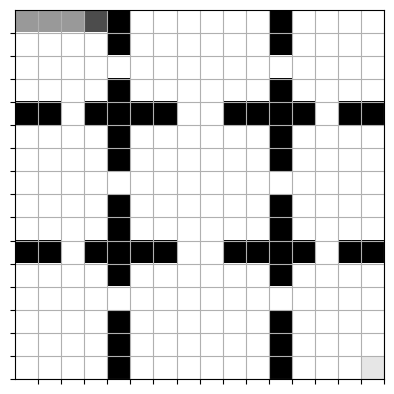

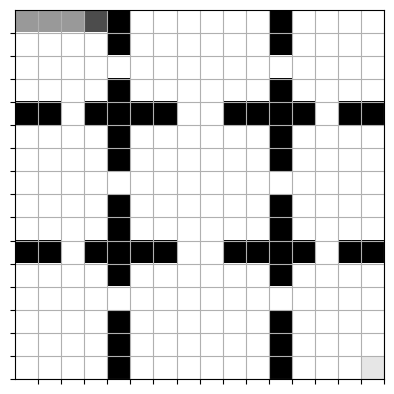

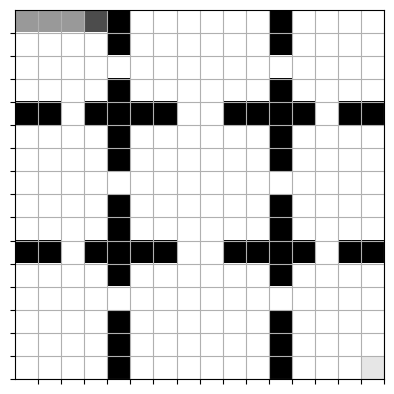

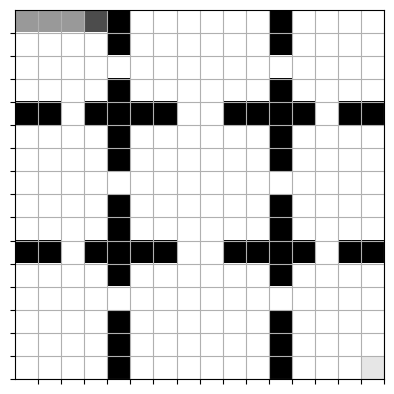

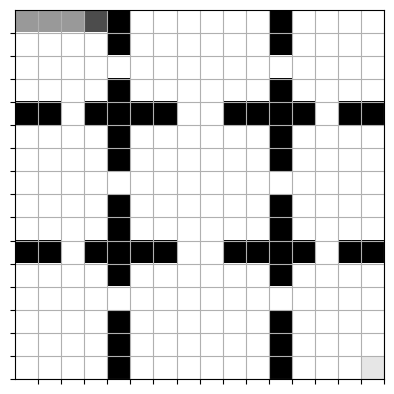

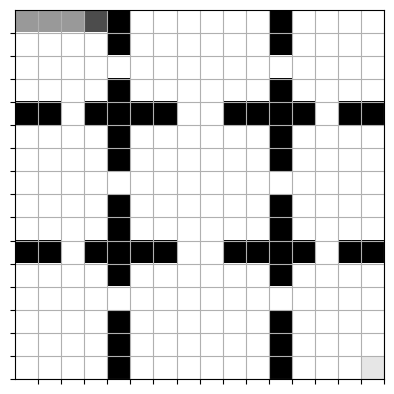

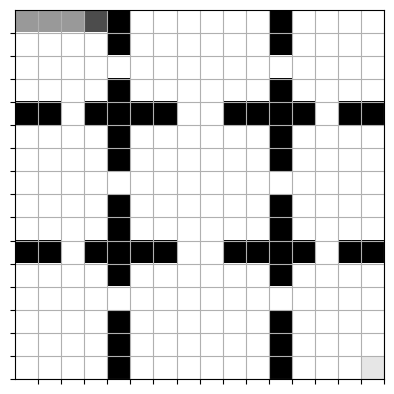

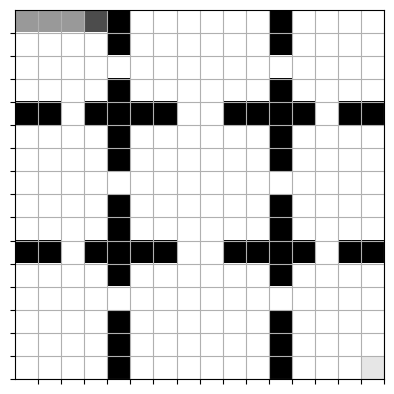

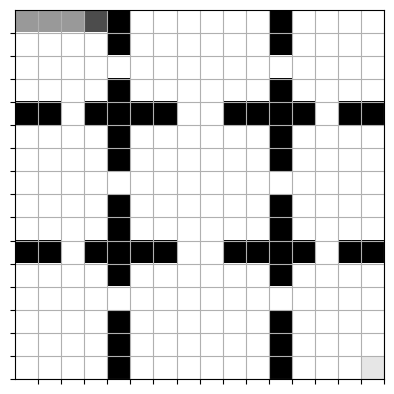

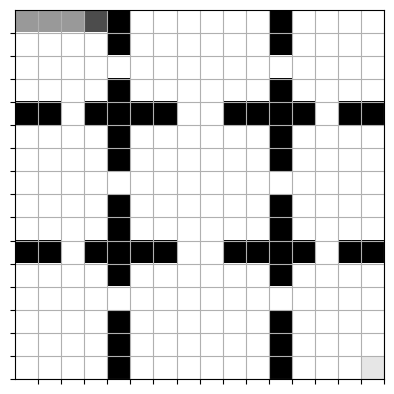

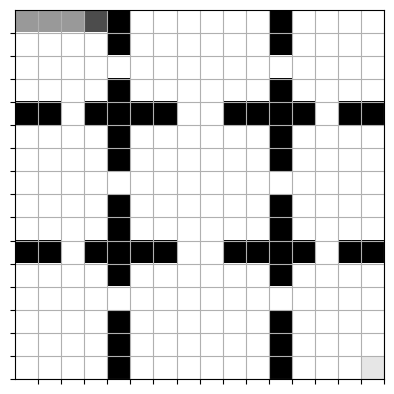

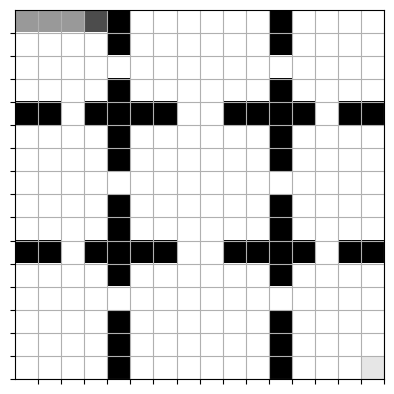

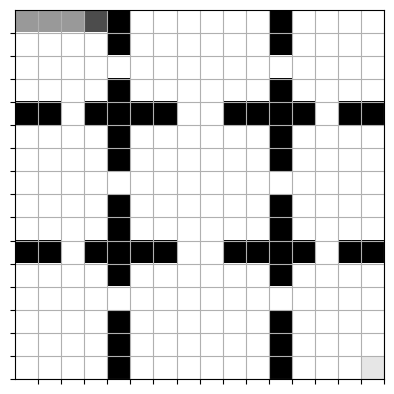

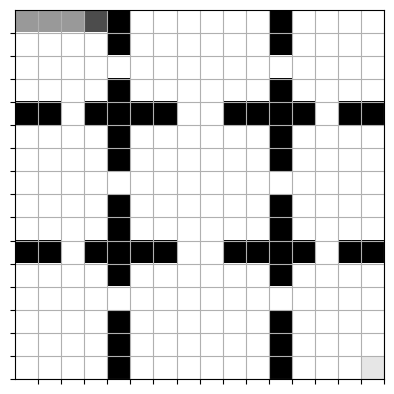

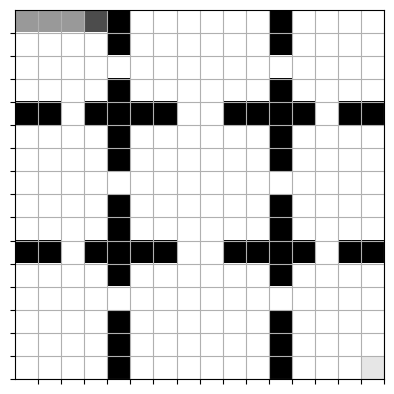

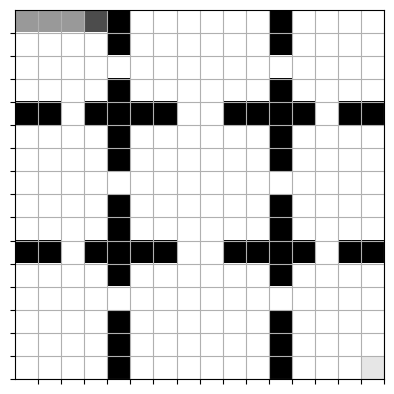

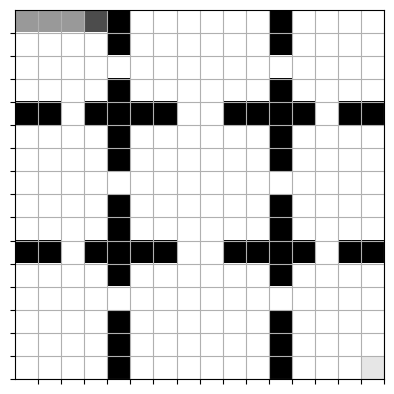

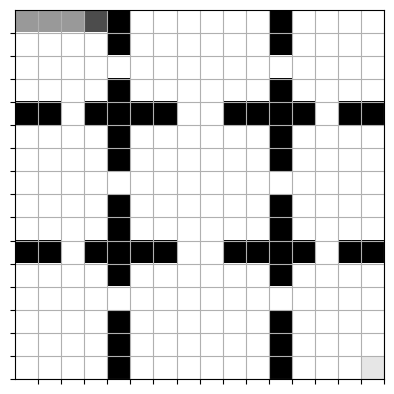

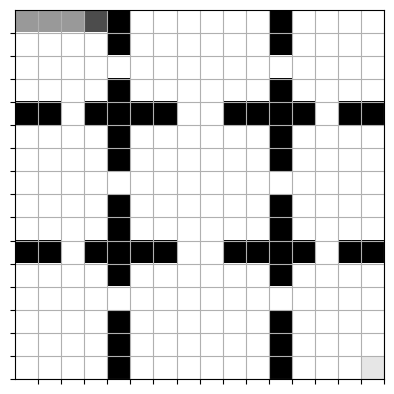

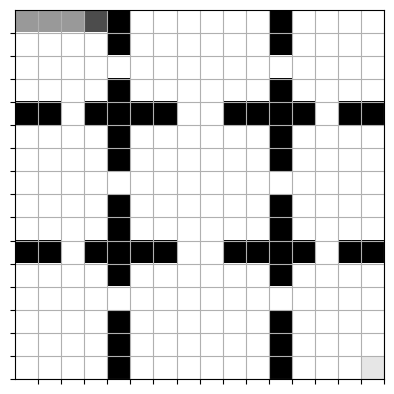

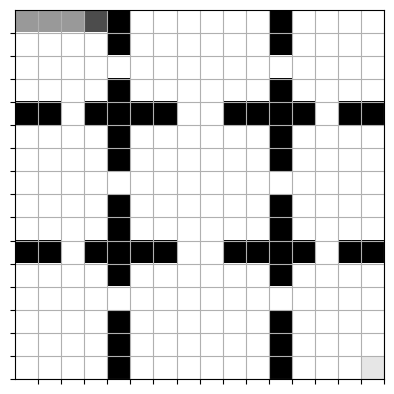

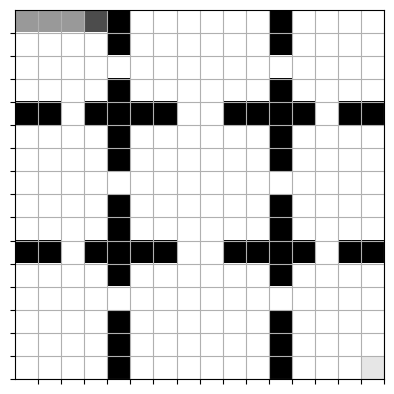

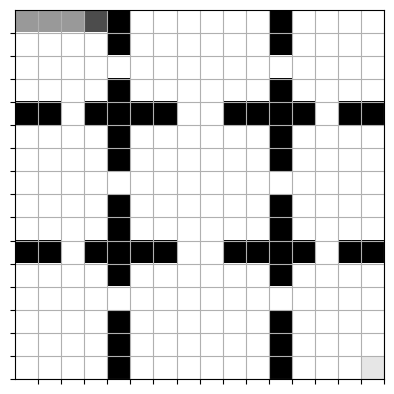

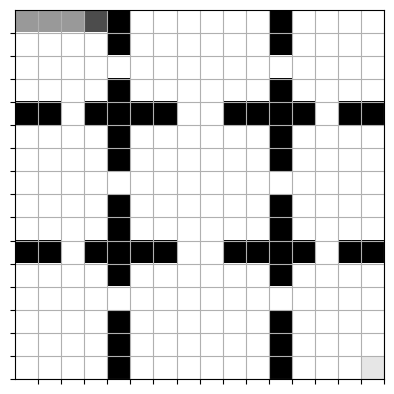

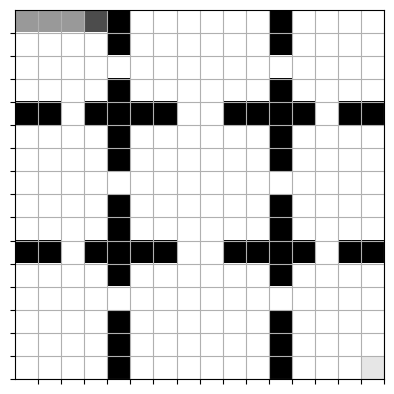

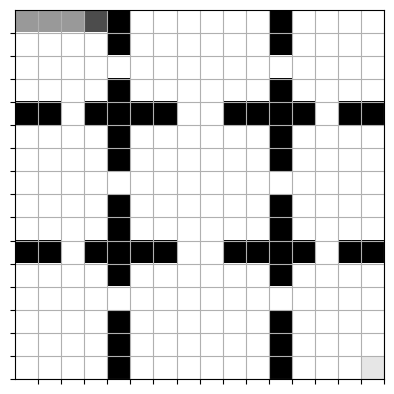

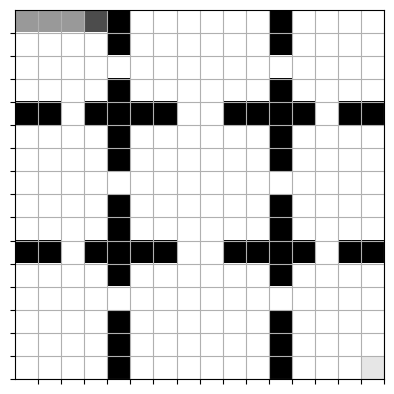

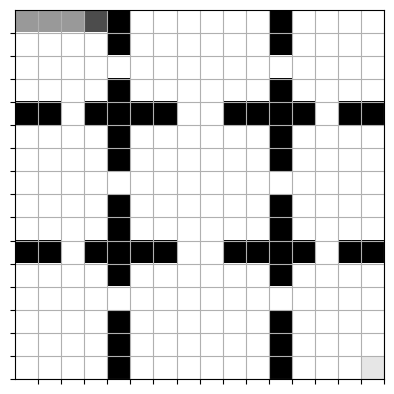

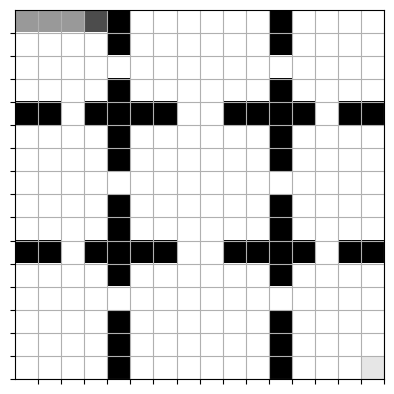

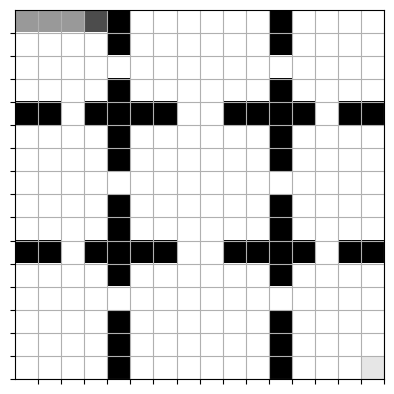

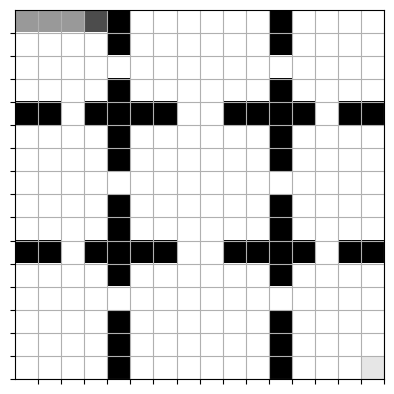

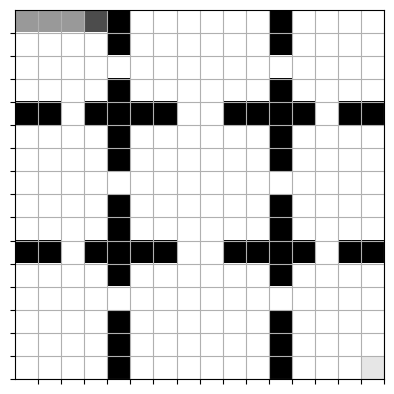

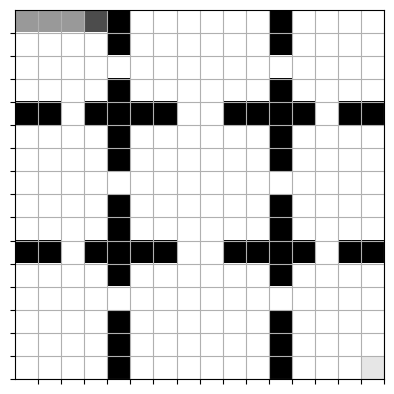

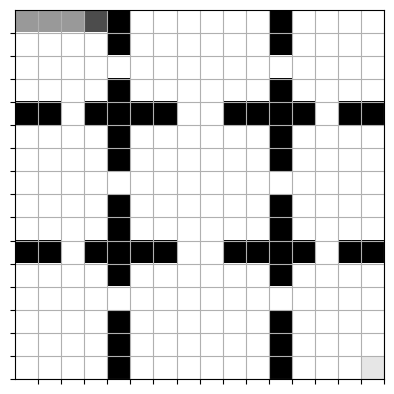

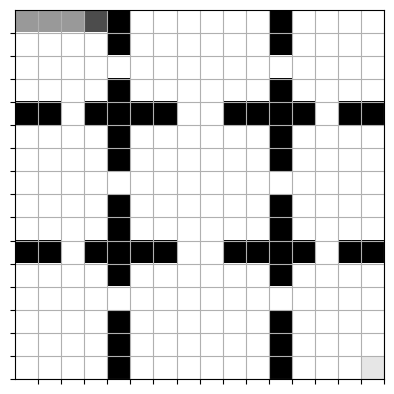

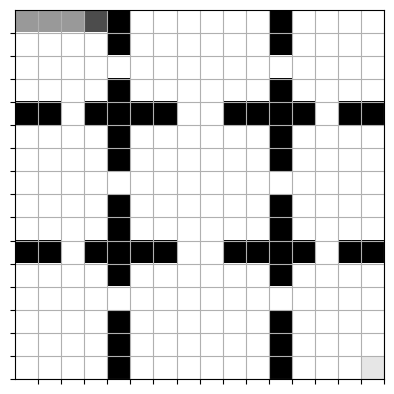

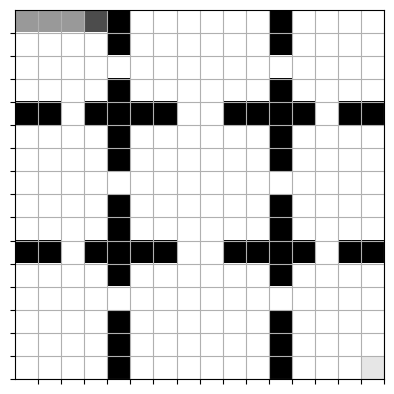

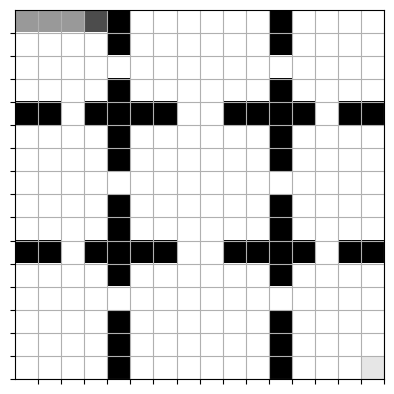

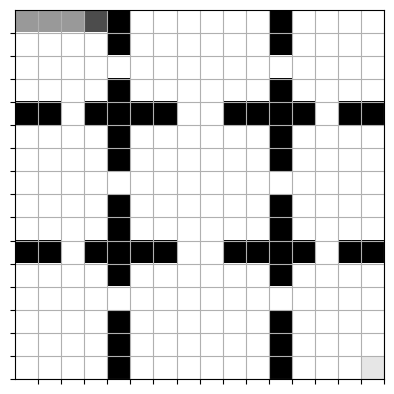

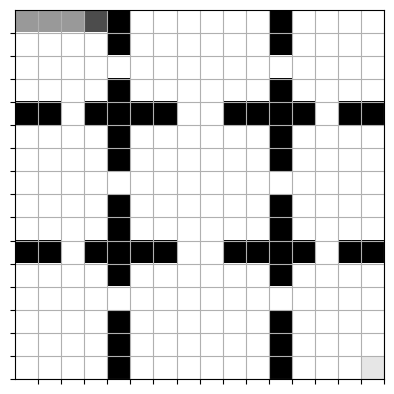

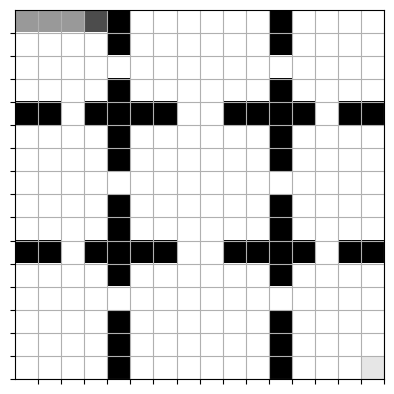

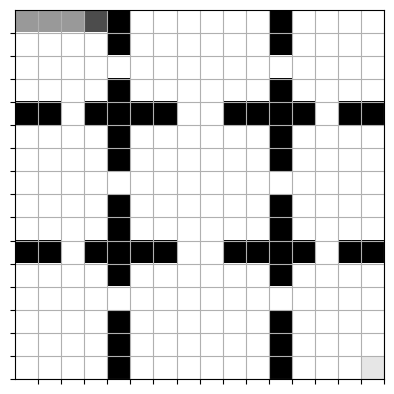

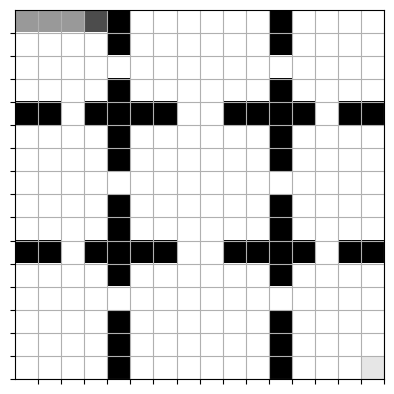

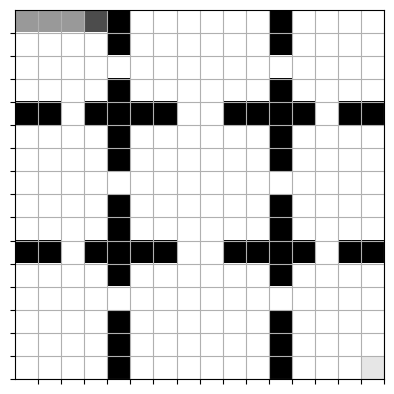

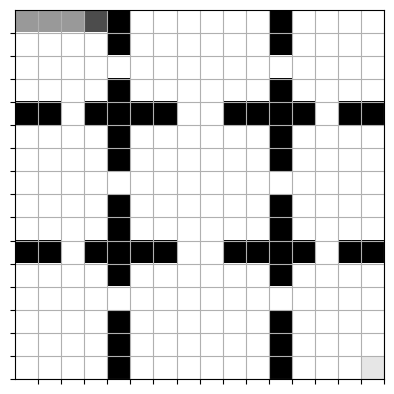

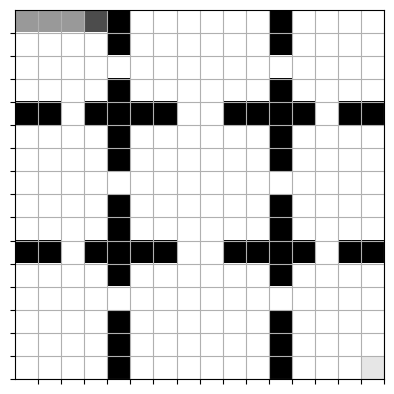

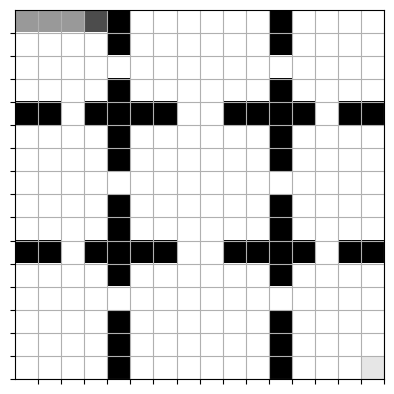

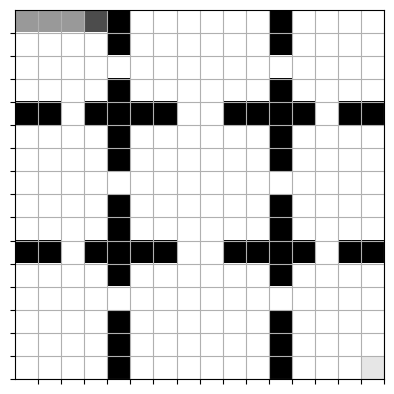

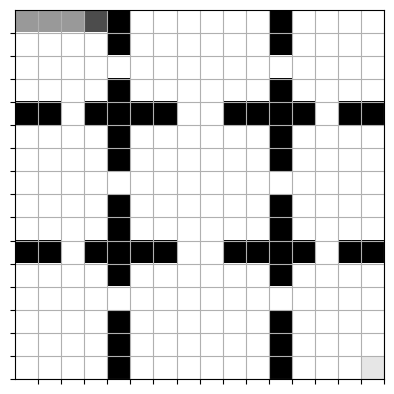

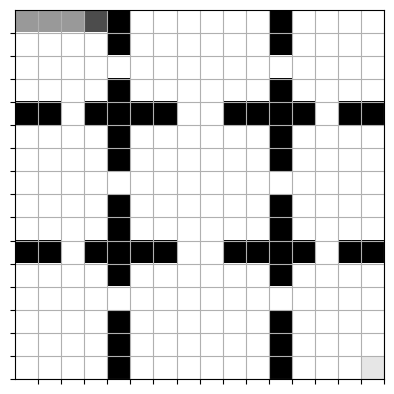

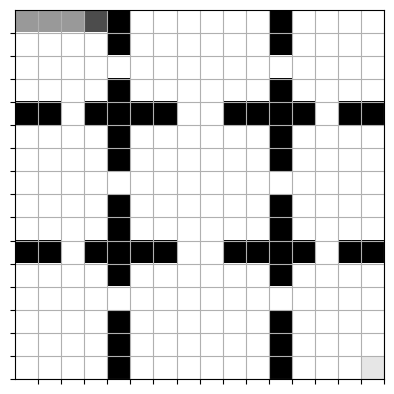

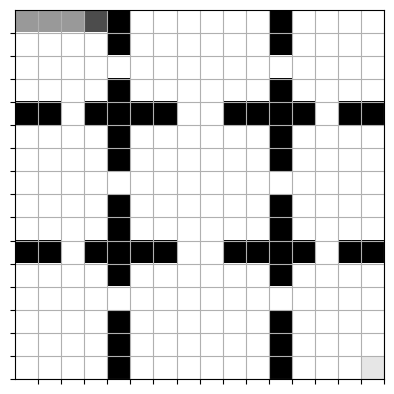

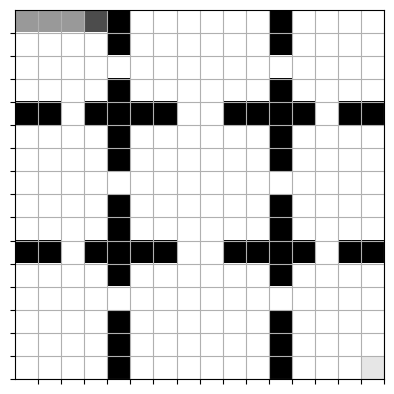

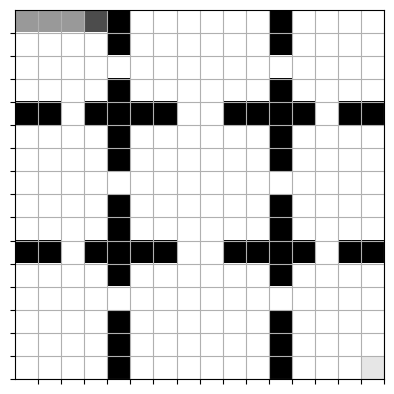

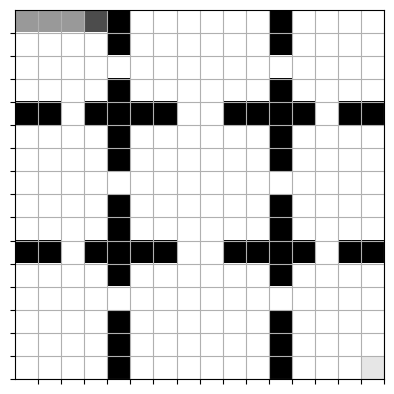

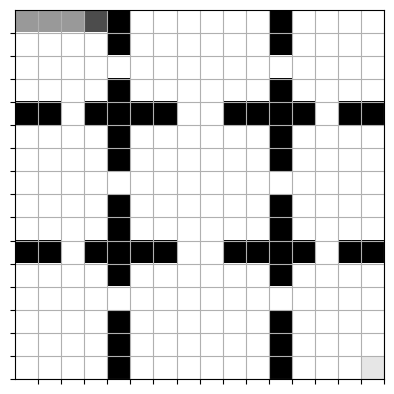

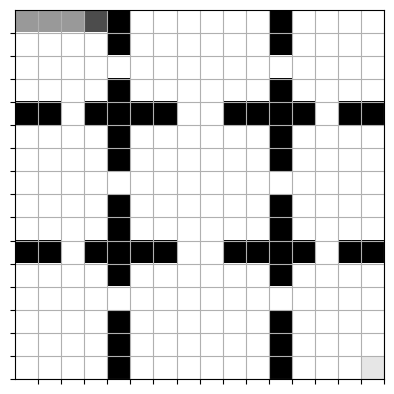

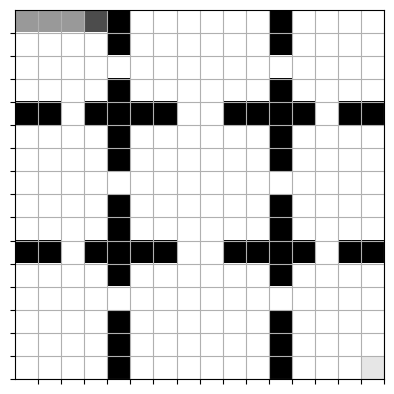

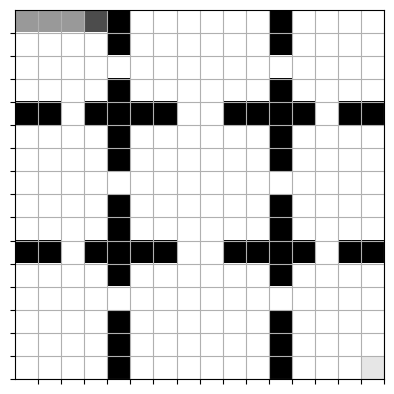

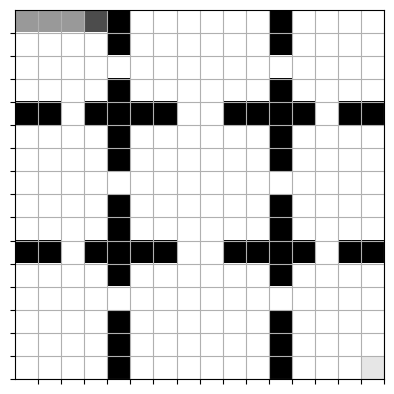

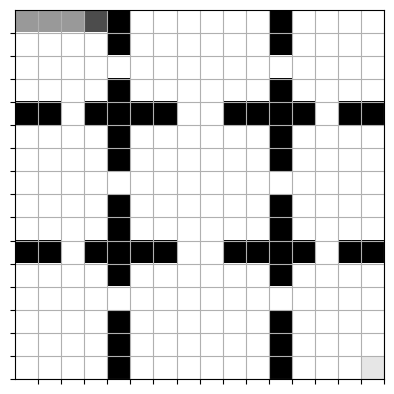

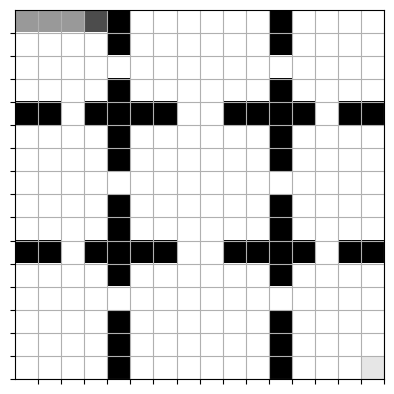

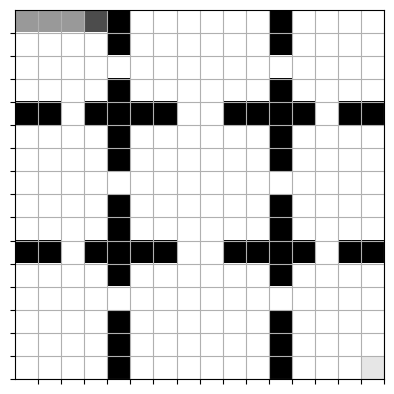

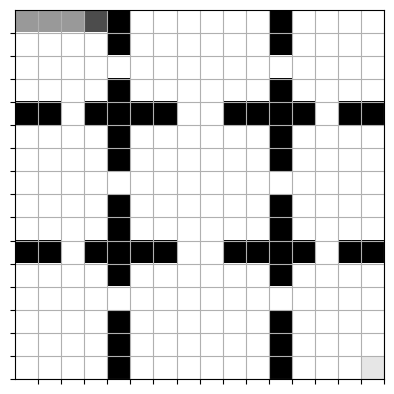

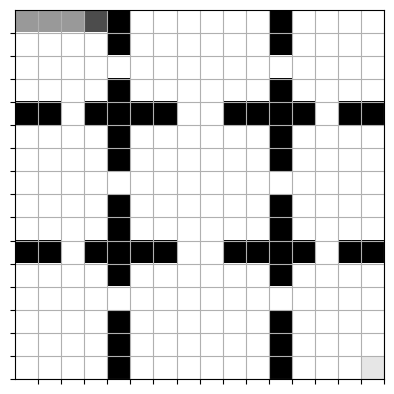

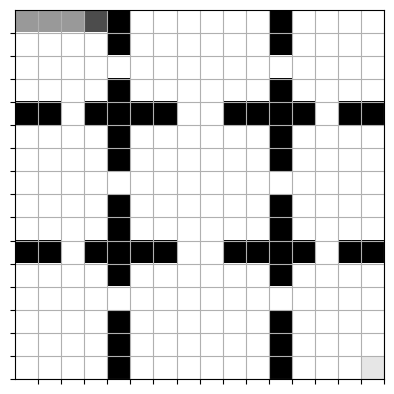

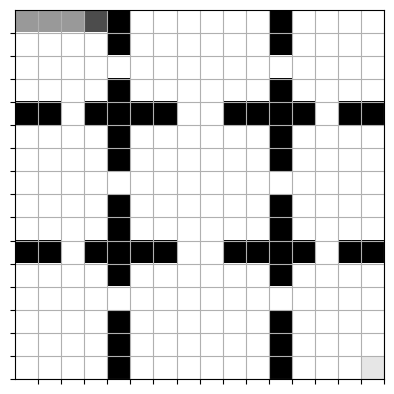

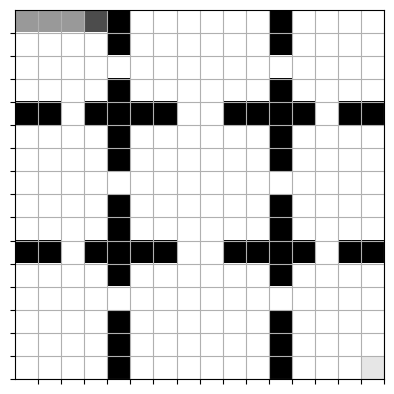

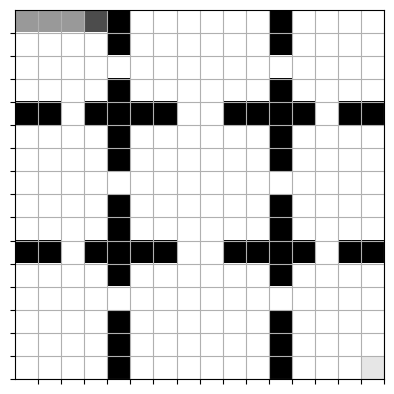

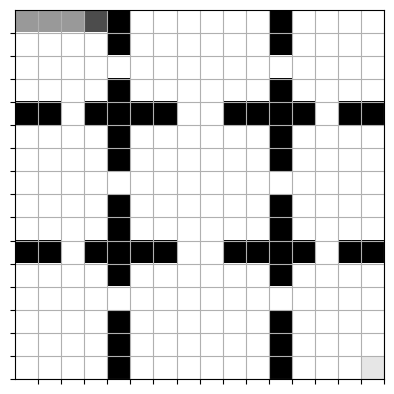

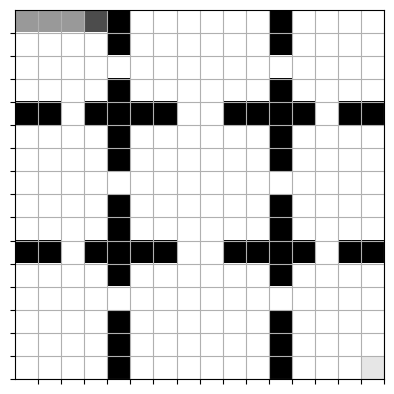

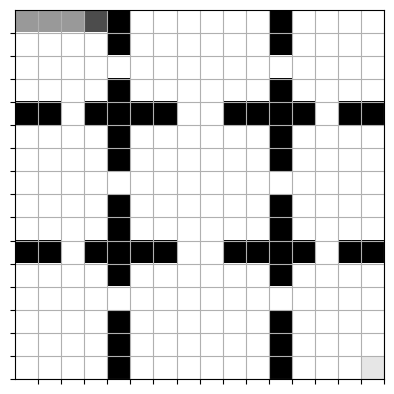

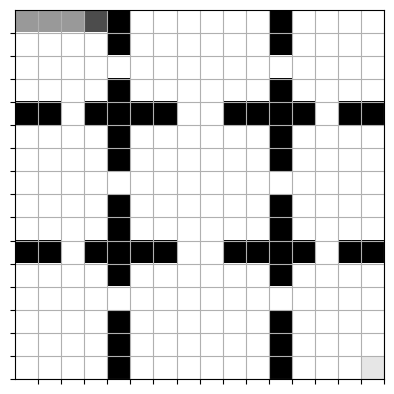

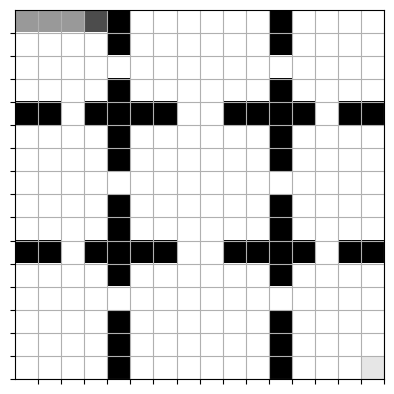

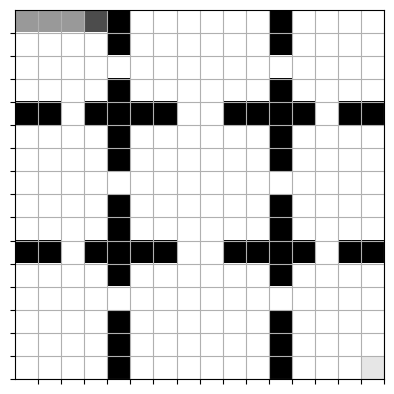

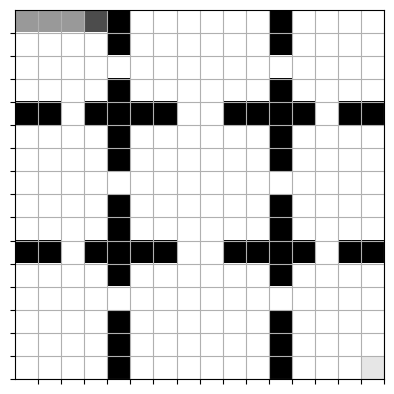

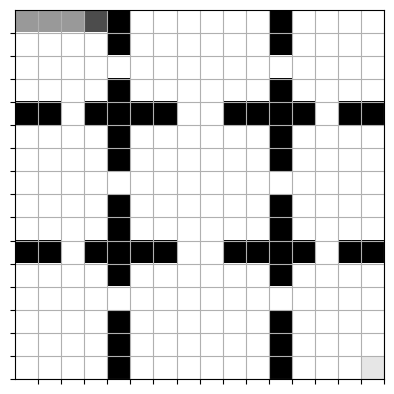

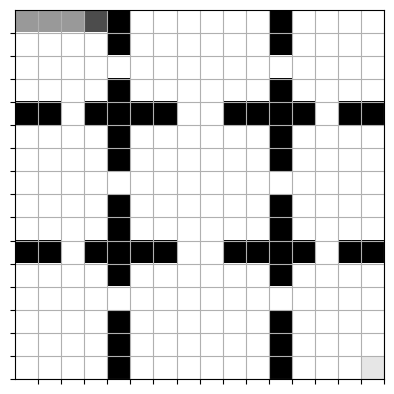

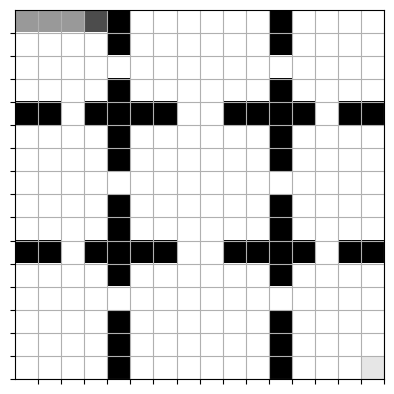

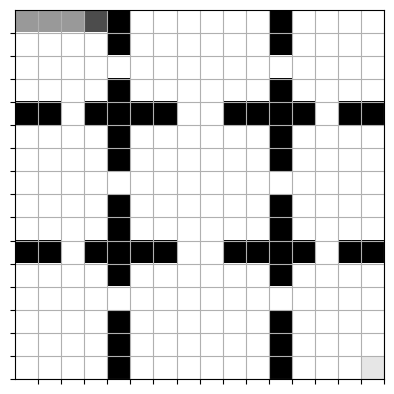

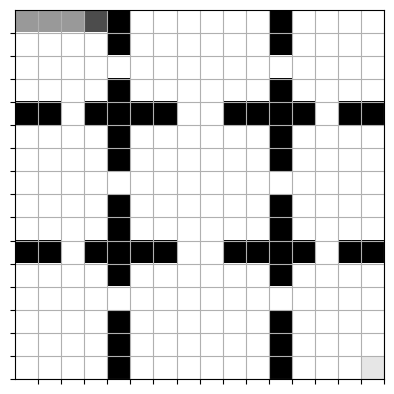

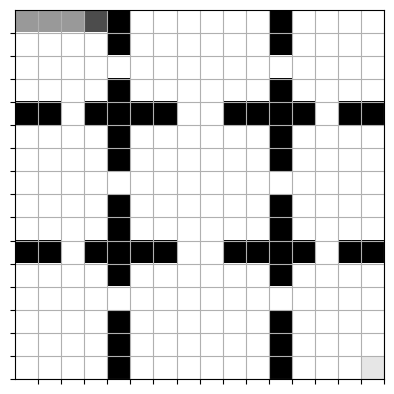

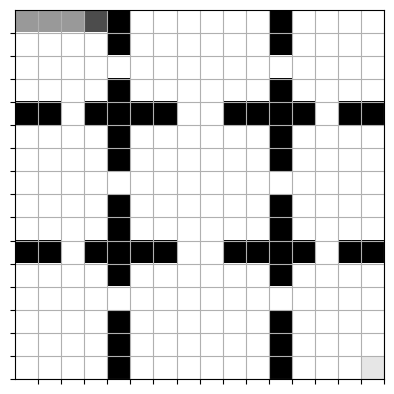

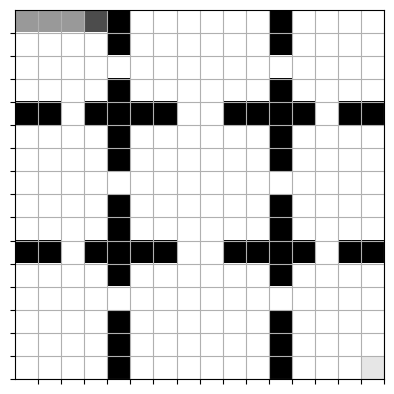

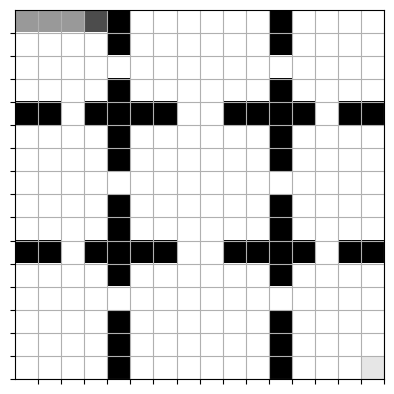

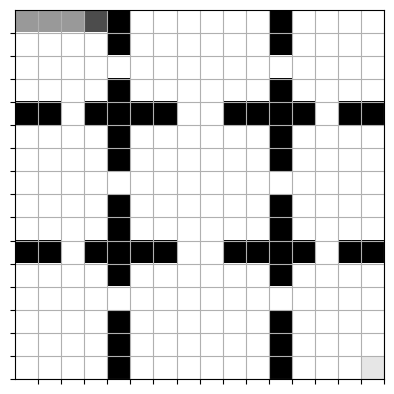

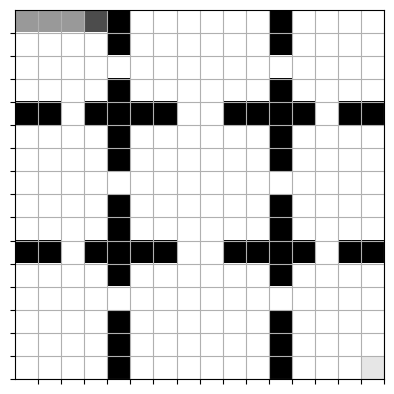

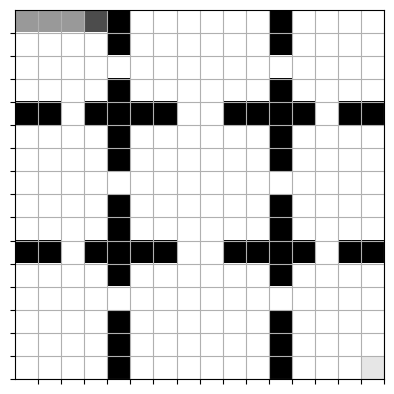

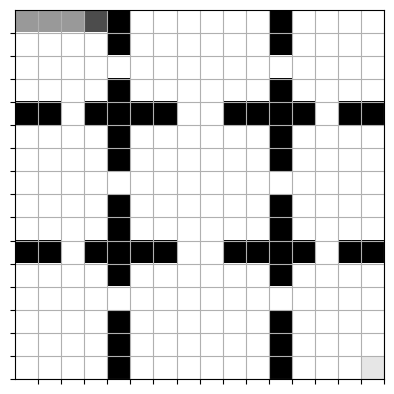

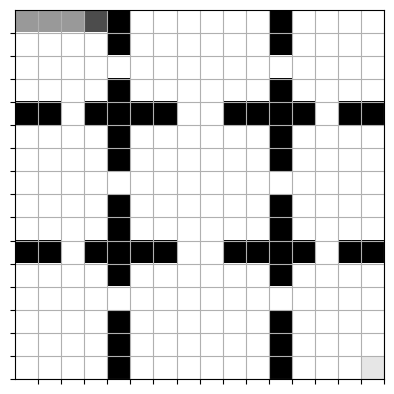

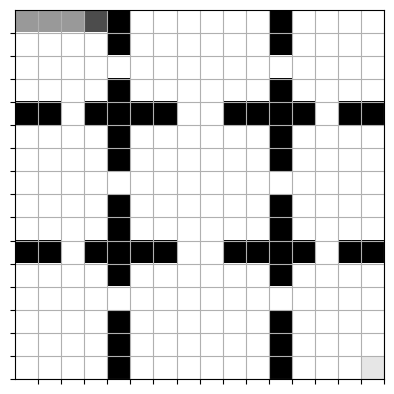

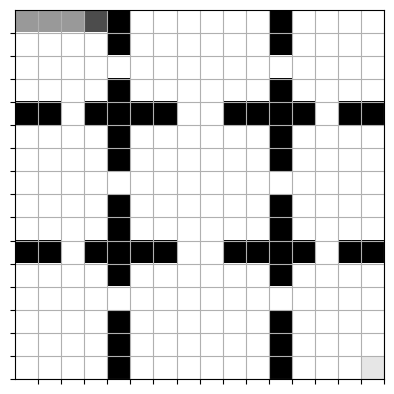

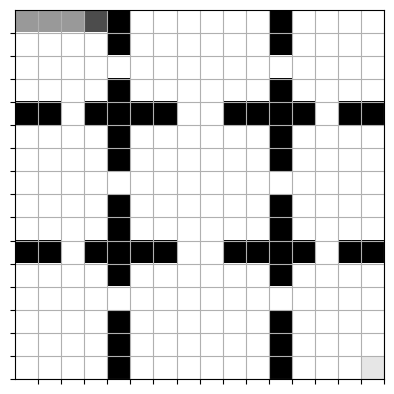

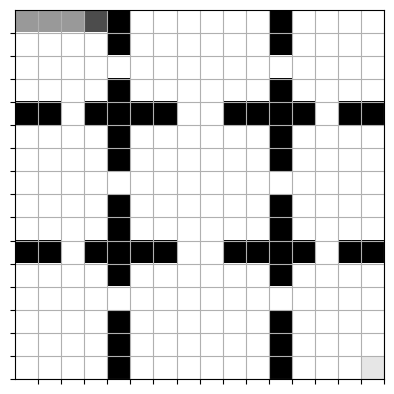

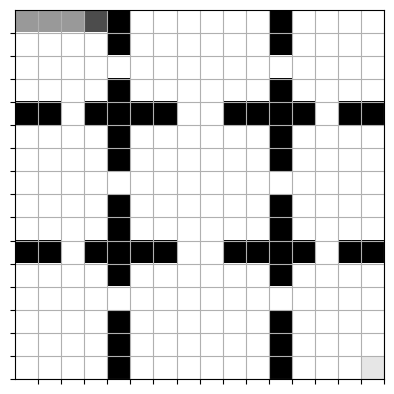

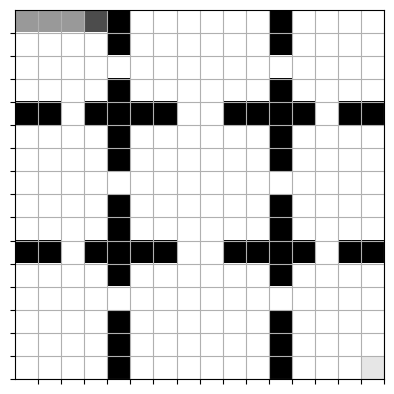

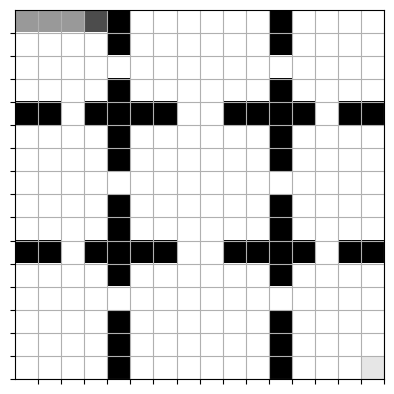

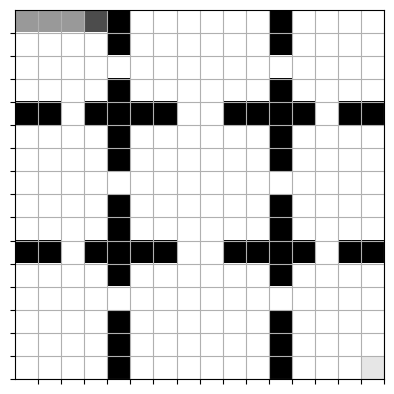

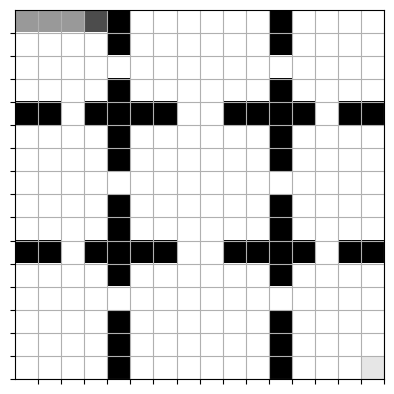

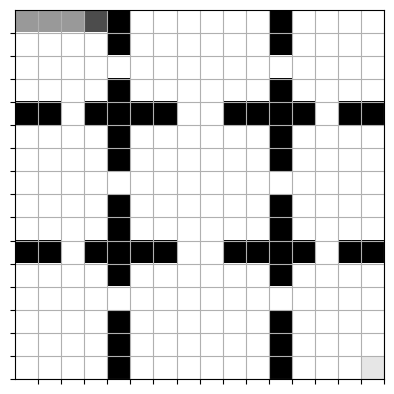

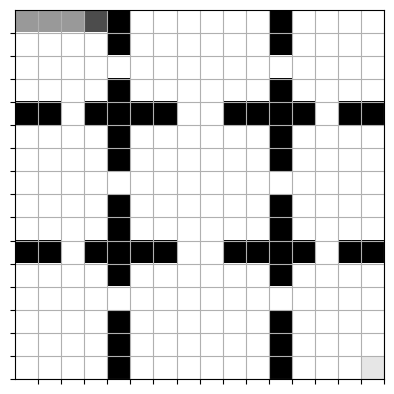

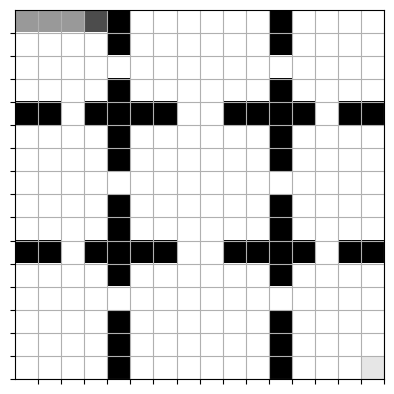

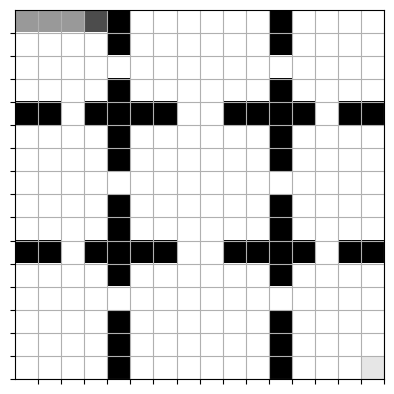

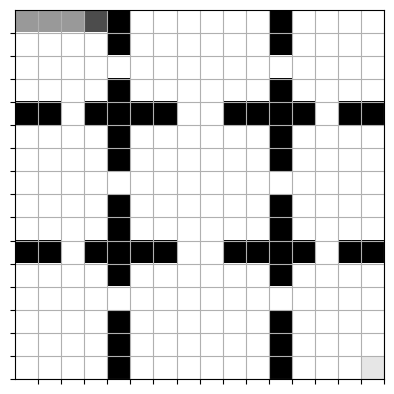

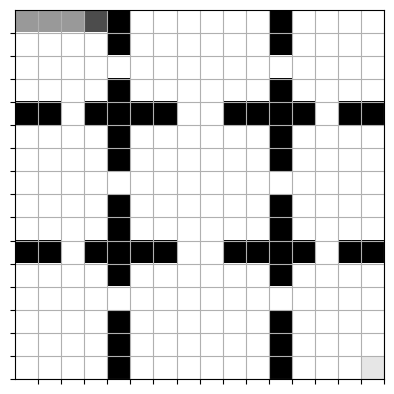

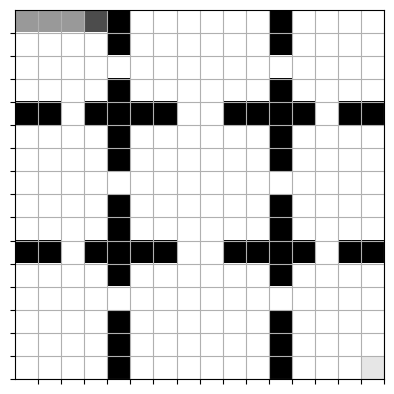

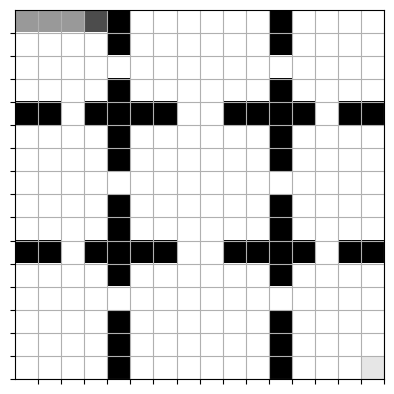

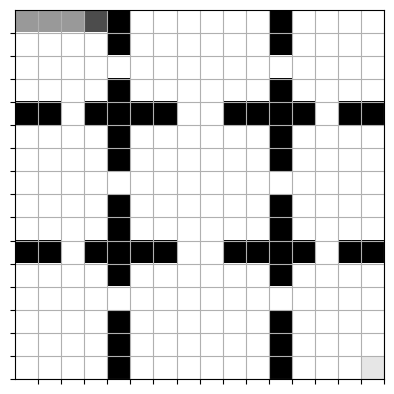

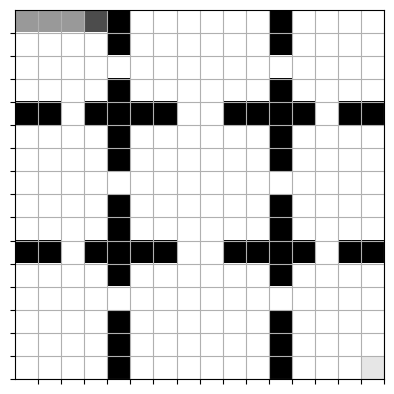

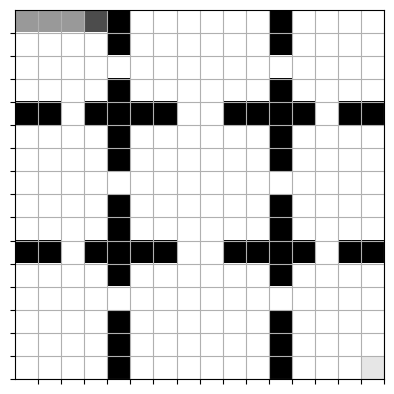

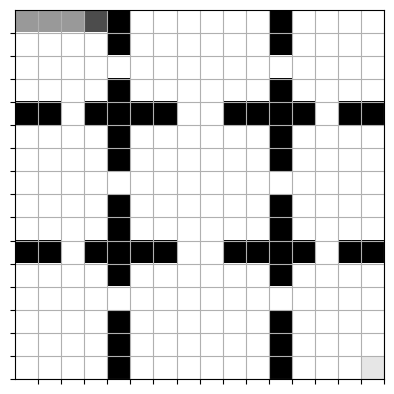

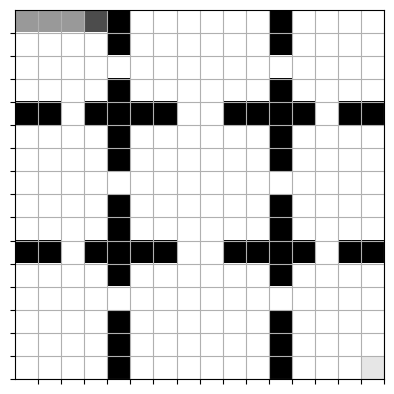

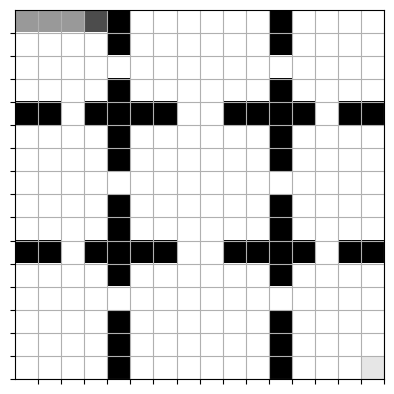

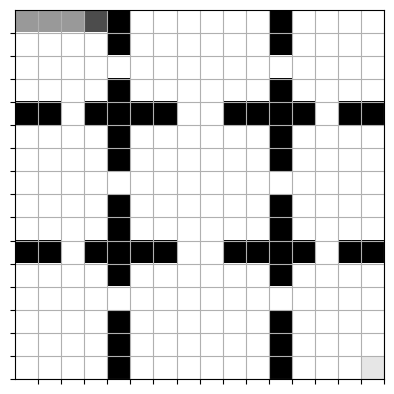

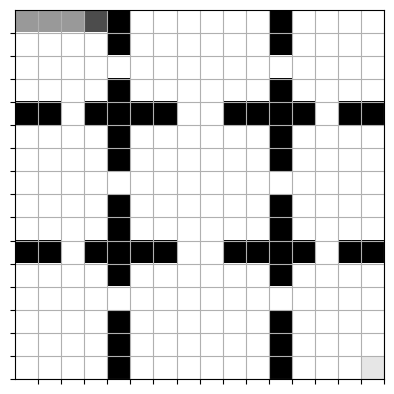

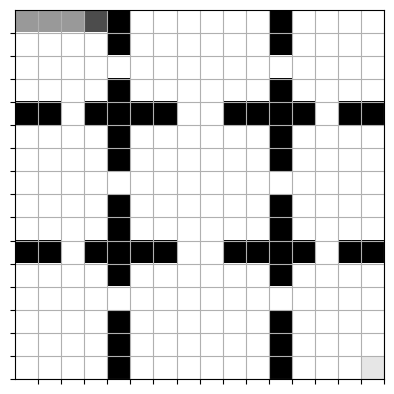

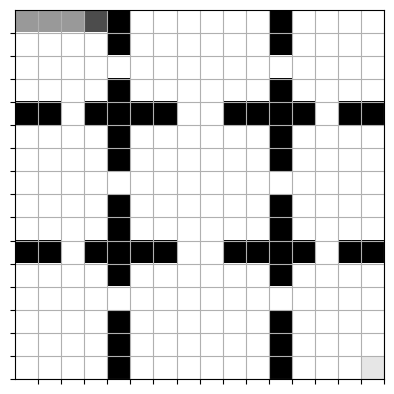

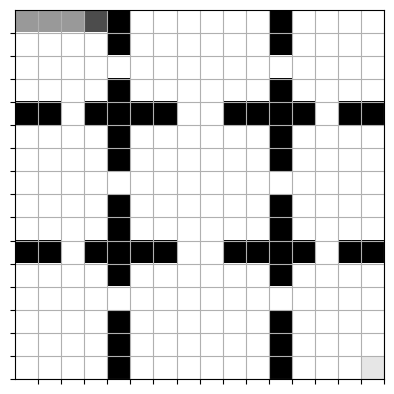

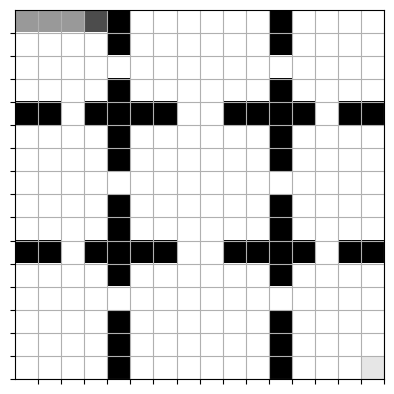

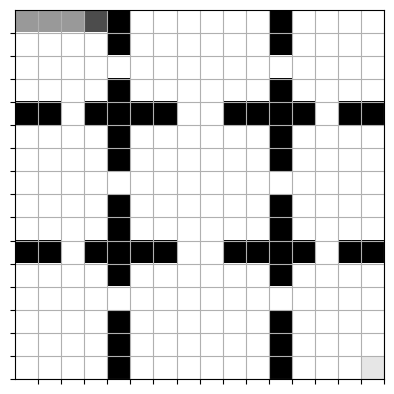

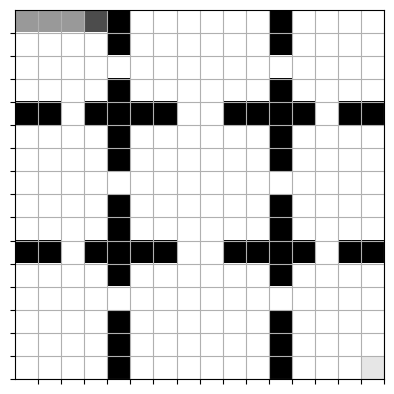

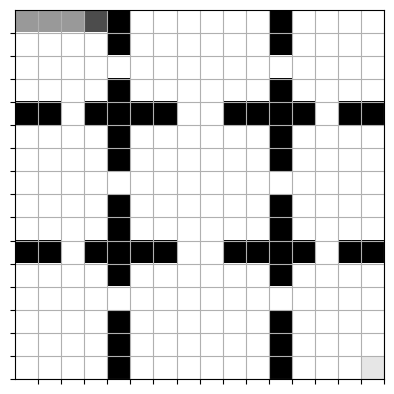

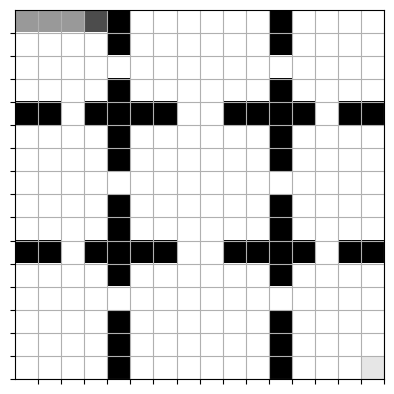

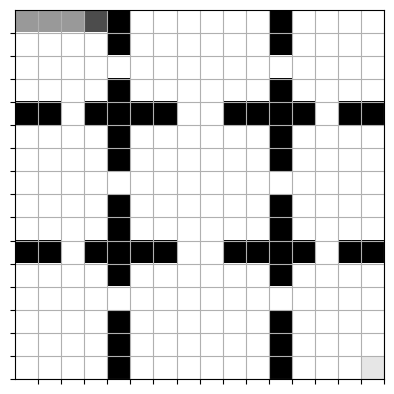

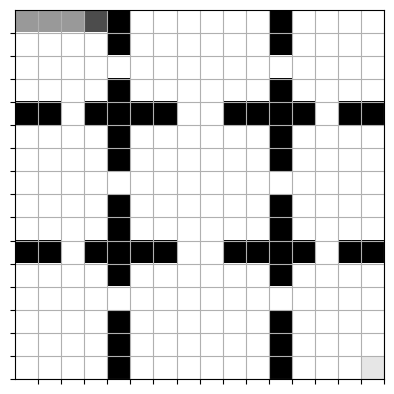

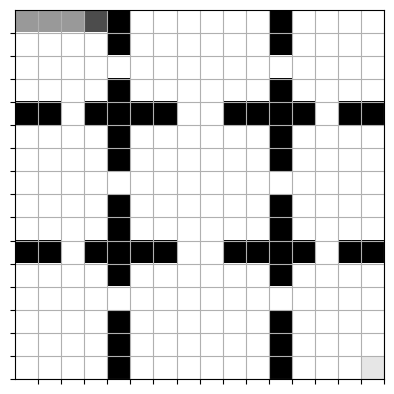

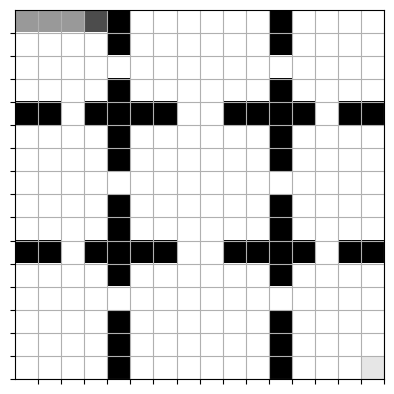

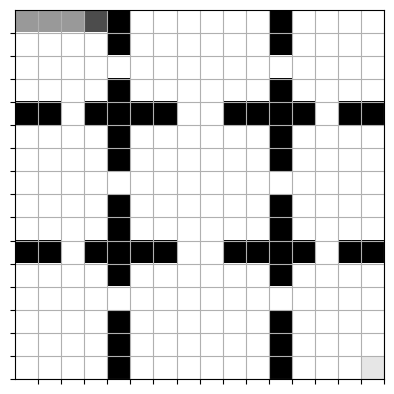

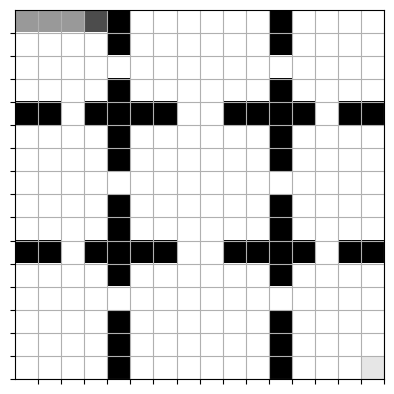

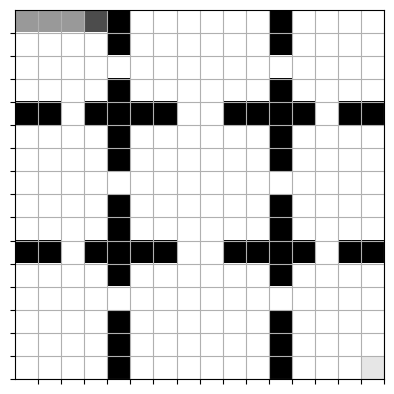

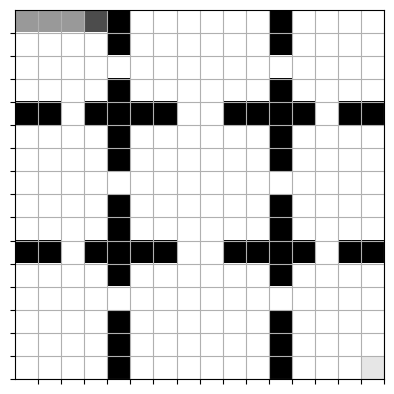

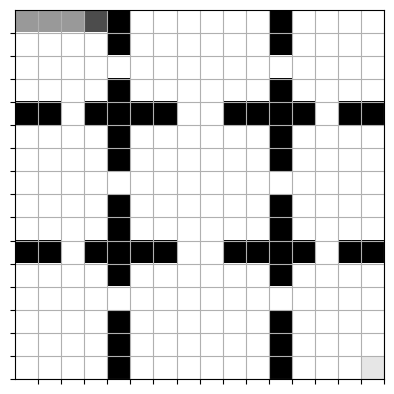

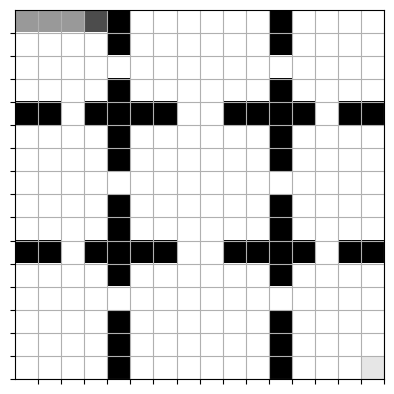

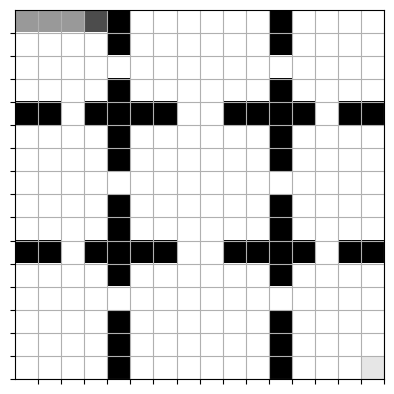

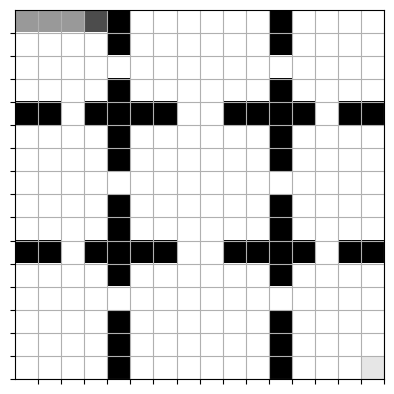

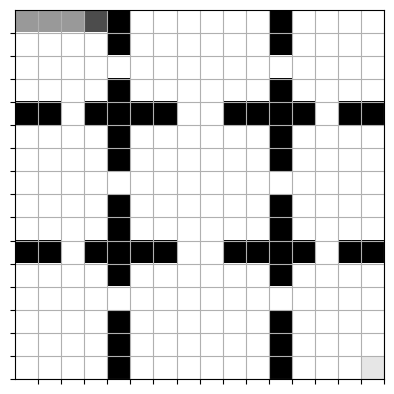

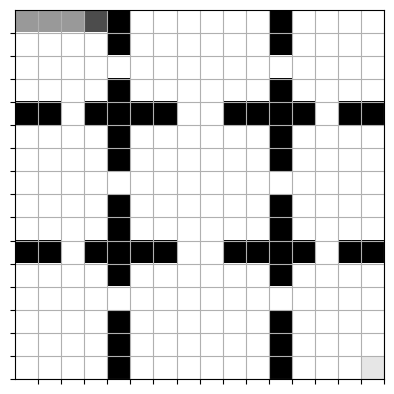

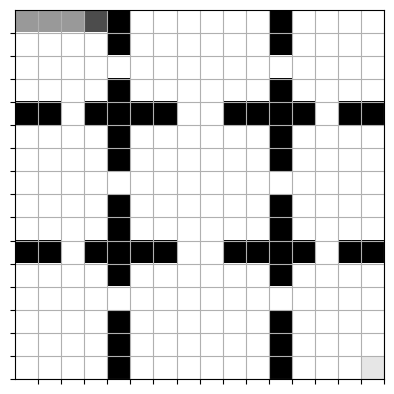

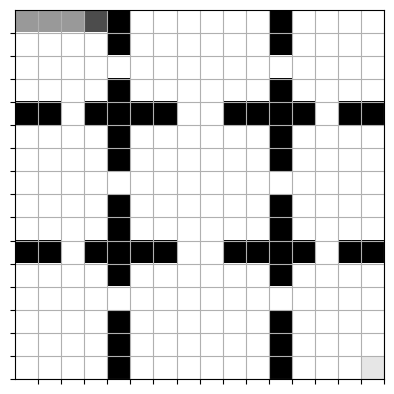

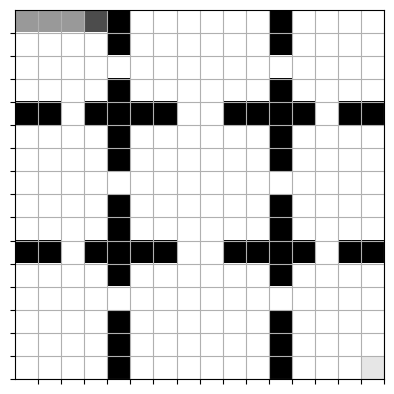

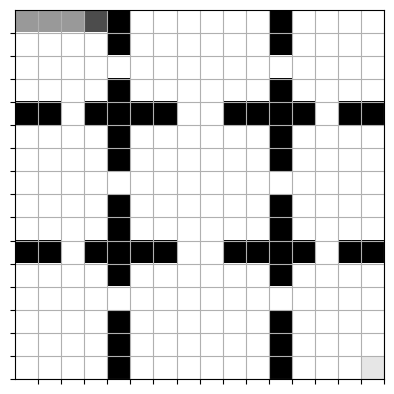

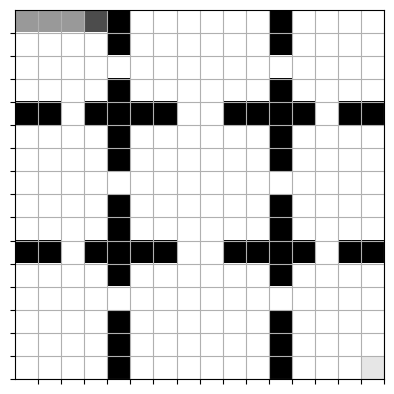

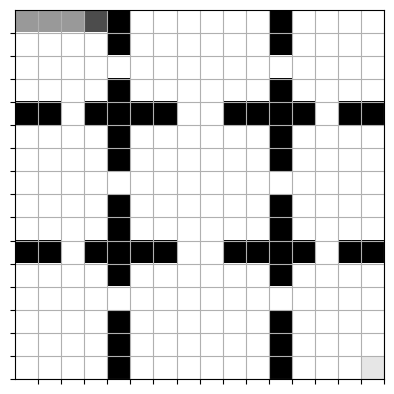

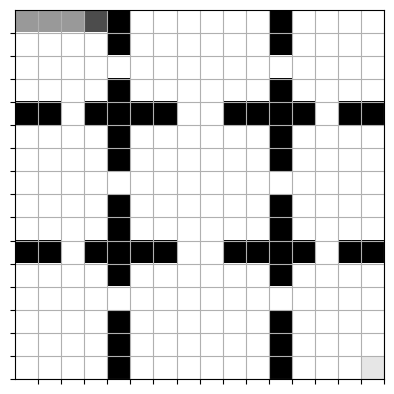

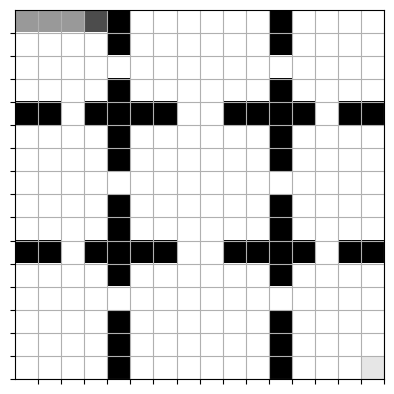

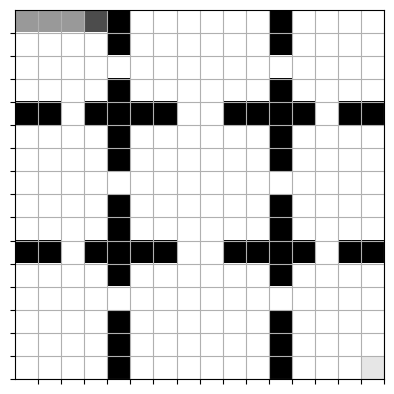

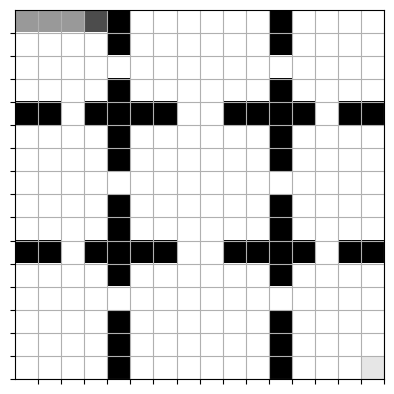

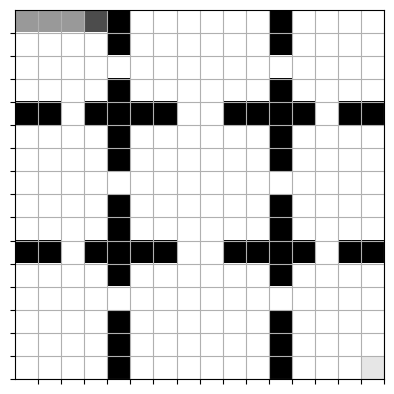

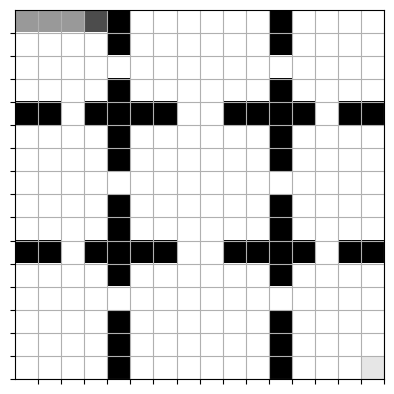

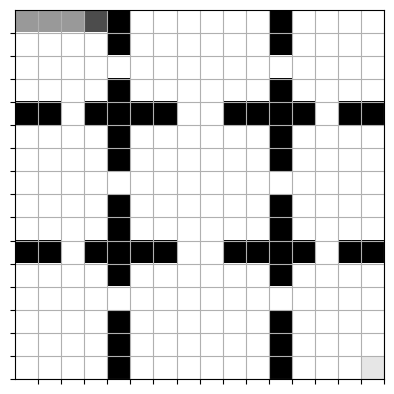

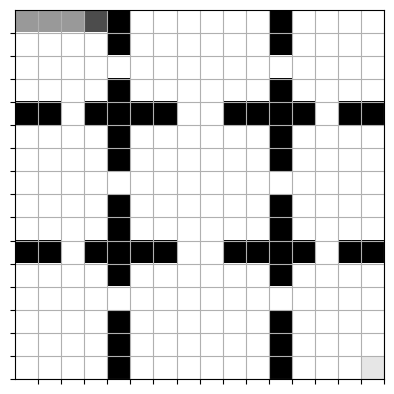

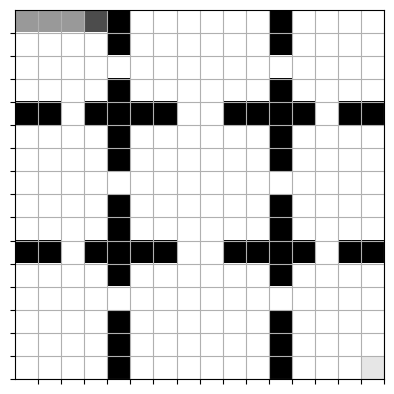

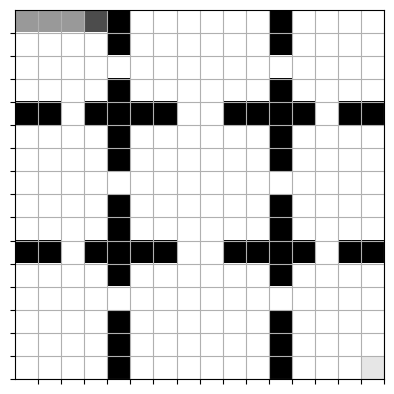

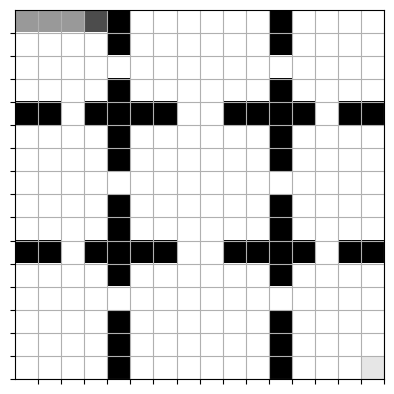

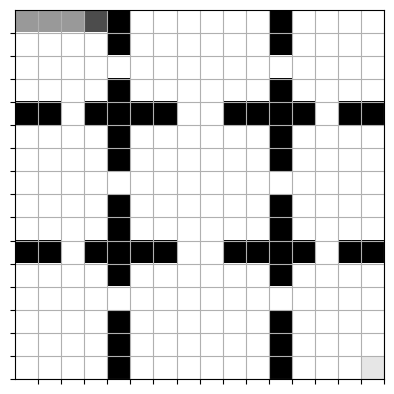

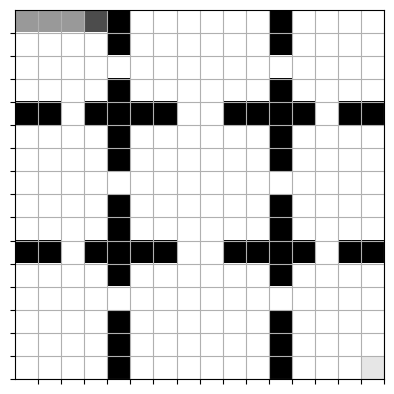

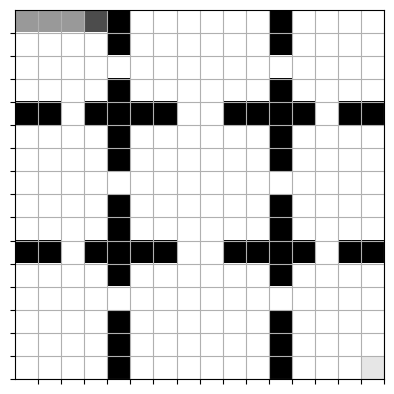

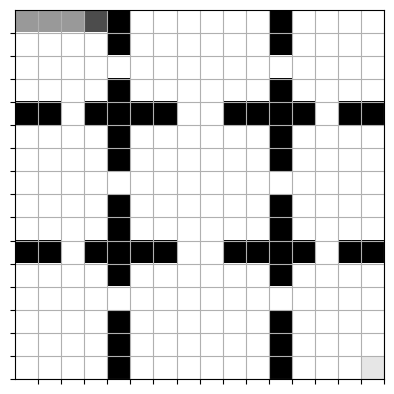

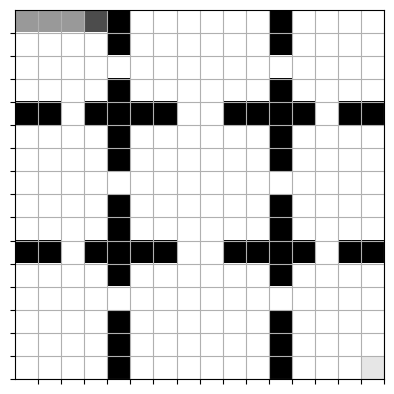

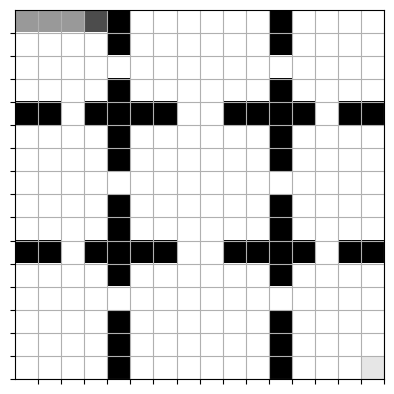

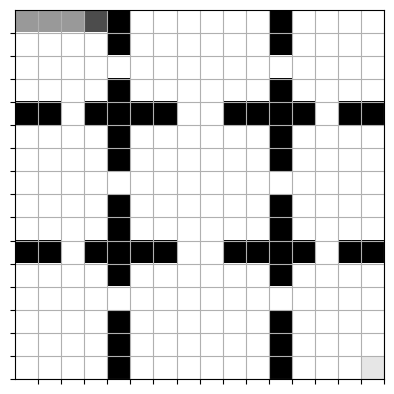

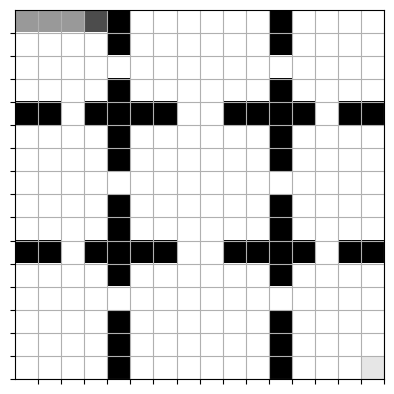

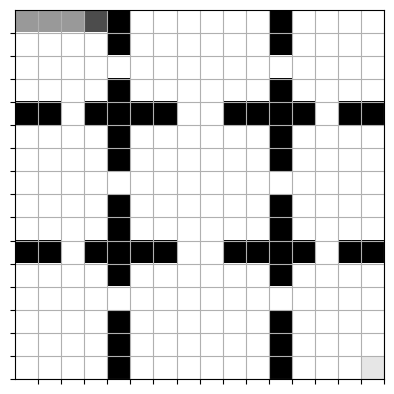

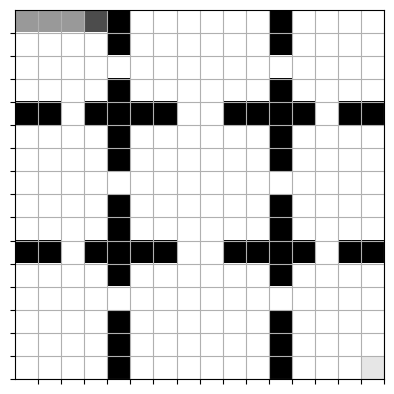

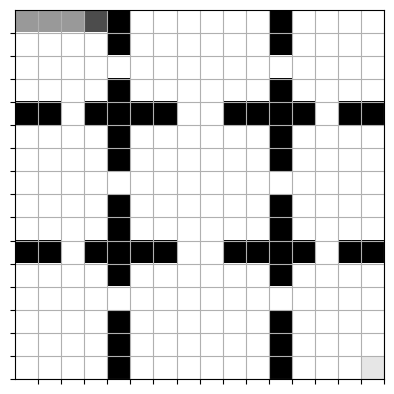

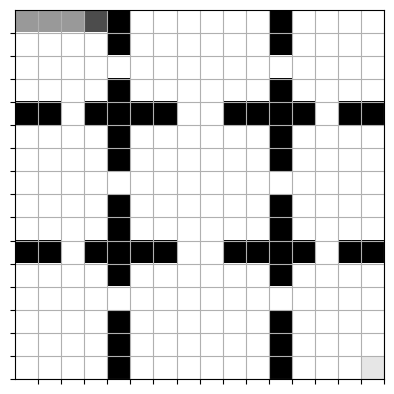

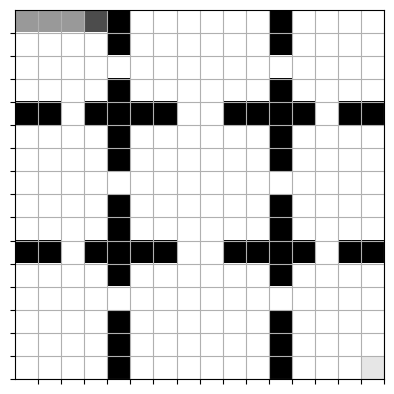

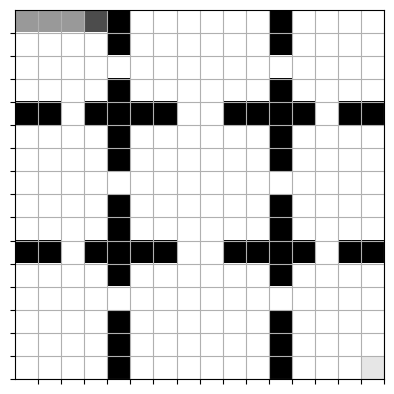

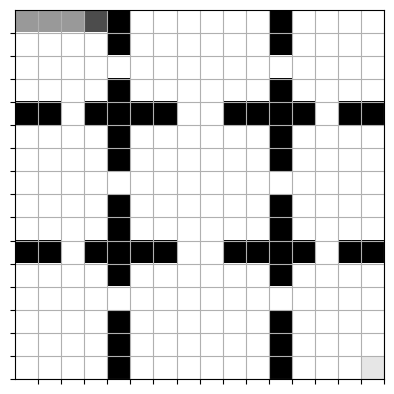

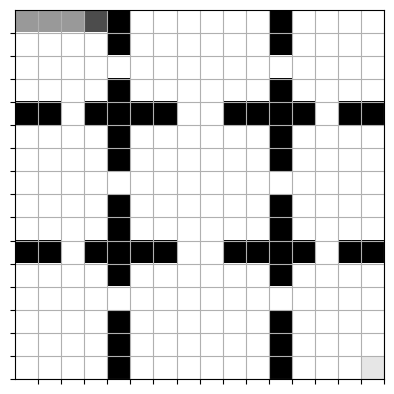

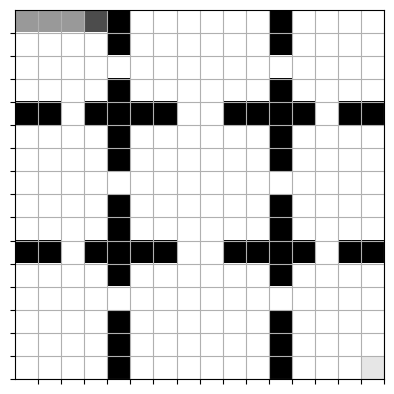

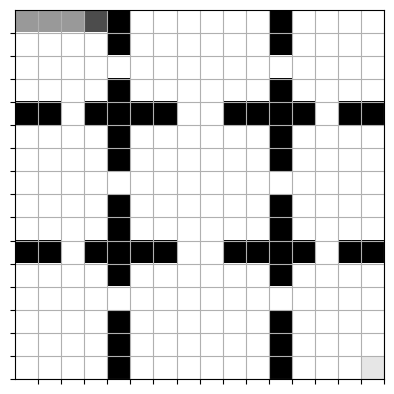

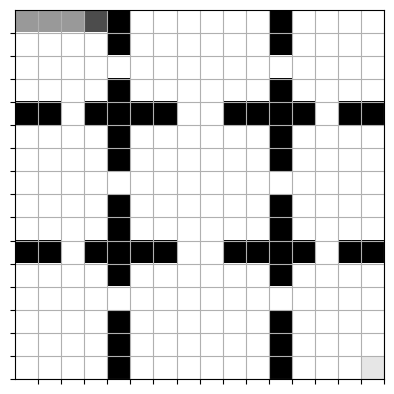

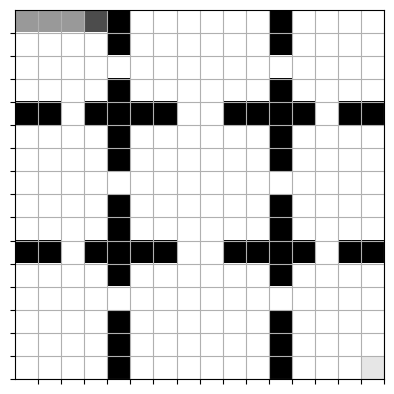

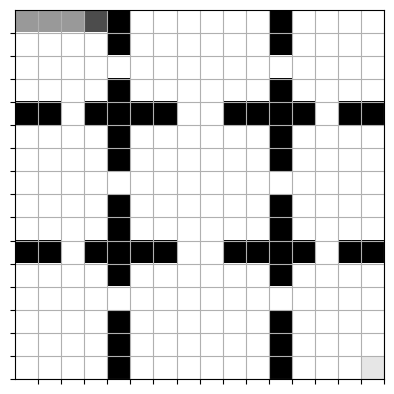

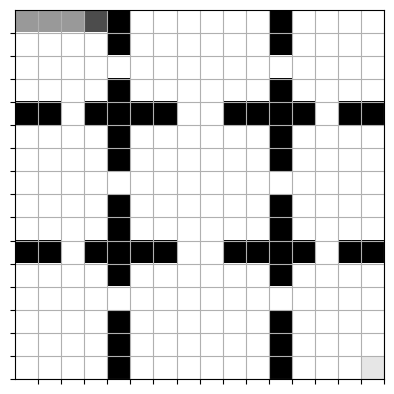

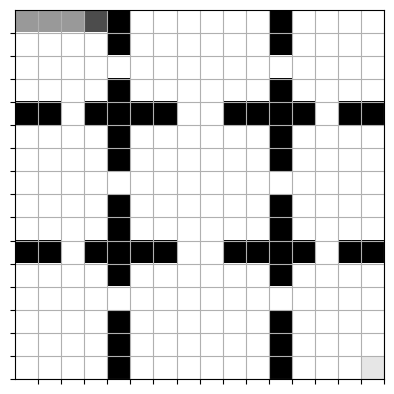

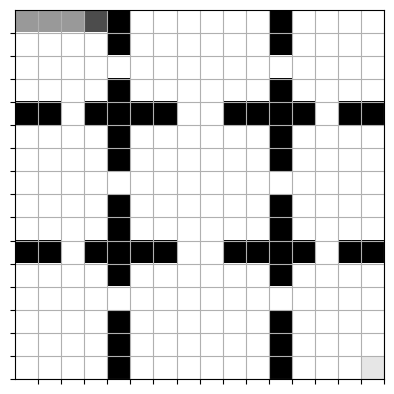

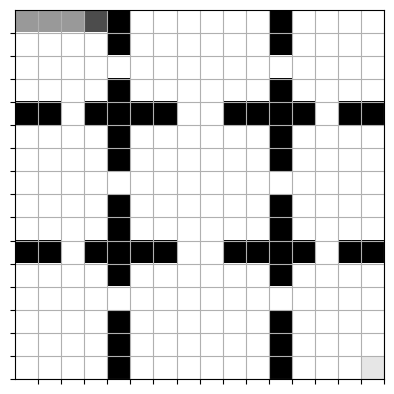

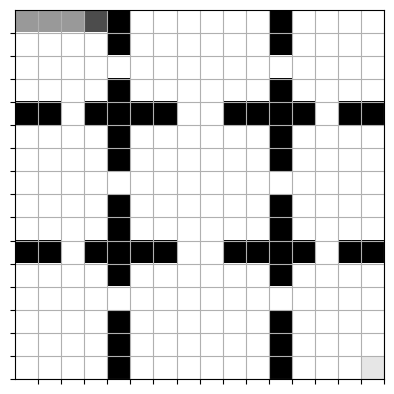

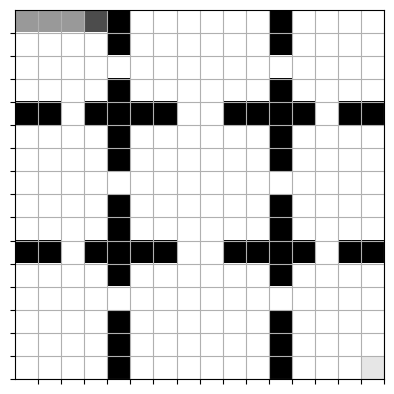

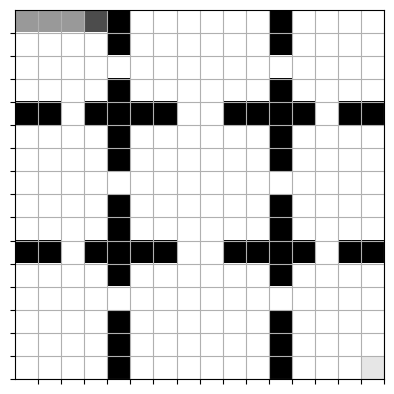

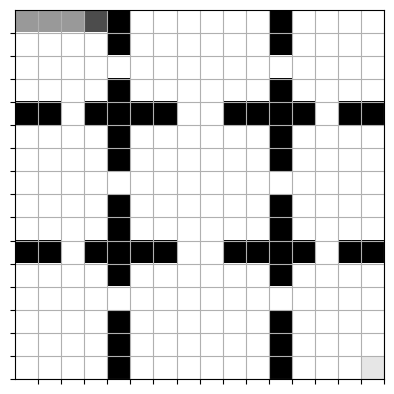

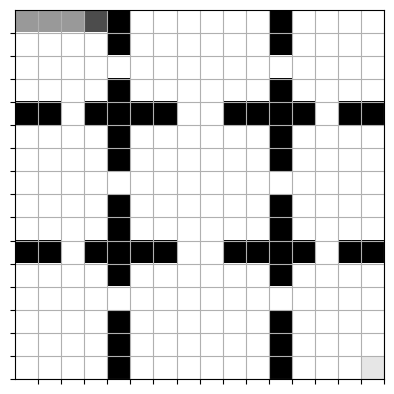

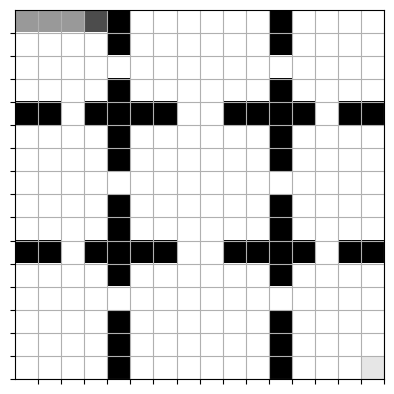

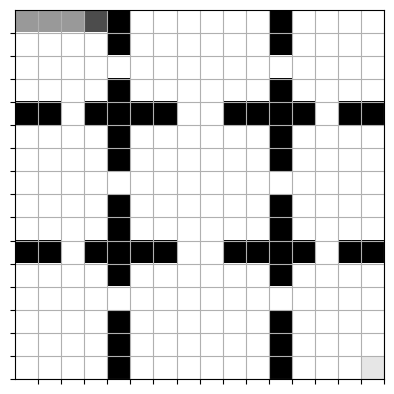

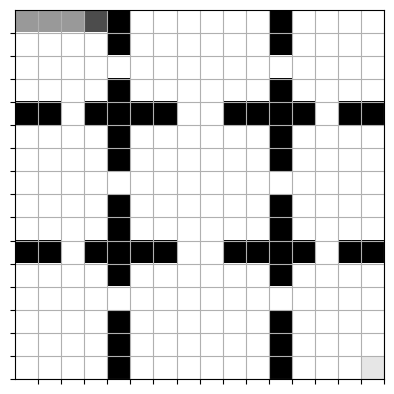

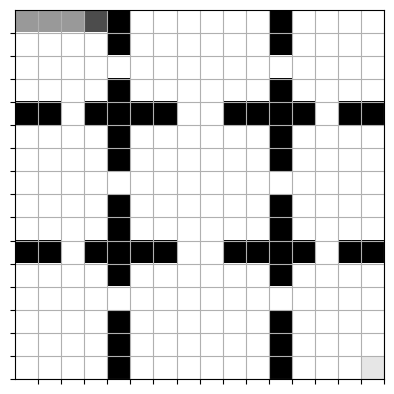

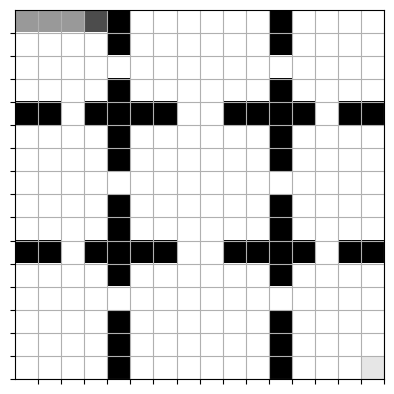

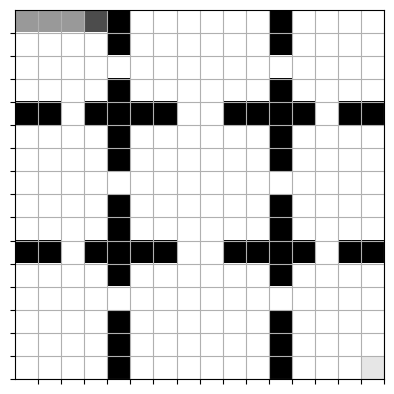

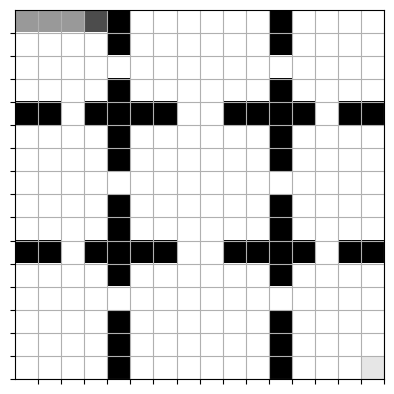

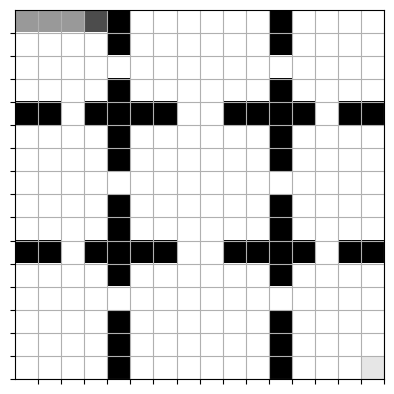

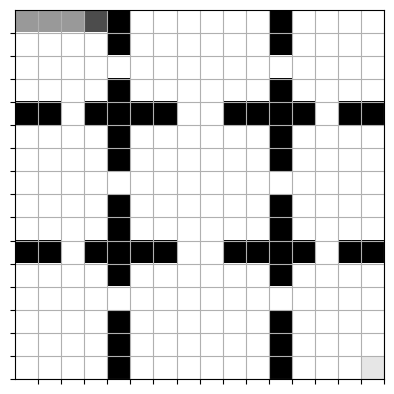

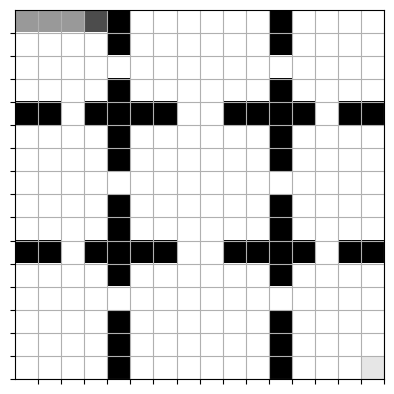

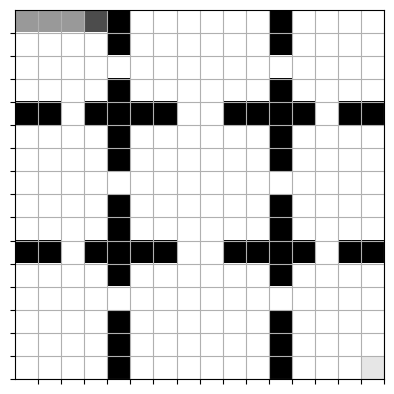

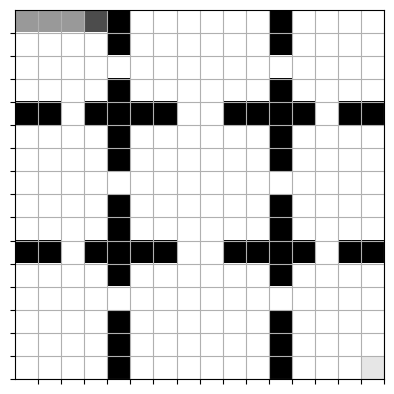

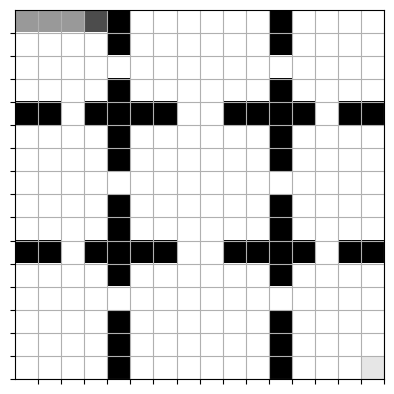

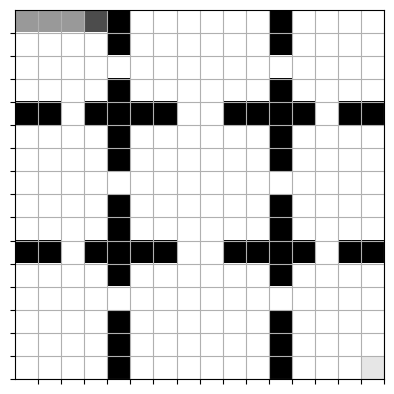

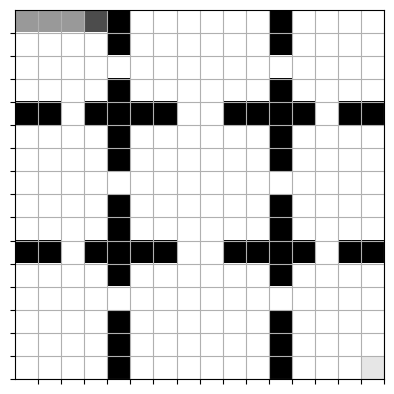

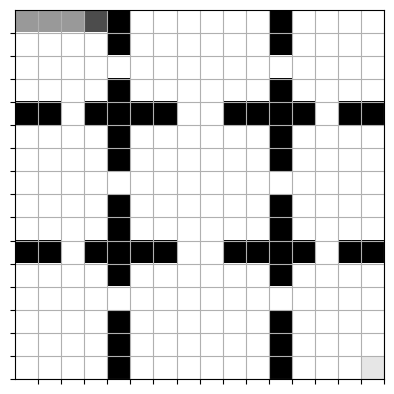

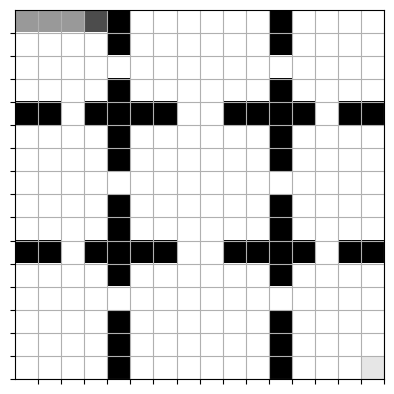

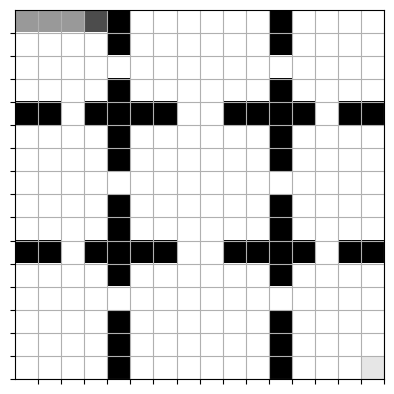

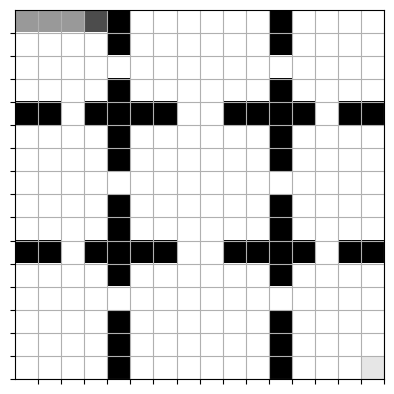

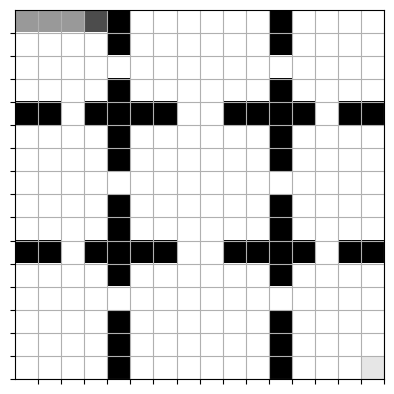

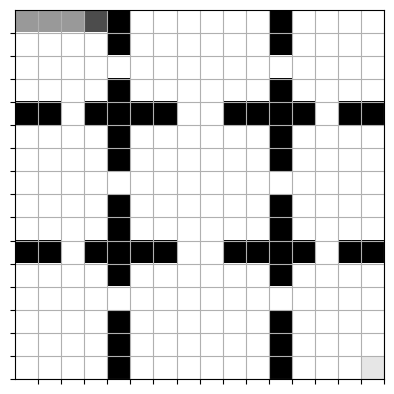

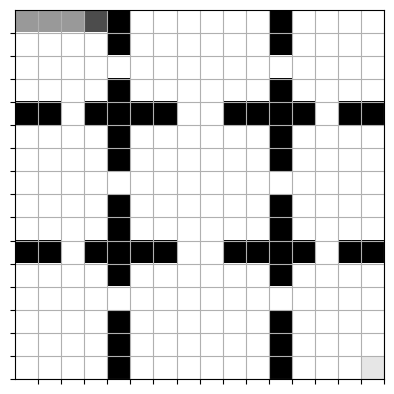

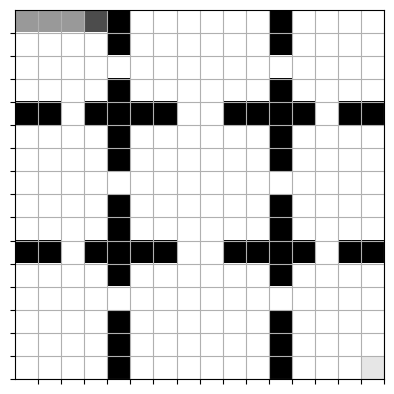

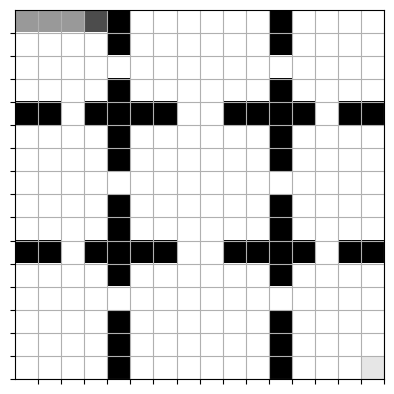

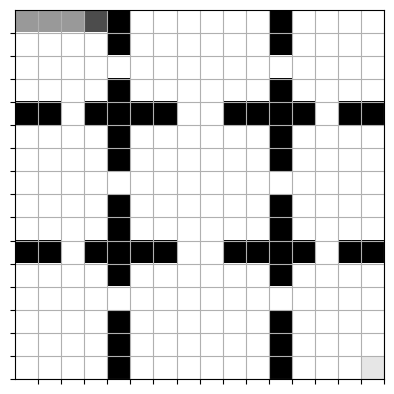

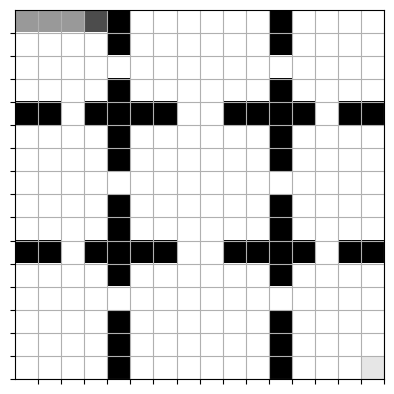

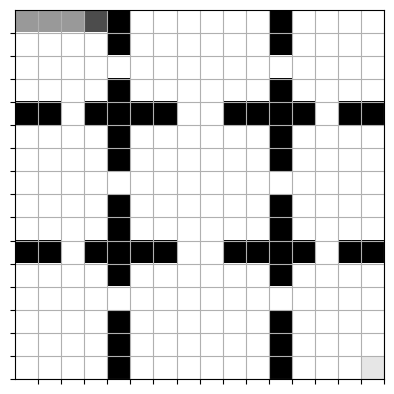

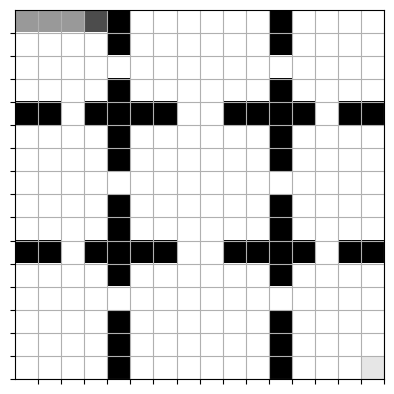

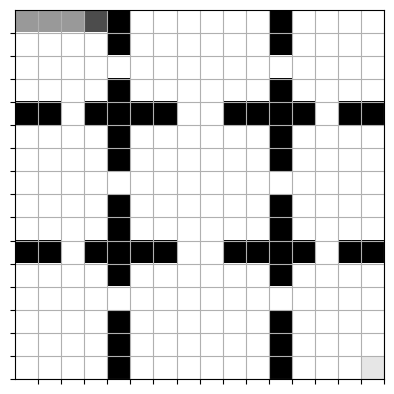

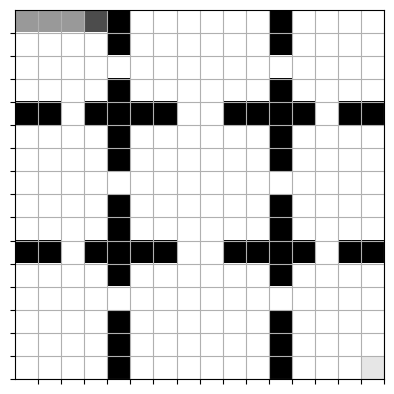

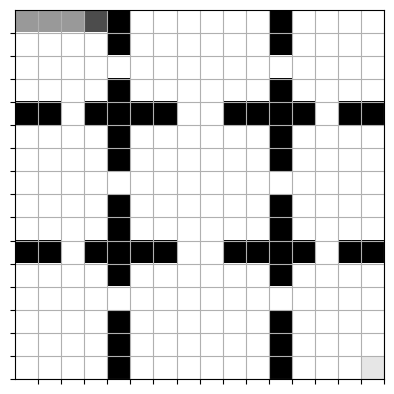

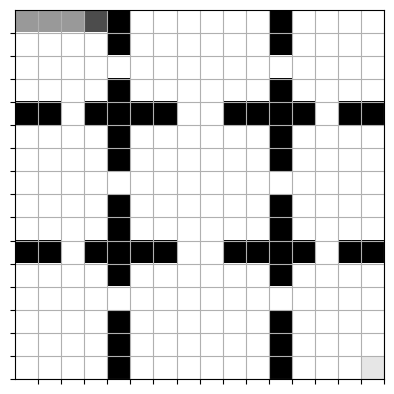

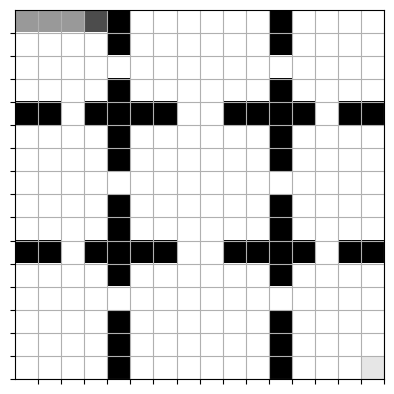

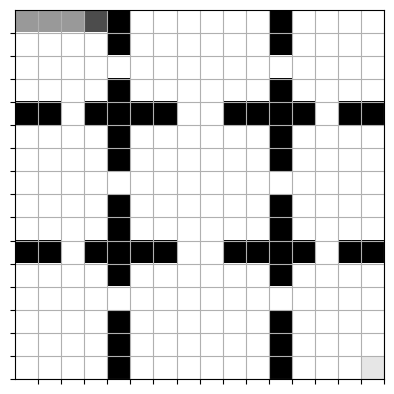

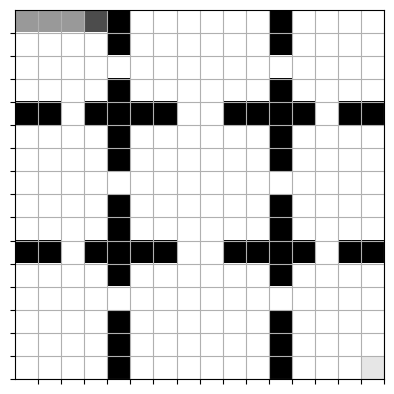

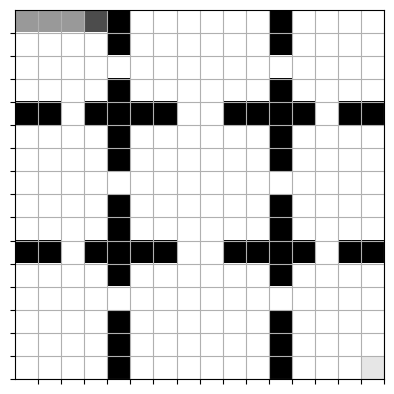

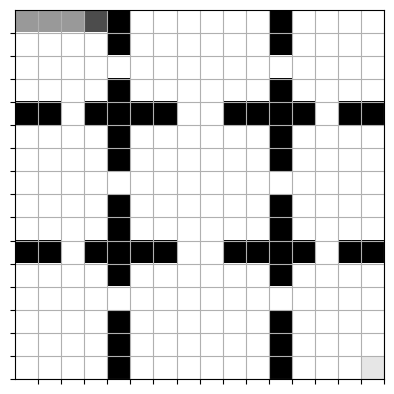

Error in callback <function flush_figures at 0x789ad08912d0> (for post_execute):


KeyboardInterrupt: ignored

In [174]:
env.reset((0, 0))
done = 'not_over'
while done == 'not_over':
    action = agent_off.choose_action(step, obs)

    new_obs, rew, done = env.act(action)

    step += 1
    obs = new_obs
    plt.figure()
    show(env)
print(step)